# Regression using a Neural Network (Pytorch)
The data is in 'housing.csv'. <br>
Each row in the table is a data point:  the features of an area in California <br>
Clearly, the `median_house_value` is correlated with some other features, e.g., `median_income` and location <br>
Thus, we can estimate `median_house_value` = regression_model(`median_income`, `longitude`, `latitude`, ...) <br>
The taks is to build an MLP regressor to predict `median_house_value` using the other features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

### Data pre-processing: remove NaN

In [4]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'].fillna((housing['total_bedrooms'].mean()), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data pre-processing: Convert categorical data to numerical data - "ocean_proximity"

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#We can use one-hot encoding method by calling pd.get_dummies
categorical_columns=['ocean_proximity'] # must be a list
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### Visualize the data

Text(0.5, 1.0, 'median_income')

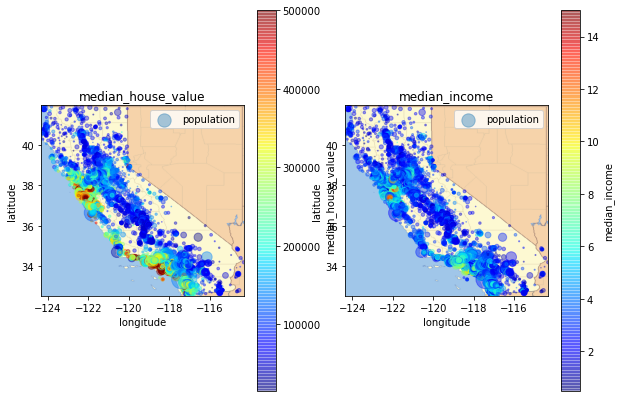

In [8]:
from skimage.io import imread
california_img = imread('california.png')
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)
#---------------------------------------------
# the parameter c refers to color
# thus, median_house_value is color-coded in the left plot
fig, ax =plt.subplots(1,2)
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
#---------------------------------------------
# the parameter c refers to color
# thus, median_income is color-coded in the right plot
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

### Prepare the Training and Testing Datasets

In [9]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [10]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values.astype('float32')
Y=Y.values.astype('float32')

### trainnig, validation, testing split

In [12]:
#trainnig, validation, testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


In [13]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scalerX=MinMaxScaler()
scalerX.fit(X_train) # think about why fit to X_train, not X ?
X_train=scalerX.transform(X_train)
X_val=scalerX.transform(X_val)
X_test=scalerX.transform(X_test)

In [14]:
X_train[0]

array([0.5786848 , 0.38044596, 0.19607843, 0.12570114, 0.13671634,
       0.00983827, 0.02795593, 0.11055019, 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
#normalize the output to facilitate convergence
Y_train_max=Y_train.max()
Y_train/=Y_train_max
Y_val/=Y_train_max
Y_test/=Y_train_max

### use LinearRegression as the baseline model

In [16]:
#step1:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

In [17]:
#step2:
linear_model.fit(X_train, Y_train)

LinearRegression()

In [18]:
linear_model.coef_

array([-0.5266751 , -0.4705757 ,  0.11070077, -0.3135679 ,  0.87252647,
       -2.802685  ,  1.0090173 ,  1.1304909 , -0.04724935, -0.12497991,
        0.26538444, -0.05612908, -0.03702427], dtype=float32)

In [19]:
linear_model.intercept_

0.5496527

Evaluate model on testing set
MSE= 0.018863903
MAE= 0.09931181
MAPE= 0.28951436


Text(0, 0.5, 'Y_test_pred')

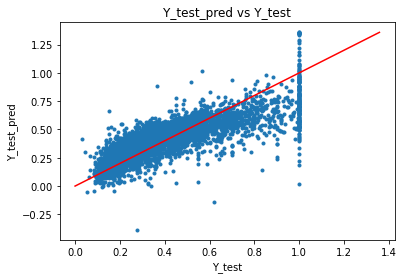

In [20]:
#step3:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
#step6: 
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

## Your work begins here
see NN_nonlinear_regression_Pytorch.ipynb

#### define a dataset to hold/represent the data

In [21]:
#I give you the code here, because it is tricky
import torch
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y.reshape(-1, 1) #this is very important
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # use the notation DatasetName[idx]
        # to get a data point (x,y) by idx
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [22]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [23]:
dataset_train[0] # get the first data point in the traning set

(tensor([0.5787, 0.3804, 0.1961, 0.1257, 0.1367, 0.0098, 0.0280, 0.1106, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000]),
 tensor([0.1982]))

In [24]:
len(dataset_train) # get the number of data points in the training set

14860

create dataloaders which will be used to generate minibatches <br>
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [25]:
from torch.utils.data import DataLoader as torch_dataloader
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0)

In [26]:
len(dataloader_train) # get the number of minibatches

233

In [27]:
#verify the shape of each tensor in a batch
for batch_idx, (X, Y) in enumerate(dataloader_train):
    print(batch_idx, X.size(), Y.size())

0 torch.Size([64, 13]) torch.Size([64, 1])
1 torch.Size([64, 13]) torch.Size([64, 1])
2 torch.Size([64, 13]) torch.Size([64, 1])
3 torch.Size([64, 13]) torch.Size([64, 1])
4 torch.Size([64, 13]) torch.Size([64, 1])
5 torch.Size([64, 13]) torch.Size([64, 1])
6 torch.Size([64, 13]) torch.Size([64, 1])
7 torch.Size([64, 13]) torch.Size([64, 1])
8 torch.Size([64, 13]) torch.Size([64, 1])
9 torch.Size([64, 13]) torch.Size([64, 1])
10 torch.Size([64, 13]) torch.Size([64, 1])
11 torch.Size([64, 13]) torch.Size([64, 1])
12 torch.Size([64, 13]) torch.Size([64, 1])
13 torch.Size([64, 13]) torch.Size([64, 1])
14 torch.Size([64, 13]) torch.Size([64, 1])
15 torch.Size([64, 13]) torch.Size([64, 1])
16 torch.Size([64, 13]) torch.Size([64, 1])
17 torch.Size([64, 13]) torch.Size([64, 1])
18 torch.Size([64, 13]) torch.Size([64, 1])
19 torch.Size([64, 13]) torch.Size([64, 1])
20 torch.Size([64, 13]) torch.Size([64, 1])
21 torch.Size([64, 13]) torch.Size([64, 1])
22 torch.Size([64, 13]) torch.Size([64, 1]

221 torch.Size([64, 13]) torch.Size([64, 1])
222 torch.Size([64, 13]) torch.Size([64, 1])
223 torch.Size([64, 13]) torch.Size([64, 1])
224 torch.Size([64, 13]) torch.Size([64, 1])
225 torch.Size([64, 13]) torch.Size([64, 1])
226 torch.Size([64, 13]) torch.Size([64, 1])
227 torch.Size([64, 13]) torch.Size([64, 1])
228 torch.Size([64, 13]) torch.Size([64, 1])
229 torch.Size([64, 13]) torch.Size([64, 1])
230 torch.Size([64, 13]) torch.Size([64, 1])
231 torch.Size([64, 13]) torch.Size([64, 1])
232 torch.Size([12, 13]) torch.Size([12, 1])


#### Now, let's build a neural network that has many hidden layers and nonlinear activation - softplus

In [28]:
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, output_dim)        
    def forward(self, x):
        x=self.layer1(x)
        x=nnF.softplus(x)
        x=self.layer2(x)
        x=nnF.softplus(x)
        y=self.layer3(x)
        return y

create an instance object of the class

In [50]:
model=Net(input_dim=13, output_dim=1, n_units=6)

In [51]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=13, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=6, bias=True)
  (layer3): Linear(in_features=6, out_features=1, bias=True)
)

define a function to train the neural network in one epoch

In [52]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Yp = model(X)#forward pass
        loss = torch.mean((Yp-Y)**2) # MSE loss or other loss
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    return loss_train

define a function to evaluate the neural network on the validation set or the testing set

In [53]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    mae_test=0
    sample_count=0
    with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Yp = model(X)#forward pass
            loss_test+=torch.sum((Yp-Y)**2).item()
            mae_test+= torch.sum((Yp-Y).abs()).item()
            sample_count+=X.size(0)
    loss_test/=sample_count
    mae_test/=sample_count
    return loss_test, mae_test

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

In [54]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train the neural network model for many epochs <br>
It may need 100 epochs to converge.
So, we will not save any model to harddrive 

In [55]:
loss_train_list=[]
loss_val_list=[]

In [56]:
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/14860 (0%)]	Loss: 0.395823
Train Epoch: 0 [64/14860 (0%)]	Loss: 0.319713
Train Epoch: 0 [128/14860 (1%)]	Loss: 0.218947
Train Epoch: 0 [192/14860 (1%)]	Loss: 0.153023
Train Epoch: 0 [256/14860 (2%)]	Loss: 0.077687
Train Epoch: 0 [320/14860 (2%)]	Loss: 0.049761
Train Epoch: 0 [384/14860 (3%)]	Loss: 0.057627
Train Epoch: 0 [448/14860 (3%)]	Loss: 0.068071
Train Epoch: 0 [512/14860 (3%)]	Loss: 0.113345
Train Epoch: 0 [576/14860 (4%)]	Loss: 0.147933
Train Epoch: 0 [640/14860 (4%)]	Loss: 0.159615
Train Epoch: 0 [704/14860 (5%)]	Loss: 0.148686
Train Epoch: 0 [768/14860 (5%)]	Loss: 0.143134
Train Epoch: 0 [832/14860 (6%)]	Loss: 0.094871
Train Epoch: 0 [896/14860 (6%)]	Loss: 0.078435
Train Epoch: 0 [960/14860 (6%)]	Loss: 0.068235
Train Epoch: 0 [1024/14860 (7%)]	Loss: 0.064955
Train Epoch: 0 [1088/14860 (7%)]	Loss: 0.051734
Train Epoch: 0 [1152/14860 (8%)]	Loss: 0.043975
Train Epoch: 0 [1216/14860 (8%)]	Loss: 0.034590
Train Epoch: 0 [1280/14860 (9%)]	Loss: 0.073008
Train Epoch

Train Epoch: 0 [10816/14860 (73%)]	Loss: 0.048953
Train Epoch: 0 [10880/14860 (73%)]	Loss: 0.070139
Train Epoch: 0 [10944/14860 (73%)]	Loss: 0.042297
Train Epoch: 0 [11008/14860 (74%)]	Loss: 0.052875
Train Epoch: 0 [11072/14860 (74%)]	Loss: 0.052379
Train Epoch: 0 [11136/14860 (75%)]	Loss: 0.033727
Train Epoch: 0 [11200/14860 (75%)]	Loss: 0.055637
Train Epoch: 0 [11264/14860 (76%)]	Loss: 0.059002
Train Epoch: 0 [11328/14860 (76%)]	Loss: 0.047936
Train Epoch: 0 [11392/14860 (76%)]	Loss: 0.053390
Train Epoch: 0 [11456/14860 (77%)]	Loss: 0.063112
Train Epoch: 0 [11520/14860 (77%)]	Loss: 0.067784
Train Epoch: 0 [11584/14860 (78%)]	Loss: 0.046274
Train Epoch: 0 [11648/14860 (78%)]	Loss: 0.061764
Train Epoch: 0 [11712/14860 (79%)]	Loss: 0.069306
Train Epoch: 0 [11776/14860 (79%)]	Loss: 0.068782
Train Epoch: 0 [11840/14860 (79%)]	Loss: 0.039031
Train Epoch: 0 [11904/14860 (80%)]	Loss: 0.067663
Train Epoch: 0 [11968/14860 (80%)]	Loss: 0.048838
Train Epoch: 0 [12032/14860 (81%)]	Loss: 0.041366


Train Epoch: 1 [11648/14860 (78%)]	Loss: 0.030439
Train Epoch: 1 [11712/14860 (79%)]	Loss: 0.043943
Train Epoch: 1 [11776/14860 (79%)]	Loss: 0.041367
Train Epoch: 1 [11840/14860 (79%)]	Loss: 0.033038
Train Epoch: 1 [11904/14860 (80%)]	Loss: 0.047718
Train Epoch: 1 [11968/14860 (80%)]	Loss: 0.032932
Train Epoch: 1 [12032/14860 (81%)]	Loss: 0.047718
Train Epoch: 1 [12096/14860 (81%)]	Loss: 0.064703
Train Epoch: 1 [12160/14860 (82%)]	Loss: 0.039147
Train Epoch: 1 [12224/14860 (82%)]	Loss: 0.045911
Train Epoch: 1 [12288/14860 (82%)]	Loss: 0.055375
Train Epoch: 1 [12352/14860 (83%)]	Loss: 0.048354
Train Epoch: 1 [12416/14860 (83%)]	Loss: 0.037945
Train Epoch: 1 [12480/14860 (84%)]	Loss: 0.036377
Train Epoch: 1 [12544/14860 (84%)]	Loss: 0.042899
Train Epoch: 1 [12608/14860 (85%)]	Loss: 0.041485
Train Epoch: 1 [12672/14860 (85%)]	Loss: 0.033156
Train Epoch: 1 [12736/14860 (85%)]	Loss: 0.042001
Train Epoch: 1 [12800/14860 (86%)]	Loss: 0.042191
Train Epoch: 1 [12864/14860 (86%)]	Loss: 0.054955


Train Epoch: 2 [10496/14860 (70%)]	Loss: 0.040041
Train Epoch: 2 [10560/14860 (71%)]	Loss: 0.048240
Train Epoch: 2 [10624/14860 (71%)]	Loss: 0.030943
Train Epoch: 2 [10688/14860 (72%)]	Loss: 0.035283
Train Epoch: 2 [10752/14860 (72%)]	Loss: 0.045744
Train Epoch: 2 [10816/14860 (73%)]	Loss: 0.028672
Train Epoch: 2 [10880/14860 (73%)]	Loss: 0.054222
Train Epoch: 2 [10944/14860 (73%)]	Loss: 0.032657
Train Epoch: 2 [11008/14860 (74%)]	Loss: 0.038258
Train Epoch: 2 [11072/14860 (74%)]	Loss: 0.027836
Train Epoch: 2 [11136/14860 (75%)]	Loss: 0.042384
Train Epoch: 2 [11200/14860 (75%)]	Loss: 0.033452
Train Epoch: 2 [11264/14860 (76%)]	Loss: 0.032956
Train Epoch: 2 [11328/14860 (76%)]	Loss: 0.027980
Train Epoch: 2 [11392/14860 (76%)]	Loss: 0.045963
Train Epoch: 2 [11456/14860 (77%)]	Loss: 0.038504
Train Epoch: 2 [11520/14860 (77%)]	Loss: 0.027503
Train Epoch: 2 [11584/14860 (78%)]	Loss: 0.050311
Train Epoch: 2 [11648/14860 (78%)]	Loss: 0.037546
Train Epoch: 2 [11712/14860 (79%)]	Loss: 0.038722


Train Epoch: 3 [9152/14860 (61%)]	Loss: 0.034846
Train Epoch: 3 [9216/14860 (62%)]	Loss: 0.030873
Train Epoch: 3 [9280/14860 (62%)]	Loss: 0.037150
Train Epoch: 3 [9344/14860 (63%)]	Loss: 0.029256
Train Epoch: 3 [9408/14860 (63%)]	Loss: 0.031716
Train Epoch: 3 [9472/14860 (64%)]	Loss: 0.033826
Train Epoch: 3 [9536/14860 (64%)]	Loss: 0.038539
Train Epoch: 3 [9600/14860 (64%)]	Loss: 0.039056
Train Epoch: 3 [9664/14860 (65%)]	Loss: 0.035181
Train Epoch: 3 [9728/14860 (65%)]	Loss: 0.034560
Train Epoch: 3 [9792/14860 (66%)]	Loss: 0.054784
Train Epoch: 3 [9856/14860 (66%)]	Loss: 0.027309
Train Epoch: 3 [9920/14860 (67%)]	Loss: 0.028509
Train Epoch: 3 [9984/14860 (67%)]	Loss: 0.015634
Train Epoch: 3 [10048/14860 (67%)]	Loss: 0.042511
Train Epoch: 3 [10112/14860 (68%)]	Loss: 0.029882
Train Epoch: 3 [10176/14860 (68%)]	Loss: 0.039450
Train Epoch: 3 [10240/14860 (69%)]	Loss: 0.036066
Train Epoch: 3 [10304/14860 (69%)]	Loss: 0.045947
Train Epoch: 3 [10368/14860 (70%)]	Loss: 0.031809
Train Epoch: 3

Train Epoch: 4 [5888/14860 (39%)]	Loss: 0.028185
Train Epoch: 4 [5952/14860 (40%)]	Loss: 0.022097
Train Epoch: 4 [6016/14860 (40%)]	Loss: 0.027641
Train Epoch: 4 [6080/14860 (41%)]	Loss: 0.049479
Train Epoch: 4 [6144/14860 (41%)]	Loss: 0.037538
Train Epoch: 4 [6208/14860 (42%)]	Loss: 0.033788
Train Epoch: 4 [6272/14860 (42%)]	Loss: 0.028922
Train Epoch: 4 [6336/14860 (42%)]	Loss: 0.031674
Train Epoch: 4 [6400/14860 (43%)]	Loss: 0.030494
Train Epoch: 4 [6464/14860 (43%)]	Loss: 0.022197
Train Epoch: 4 [6528/14860 (44%)]	Loss: 0.026823
Train Epoch: 4 [6592/14860 (44%)]	Loss: 0.027919
Train Epoch: 4 [6656/14860 (45%)]	Loss: 0.039458
Train Epoch: 4 [6720/14860 (45%)]	Loss: 0.023278
Train Epoch: 4 [6784/14860 (45%)]	Loss: 0.045469
Train Epoch: 4 [6848/14860 (46%)]	Loss: 0.038695
Train Epoch: 4 [6912/14860 (46%)]	Loss: 0.030670
Train Epoch: 4 [6976/14860 (47%)]	Loss: 0.032052
Train Epoch: 4 [7040/14860 (47%)]	Loss: 0.021775
Train Epoch: 4 [7104/14860 (48%)]	Loss: 0.025534
Train Epoch: 4 [7168

Train Epoch: 5 [3200/14860 (21%)]	Loss: 0.033895
Train Epoch: 5 [3264/14860 (22%)]	Loss: 0.015655
Train Epoch: 5 [3328/14860 (22%)]	Loss: 0.036841
Train Epoch: 5 [3392/14860 (23%)]	Loss: 0.022343
Train Epoch: 5 [3456/14860 (23%)]	Loss: 0.028899
Train Epoch: 5 [3520/14860 (24%)]	Loss: 0.031144
Train Epoch: 5 [3584/14860 (24%)]	Loss: 0.015937
Train Epoch: 5 [3648/14860 (24%)]	Loss: 0.028839
Train Epoch: 5 [3712/14860 (25%)]	Loss: 0.021309
Train Epoch: 5 [3776/14860 (25%)]	Loss: 0.038426
Train Epoch: 5 [3840/14860 (26%)]	Loss: 0.024720
Train Epoch: 5 [3904/14860 (26%)]	Loss: 0.019168
Train Epoch: 5 [3968/14860 (27%)]	Loss: 0.029755
Train Epoch: 5 [4032/14860 (27%)]	Loss: 0.031801
Train Epoch: 5 [4096/14860 (27%)]	Loss: 0.015671
Train Epoch: 5 [4160/14860 (28%)]	Loss: 0.014325
Train Epoch: 5 [4224/14860 (28%)]	Loss: 0.021949
Train Epoch: 5 [4288/14860 (29%)]	Loss: 0.021406
Train Epoch: 5 [4352/14860 (29%)]	Loss: 0.022279
Train Epoch: 5 [4416/14860 (30%)]	Loss: 0.021588
Train Epoch: 5 [4480

Train Epoch: 6 [1536/14860 (10%)]	Loss: 0.023290
Train Epoch: 6 [1600/14860 (11%)]	Loss: 0.029108
Train Epoch: 6 [1664/14860 (11%)]	Loss: 0.021312
Train Epoch: 6 [1728/14860 (12%)]	Loss: 0.014428
Train Epoch: 6 [1792/14860 (12%)]	Loss: 0.014725
Train Epoch: 6 [1856/14860 (12%)]	Loss: 0.013284
Train Epoch: 6 [1920/14860 (13%)]	Loss: 0.013422
Train Epoch: 6 [1984/14860 (13%)]	Loss: 0.030458
Train Epoch: 6 [2048/14860 (14%)]	Loss: 0.029995
Train Epoch: 6 [2112/14860 (14%)]	Loss: 0.028252
Train Epoch: 6 [2176/14860 (15%)]	Loss: 0.029932
Train Epoch: 6 [2240/14860 (15%)]	Loss: 0.022423
Train Epoch: 6 [2304/14860 (15%)]	Loss: 0.020732
Train Epoch: 6 [2368/14860 (16%)]	Loss: 0.024123
Train Epoch: 6 [2432/14860 (16%)]	Loss: 0.018753
Train Epoch: 6 [2496/14860 (17%)]	Loss: 0.028442
Train Epoch: 6 [2560/14860 (17%)]	Loss: 0.024674
Train Epoch: 6 [2624/14860 (18%)]	Loss: 0.020046
Train Epoch: 6 [2688/14860 (18%)]	Loss: 0.020617
Train Epoch: 6 [2752/14860 (18%)]	Loss: 0.024248
Train Epoch: 6 [2816

Train Epoch: 7 [832/14860 (6%)]	Loss: 0.027926
Train Epoch: 7 [896/14860 (6%)]	Loss: 0.023453
Train Epoch: 7 [960/14860 (6%)]	Loss: 0.020106
Train Epoch: 7 [1024/14860 (7%)]	Loss: 0.021586
Train Epoch: 7 [1088/14860 (7%)]	Loss: 0.011034
Train Epoch: 7 [1152/14860 (8%)]	Loss: 0.023152
Train Epoch: 7 [1216/14860 (8%)]	Loss: 0.034096
Train Epoch: 7 [1280/14860 (9%)]	Loss: 0.016268
Train Epoch: 7 [1344/14860 (9%)]	Loss: 0.025575
Train Epoch: 7 [1408/14860 (9%)]	Loss: 0.034614
Train Epoch: 7 [1472/14860 (10%)]	Loss: 0.024886
Train Epoch: 7 [1536/14860 (10%)]	Loss: 0.021076
Train Epoch: 7 [1600/14860 (11%)]	Loss: 0.020191
Train Epoch: 7 [1664/14860 (11%)]	Loss: 0.032066
Train Epoch: 7 [1728/14860 (12%)]	Loss: 0.023687
Train Epoch: 7 [1792/14860 (12%)]	Loss: 0.016747
Train Epoch: 7 [1856/14860 (12%)]	Loss: 0.018370
Train Epoch: 7 [1920/14860 (13%)]	Loss: 0.037977
Train Epoch: 7 [1984/14860 (13%)]	Loss: 0.020134
Train Epoch: 7 [2048/14860 (14%)]	Loss: 0.021610
Train Epoch: 7 [2112/14860 (14%)]

Train Epoch: 7 [13120/14860 (88%)]	Loss: 0.016148
Train Epoch: 7 [13184/14860 (88%)]	Loss: 0.015816
Train Epoch: 7 [13248/14860 (89%)]	Loss: 0.012524
Train Epoch: 7 [13312/14860 (89%)]	Loss: 0.021076
Train Epoch: 7 [13376/14860 (90%)]	Loss: 0.014266
Train Epoch: 7 [13440/14860 (90%)]	Loss: 0.025794
Train Epoch: 7 [13504/14860 (91%)]	Loss: 0.020754
Train Epoch: 7 [13568/14860 (91%)]	Loss: 0.018226
Train Epoch: 7 [13632/14860 (91%)]	Loss: 0.018776
Train Epoch: 7 [13696/14860 (92%)]	Loss: 0.027372
Train Epoch: 7 [13760/14860 (92%)]	Loss: 0.029419
Train Epoch: 7 [13824/14860 (93%)]	Loss: 0.022838
Train Epoch: 7 [13888/14860 (93%)]	Loss: 0.028520
Train Epoch: 7 [13952/14860 (94%)]	Loss: 0.018030
Train Epoch: 7 [14016/14860 (94%)]	Loss: 0.017972
Train Epoch: 7 [14080/14860 (94%)]	Loss: 0.037755
Train Epoch: 7 [14144/14860 (95%)]	Loss: 0.024695
Train Epoch: 7 [14208/14860 (95%)]	Loss: 0.013760
Train Epoch: 7 [14272/14860 (96%)]	Loss: 0.021624
Train Epoch: 7 [14336/14860 (96%)]	Loss: 0.020036


Train Epoch: 8 [14720/14860 (99%)]	Loss: 0.025114
Train Epoch: 8 [14784/14860 (99%)]	Loss: 0.020330
Train Epoch: 8 [2784/14860 (100%)]	Loss: 0.012292
epoch 8 training loss: 0.02148007302117322
epoch 8 validation loss: 0.023828849737638422
Train Epoch: 9 [0/14860 (0%)]	Loss: 0.015156
Train Epoch: 9 [64/14860 (0%)]	Loss: 0.019391
Train Epoch: 9 [128/14860 (1%)]	Loss: 0.029648
Train Epoch: 9 [192/14860 (1%)]	Loss: 0.016821
Train Epoch: 9 [256/14860 (2%)]	Loss: 0.013076
Train Epoch: 9 [320/14860 (2%)]	Loss: 0.020747
Train Epoch: 9 [384/14860 (3%)]	Loss: 0.023427
Train Epoch: 9 [448/14860 (3%)]	Loss: 0.017140
Train Epoch: 9 [512/14860 (3%)]	Loss: 0.017577
Train Epoch: 9 [576/14860 (4%)]	Loss: 0.025564
Train Epoch: 9 [640/14860 (4%)]	Loss: 0.020309
Train Epoch: 9 [704/14860 (5%)]	Loss: 0.013536
Train Epoch: 9 [768/14860 (5%)]	Loss: 0.021780
Train Epoch: 9 [832/14860 (6%)]	Loss: 0.015907
Train Epoch: 9 [896/14860 (6%)]	Loss: 0.014613
Train Epoch: 9 [960/14860 (6%)]	Loss: 0.023658
Train Epoch:

Train Epoch: 9 [11072/14860 (74%)]	Loss: 0.016795
Train Epoch: 9 [11136/14860 (75%)]	Loss: 0.015016
Train Epoch: 9 [11200/14860 (75%)]	Loss: 0.028202
Train Epoch: 9 [11264/14860 (76%)]	Loss: 0.016640
Train Epoch: 9 [11328/14860 (76%)]	Loss: 0.017737
Train Epoch: 9 [11392/14860 (76%)]	Loss: 0.034418
Train Epoch: 9 [11456/14860 (77%)]	Loss: 0.026666
Train Epoch: 9 [11520/14860 (77%)]	Loss: 0.029649
Train Epoch: 9 [11584/14860 (78%)]	Loss: 0.032253
Train Epoch: 9 [11648/14860 (78%)]	Loss: 0.016470
Train Epoch: 9 [11712/14860 (79%)]	Loss: 0.039439
Train Epoch: 9 [11776/14860 (79%)]	Loss: 0.028975
Train Epoch: 9 [11840/14860 (79%)]	Loss: 0.013459
Train Epoch: 9 [11904/14860 (80%)]	Loss: 0.018390
Train Epoch: 9 [11968/14860 (80%)]	Loss: 0.025749
Train Epoch: 9 [12032/14860 (81%)]	Loss: 0.020774
Train Epoch: 9 [12096/14860 (81%)]	Loss: 0.026945
Train Epoch: 9 [12160/14860 (82%)]	Loss: 0.012502
Train Epoch: 9 [12224/14860 (82%)]	Loss: 0.027121
Train Epoch: 9 [12288/14860 (82%)]	Loss: 0.034807


Train Epoch: 10 [7296/14860 (49%)]	Loss: 0.021280
Train Epoch: 10 [7360/14860 (49%)]	Loss: 0.013788
Train Epoch: 10 [7424/14860 (50%)]	Loss: 0.015205
Train Epoch: 10 [7488/14860 (50%)]	Loss: 0.022387
Train Epoch: 10 [7552/14860 (51%)]	Loss: 0.020810
Train Epoch: 10 [7616/14860 (51%)]	Loss: 0.022383
Train Epoch: 10 [7680/14860 (52%)]	Loss: 0.016582
Train Epoch: 10 [7744/14860 (52%)]	Loss: 0.023458
Train Epoch: 10 [7808/14860 (52%)]	Loss: 0.023734
Train Epoch: 10 [7872/14860 (53%)]	Loss: 0.024381
Train Epoch: 10 [7936/14860 (53%)]	Loss: 0.020856
Train Epoch: 10 [8000/14860 (54%)]	Loss: 0.019475
Train Epoch: 10 [8064/14860 (54%)]	Loss: 0.026285
Train Epoch: 10 [8128/14860 (55%)]	Loss: 0.010669
Train Epoch: 10 [8192/14860 (55%)]	Loss: 0.027891
Train Epoch: 10 [8256/14860 (55%)]	Loss: 0.033594
Train Epoch: 10 [8320/14860 (56%)]	Loss: 0.019499
Train Epoch: 10 [8384/14860 (56%)]	Loss: 0.020346
Train Epoch: 10 [8448/14860 (57%)]	Loss: 0.035715
Train Epoch: 10 [8512/14860 (57%)]	Loss: 0.026423


Train Epoch: 11 [3520/14860 (24%)]	Loss: 0.013173
Train Epoch: 11 [3584/14860 (24%)]	Loss: 0.017031
Train Epoch: 11 [3648/14860 (24%)]	Loss: 0.013007
Train Epoch: 11 [3712/14860 (25%)]	Loss: 0.016873
Train Epoch: 11 [3776/14860 (25%)]	Loss: 0.032605
Train Epoch: 11 [3840/14860 (26%)]	Loss: 0.020674
Train Epoch: 11 [3904/14860 (26%)]	Loss: 0.023514
Train Epoch: 11 [3968/14860 (27%)]	Loss: 0.015579
Train Epoch: 11 [4032/14860 (27%)]	Loss: 0.028437
Train Epoch: 11 [4096/14860 (27%)]	Loss: 0.030873
Train Epoch: 11 [4160/14860 (28%)]	Loss: 0.026975
Train Epoch: 11 [4224/14860 (28%)]	Loss: 0.018419
Train Epoch: 11 [4288/14860 (29%)]	Loss: 0.025375
Train Epoch: 11 [4352/14860 (29%)]	Loss: 0.014864
Train Epoch: 11 [4416/14860 (30%)]	Loss: 0.023893
Train Epoch: 11 [4480/14860 (30%)]	Loss: 0.018177
Train Epoch: 11 [4544/14860 (30%)]	Loss: 0.031416
Train Epoch: 11 [4608/14860 (31%)]	Loss: 0.024198
Train Epoch: 11 [4672/14860 (31%)]	Loss: 0.021550
Train Epoch: 11 [4736/14860 (32%)]	Loss: 0.019592


epoch 11 validation loss: 0.02251458261838548
Train Epoch: 12 [0/14860 (0%)]	Loss: 0.017137
Train Epoch: 12 [64/14860 (0%)]	Loss: 0.029239
Train Epoch: 12 [128/14860 (1%)]	Loss: 0.017115
Train Epoch: 12 [192/14860 (1%)]	Loss: 0.025151
Train Epoch: 12 [256/14860 (2%)]	Loss: 0.017113
Train Epoch: 12 [320/14860 (2%)]	Loss: 0.012617
Train Epoch: 12 [384/14860 (3%)]	Loss: 0.020276
Train Epoch: 12 [448/14860 (3%)]	Loss: 0.019450
Train Epoch: 12 [512/14860 (3%)]	Loss: 0.026557
Train Epoch: 12 [576/14860 (4%)]	Loss: 0.025222
Train Epoch: 12 [640/14860 (4%)]	Loss: 0.026873
Train Epoch: 12 [704/14860 (5%)]	Loss: 0.028493
Train Epoch: 12 [768/14860 (5%)]	Loss: 0.018350
Train Epoch: 12 [832/14860 (6%)]	Loss: 0.017263
Train Epoch: 12 [896/14860 (6%)]	Loss: 0.025029
Train Epoch: 12 [960/14860 (6%)]	Loss: 0.012501
Train Epoch: 12 [1024/14860 (7%)]	Loss: 0.019075
Train Epoch: 12 [1088/14860 (7%)]	Loss: 0.012463
Train Epoch: 12 [1152/14860 (8%)]	Loss: 0.013423
Train Epoch: 12 [1216/14860 (8%)]	Loss: 0.

Train Epoch: 12 [12032/14860 (81%)]	Loss: 0.020132
Train Epoch: 12 [12096/14860 (81%)]	Loss: 0.012918
Train Epoch: 12 [12160/14860 (82%)]	Loss: 0.020771
Train Epoch: 12 [12224/14860 (82%)]	Loss: 0.014235
Train Epoch: 12 [12288/14860 (82%)]	Loss: 0.031027
Train Epoch: 12 [12352/14860 (83%)]	Loss: 0.015018
Train Epoch: 12 [12416/14860 (83%)]	Loss: 0.020228
Train Epoch: 12 [12480/14860 (84%)]	Loss: 0.013558
Train Epoch: 12 [12544/14860 (84%)]	Loss: 0.023337
Train Epoch: 12 [12608/14860 (85%)]	Loss: 0.018212
Train Epoch: 12 [12672/14860 (85%)]	Loss: 0.020684
Train Epoch: 12 [12736/14860 (85%)]	Loss: 0.033370
Train Epoch: 12 [12800/14860 (86%)]	Loss: 0.022269
Train Epoch: 12 [12864/14860 (86%)]	Loss: 0.022139
Train Epoch: 12 [12928/14860 (87%)]	Loss: 0.024519
Train Epoch: 12 [12992/14860 (87%)]	Loss: 0.028870
Train Epoch: 12 [13056/14860 (88%)]	Loss: 0.035030
Train Epoch: 12 [13120/14860 (88%)]	Loss: 0.016652
Train Epoch: 12 [13184/14860 (88%)]	Loss: 0.016130
Train Epoch: 12 [13248/14860 (8

Train Epoch: 13 [8192/14860 (55%)]	Loss: 0.019923
Train Epoch: 13 [8256/14860 (55%)]	Loss: 0.018946
Train Epoch: 13 [8320/14860 (56%)]	Loss: 0.017174
Train Epoch: 13 [8384/14860 (56%)]	Loss: 0.020019
Train Epoch: 13 [8448/14860 (57%)]	Loss: 0.028554
Train Epoch: 13 [8512/14860 (57%)]	Loss: 0.026881
Train Epoch: 13 [8576/14860 (58%)]	Loss: 0.020982
Train Epoch: 13 [8640/14860 (58%)]	Loss: 0.018013
Train Epoch: 13 [8704/14860 (58%)]	Loss: 0.016116
Train Epoch: 13 [8768/14860 (59%)]	Loss: 0.015295
Train Epoch: 13 [8832/14860 (59%)]	Loss: 0.025689
Train Epoch: 13 [8896/14860 (60%)]	Loss: 0.021041
Train Epoch: 13 [8960/14860 (60%)]	Loss: 0.016945
Train Epoch: 13 [9024/14860 (61%)]	Loss: 0.015745
Train Epoch: 13 [9088/14860 (61%)]	Loss: 0.019958
Train Epoch: 13 [9152/14860 (61%)]	Loss: 0.017107
Train Epoch: 13 [9216/14860 (62%)]	Loss: 0.033788
Train Epoch: 13 [9280/14860 (62%)]	Loss: 0.023202
Train Epoch: 13 [9344/14860 (63%)]	Loss: 0.027133
Train Epoch: 13 [9408/14860 (63%)]	Loss: 0.022411


Train Epoch: 14 [4480/14860 (30%)]	Loss: 0.022731
Train Epoch: 14 [4544/14860 (30%)]	Loss: 0.027235
Train Epoch: 14 [4608/14860 (31%)]	Loss: 0.014070
Train Epoch: 14 [4672/14860 (31%)]	Loss: 0.023096
Train Epoch: 14 [4736/14860 (32%)]	Loss: 0.022145
Train Epoch: 14 [4800/14860 (32%)]	Loss: 0.021564
Train Epoch: 14 [4864/14860 (33%)]	Loss: 0.020037
Train Epoch: 14 [4928/14860 (33%)]	Loss: 0.020303
Train Epoch: 14 [4992/14860 (33%)]	Loss: 0.020982
Train Epoch: 14 [5056/14860 (34%)]	Loss: 0.026409
Train Epoch: 14 [5120/14860 (34%)]	Loss: 0.029963
Train Epoch: 14 [5184/14860 (35%)]	Loss: 0.032785
Train Epoch: 14 [5248/14860 (35%)]	Loss: 0.021222
Train Epoch: 14 [5312/14860 (36%)]	Loss: 0.023100
Train Epoch: 14 [5376/14860 (36%)]	Loss: 0.015005
Train Epoch: 14 [5440/14860 (36%)]	Loss: 0.018978
Train Epoch: 14 [5504/14860 (37%)]	Loss: 0.015936
Train Epoch: 14 [5568/14860 (37%)]	Loss: 0.011884
Train Epoch: 14 [5632/14860 (38%)]	Loss: 0.016857
Train Epoch: 14 [5696/14860 (38%)]	Loss: 0.014845


Train Epoch: 15 [512/14860 (3%)]	Loss: 0.019498
Train Epoch: 15 [576/14860 (4%)]	Loss: 0.019374
Train Epoch: 15 [640/14860 (4%)]	Loss: 0.025154
Train Epoch: 15 [704/14860 (5%)]	Loss: 0.015336
Train Epoch: 15 [768/14860 (5%)]	Loss: 0.019125
Train Epoch: 15 [832/14860 (6%)]	Loss: 0.016306
Train Epoch: 15 [896/14860 (6%)]	Loss: 0.030463
Train Epoch: 15 [960/14860 (6%)]	Loss: 0.025947
Train Epoch: 15 [1024/14860 (7%)]	Loss: 0.009948
Train Epoch: 15 [1088/14860 (7%)]	Loss: 0.027341
Train Epoch: 15 [1152/14860 (8%)]	Loss: 0.023915
Train Epoch: 15 [1216/14860 (8%)]	Loss: 0.032504
Train Epoch: 15 [1280/14860 (9%)]	Loss: 0.011274
Train Epoch: 15 [1344/14860 (9%)]	Loss: 0.022375
Train Epoch: 15 [1408/14860 (9%)]	Loss: 0.024789
Train Epoch: 15 [1472/14860 (10%)]	Loss: 0.012396
Train Epoch: 15 [1536/14860 (10%)]	Loss: 0.019006
Train Epoch: 15 [1600/14860 (11%)]	Loss: 0.018319
Train Epoch: 15 [1664/14860 (11%)]	Loss: 0.014852
Train Epoch: 15 [1728/14860 (12%)]	Loss: 0.014471
Train Epoch: 15 [1792/1

Train Epoch: 15 [12672/14860 (85%)]	Loss: 0.016548
Train Epoch: 15 [12736/14860 (85%)]	Loss: 0.017834
Train Epoch: 15 [12800/14860 (86%)]	Loss: 0.034434
Train Epoch: 15 [12864/14860 (86%)]	Loss: 0.048757
Train Epoch: 15 [12928/14860 (87%)]	Loss: 0.019112
Train Epoch: 15 [12992/14860 (87%)]	Loss: 0.020855
Train Epoch: 15 [13056/14860 (88%)]	Loss: 0.028763
Train Epoch: 15 [13120/14860 (88%)]	Loss: 0.015038
Train Epoch: 15 [13184/14860 (88%)]	Loss: 0.031866
Train Epoch: 15 [13248/14860 (89%)]	Loss: 0.014325
Train Epoch: 15 [13312/14860 (89%)]	Loss: 0.025302
Train Epoch: 15 [13376/14860 (90%)]	Loss: 0.022568
Train Epoch: 15 [13440/14860 (90%)]	Loss: 0.014892
Train Epoch: 15 [13504/14860 (91%)]	Loss: 0.018172
Train Epoch: 15 [13568/14860 (91%)]	Loss: 0.020468
Train Epoch: 15 [13632/14860 (91%)]	Loss: 0.023474
Train Epoch: 15 [13696/14860 (92%)]	Loss: 0.019401
Train Epoch: 15 [13760/14860 (92%)]	Loss: 0.017675
Train Epoch: 15 [13824/14860 (93%)]	Loss: 0.012888
Train Epoch: 15 [13888/14860 (9

Train Epoch: 16 [8832/14860 (59%)]	Loss: 0.021076
Train Epoch: 16 [8896/14860 (60%)]	Loss: 0.015337
Train Epoch: 16 [8960/14860 (60%)]	Loss: 0.020035
Train Epoch: 16 [9024/14860 (61%)]	Loss: 0.029849
Train Epoch: 16 [9088/14860 (61%)]	Loss: 0.021745
Train Epoch: 16 [9152/14860 (61%)]	Loss: 0.020446
Train Epoch: 16 [9216/14860 (62%)]	Loss: 0.021810
Train Epoch: 16 [9280/14860 (62%)]	Loss: 0.021381
Train Epoch: 16 [9344/14860 (63%)]	Loss: 0.023611
Train Epoch: 16 [9408/14860 (63%)]	Loss: 0.027919
Train Epoch: 16 [9472/14860 (64%)]	Loss: 0.045058
Train Epoch: 16 [9536/14860 (64%)]	Loss: 0.032397
Train Epoch: 16 [9600/14860 (64%)]	Loss: 0.014282
Train Epoch: 16 [9664/14860 (65%)]	Loss: 0.019295
Train Epoch: 16 [9728/14860 (65%)]	Loss: 0.017737
Train Epoch: 16 [9792/14860 (66%)]	Loss: 0.020225
Train Epoch: 16 [9856/14860 (66%)]	Loss: 0.017875
Train Epoch: 16 [9920/14860 (67%)]	Loss: 0.022558
Train Epoch: 16 [9984/14860 (67%)]	Loss: 0.014592
Train Epoch: 16 [10048/14860 (67%)]	Loss: 0.014523

Train Epoch: 17 [6208/14860 (42%)]	Loss: 0.013990
Train Epoch: 17 [6272/14860 (42%)]	Loss: 0.026394
Train Epoch: 17 [6336/14860 (42%)]	Loss: 0.016570
Train Epoch: 17 [6400/14860 (43%)]	Loss: 0.017255
Train Epoch: 17 [6464/14860 (43%)]	Loss: 0.023435
Train Epoch: 17 [6528/14860 (44%)]	Loss: 0.018204
Train Epoch: 17 [6592/14860 (44%)]	Loss: 0.018022
Train Epoch: 17 [6656/14860 (45%)]	Loss: 0.019522
Train Epoch: 17 [6720/14860 (45%)]	Loss: 0.025086
Train Epoch: 17 [6784/14860 (45%)]	Loss: 0.020568
Train Epoch: 17 [6848/14860 (46%)]	Loss: 0.025435
Train Epoch: 17 [6912/14860 (46%)]	Loss: 0.027770
Train Epoch: 17 [6976/14860 (47%)]	Loss: 0.030209
Train Epoch: 17 [7040/14860 (47%)]	Loss: 0.018448
Train Epoch: 17 [7104/14860 (48%)]	Loss: 0.025397
Train Epoch: 17 [7168/14860 (48%)]	Loss: 0.032454
Train Epoch: 17 [7232/14860 (48%)]	Loss: 0.021904
Train Epoch: 17 [7296/14860 (49%)]	Loss: 0.013674
Train Epoch: 17 [7360/14860 (49%)]	Loss: 0.027024
Train Epoch: 17 [7424/14860 (50%)]	Loss: 0.018234


Train Epoch: 18 [2496/14860 (17%)]	Loss: 0.014201
Train Epoch: 18 [2560/14860 (17%)]	Loss: 0.012166
Train Epoch: 18 [2624/14860 (18%)]	Loss: 0.028189
Train Epoch: 18 [2688/14860 (18%)]	Loss: 0.028004
Train Epoch: 18 [2752/14860 (18%)]	Loss: 0.018988
Train Epoch: 18 [2816/14860 (19%)]	Loss: 0.014918
Train Epoch: 18 [2880/14860 (19%)]	Loss: 0.011689
Train Epoch: 18 [2944/14860 (20%)]	Loss: 0.012128
Train Epoch: 18 [3008/14860 (20%)]	Loss: 0.031677
Train Epoch: 18 [3072/14860 (21%)]	Loss: 0.018248
Train Epoch: 18 [3136/14860 (21%)]	Loss: 0.023132
Train Epoch: 18 [3200/14860 (21%)]	Loss: 0.024153
Train Epoch: 18 [3264/14860 (22%)]	Loss: 0.023518
Train Epoch: 18 [3328/14860 (22%)]	Loss: 0.014181
Train Epoch: 18 [3392/14860 (23%)]	Loss: 0.023609
Train Epoch: 18 [3456/14860 (23%)]	Loss: 0.037434
Train Epoch: 18 [3520/14860 (24%)]	Loss: 0.026407
Train Epoch: 18 [3584/14860 (24%)]	Loss: 0.017462
Train Epoch: 18 [3648/14860 (24%)]	Loss: 0.017137
Train Epoch: 18 [3712/14860 (25%)]	Loss: 0.023156


Train Epoch: 18 [14464/14860 (97%)]	Loss: 0.028872
Train Epoch: 18 [14528/14860 (97%)]	Loss: 0.025576
Train Epoch: 18 [14592/14860 (98%)]	Loss: 0.017416
Train Epoch: 18 [14656/14860 (98%)]	Loss: 0.019193
Train Epoch: 18 [14720/14860 (99%)]	Loss: 0.025465
Train Epoch: 18 [14784/14860 (99%)]	Loss: 0.021156
Train Epoch: 18 [2784/14860 (100%)]	Loss: 0.009672
epoch 18 training loss: 0.02087435310170886
epoch 18 validation loss: 0.022306037006886183
Train Epoch: 19 [0/14860 (0%)]	Loss: 0.020496
Train Epoch: 19 [64/14860 (0%)]	Loss: 0.032472
Train Epoch: 19 [128/14860 (1%)]	Loss: 0.018906
Train Epoch: 19 [192/14860 (1%)]	Loss: 0.027695
Train Epoch: 19 [256/14860 (2%)]	Loss: 0.016986
Train Epoch: 19 [320/14860 (2%)]	Loss: 0.021577
Train Epoch: 19 [384/14860 (3%)]	Loss: 0.017651
Train Epoch: 19 [448/14860 (3%)]	Loss: 0.016309
Train Epoch: 19 [512/14860 (3%)]	Loss: 0.018719
Train Epoch: 19 [576/14860 (4%)]	Loss: 0.038012
Train Epoch: 19 [640/14860 (4%)]	Loss: 0.012689
Train Epoch: 19 [704/14860 

Train Epoch: 19 [10688/14860 (72%)]	Loss: 0.020780
Train Epoch: 19 [10752/14860 (72%)]	Loss: 0.013894
Train Epoch: 19 [10816/14860 (73%)]	Loss: 0.025626
Train Epoch: 19 [10880/14860 (73%)]	Loss: 0.021988
Train Epoch: 19 [10944/14860 (73%)]	Loss: 0.032077
Train Epoch: 19 [11008/14860 (74%)]	Loss: 0.028116
Train Epoch: 19 [11072/14860 (74%)]	Loss: 0.020956
Train Epoch: 19 [11136/14860 (75%)]	Loss: 0.023284
Train Epoch: 19 [11200/14860 (75%)]	Loss: 0.021424
Train Epoch: 19 [11264/14860 (76%)]	Loss: 0.016104
Train Epoch: 19 [11328/14860 (76%)]	Loss: 0.018438
Train Epoch: 19 [11392/14860 (76%)]	Loss: 0.019743
Train Epoch: 19 [11456/14860 (77%)]	Loss: 0.020032
Train Epoch: 19 [11520/14860 (77%)]	Loss: 0.025090
Train Epoch: 19 [11584/14860 (78%)]	Loss: 0.015318
Train Epoch: 19 [11648/14860 (78%)]	Loss: 0.030212
Train Epoch: 19 [11712/14860 (79%)]	Loss: 0.013032
Train Epoch: 19 [11776/14860 (79%)]	Loss: 0.017358
Train Epoch: 19 [11840/14860 (79%)]	Loss: 0.020627
Train Epoch: 19 [11904/14860 (8

Train Epoch: 20 [6848/14860 (46%)]	Loss: 0.020140
Train Epoch: 20 [6912/14860 (46%)]	Loss: 0.021001
Train Epoch: 20 [6976/14860 (47%)]	Loss: 0.020464
Train Epoch: 20 [7040/14860 (47%)]	Loss: 0.020534
Train Epoch: 20 [7104/14860 (48%)]	Loss: 0.016977
Train Epoch: 20 [7168/14860 (48%)]	Loss: 0.022843
Train Epoch: 20 [7232/14860 (48%)]	Loss: 0.015869
Train Epoch: 20 [7296/14860 (49%)]	Loss: 0.030318
Train Epoch: 20 [7360/14860 (49%)]	Loss: 0.024537
Train Epoch: 20 [7424/14860 (50%)]	Loss: 0.034377
Train Epoch: 20 [7488/14860 (50%)]	Loss: 0.021946
Train Epoch: 20 [7552/14860 (51%)]	Loss: 0.022950
Train Epoch: 20 [7616/14860 (51%)]	Loss: 0.025459
Train Epoch: 20 [7680/14860 (52%)]	Loss: 0.021553
Train Epoch: 20 [7744/14860 (52%)]	Loss: 0.023880
Train Epoch: 20 [7808/14860 (52%)]	Loss: 0.030872
Train Epoch: 20 [7872/14860 (53%)]	Loss: 0.019912
Train Epoch: 20 [7936/14860 (53%)]	Loss: 0.022169
Train Epoch: 20 [8000/14860 (54%)]	Loss: 0.024351
Train Epoch: 20 [8064/14860 (54%)]	Loss: 0.022959


Train Epoch: 21 [3136/14860 (21%)]	Loss: 0.023528
Train Epoch: 21 [3200/14860 (21%)]	Loss: 0.015752
Train Epoch: 21 [3264/14860 (22%)]	Loss: 0.022500
Train Epoch: 21 [3328/14860 (22%)]	Loss: 0.027729
Train Epoch: 21 [3392/14860 (23%)]	Loss: 0.018370
Train Epoch: 21 [3456/14860 (23%)]	Loss: 0.021192
Train Epoch: 21 [3520/14860 (24%)]	Loss: 0.019385
Train Epoch: 21 [3584/14860 (24%)]	Loss: 0.018587
Train Epoch: 21 [3648/14860 (24%)]	Loss: 0.015287
Train Epoch: 21 [3712/14860 (25%)]	Loss: 0.025301
Train Epoch: 21 [3776/14860 (25%)]	Loss: 0.020144
Train Epoch: 21 [3840/14860 (26%)]	Loss: 0.017655
Train Epoch: 21 [3904/14860 (26%)]	Loss: 0.026592
Train Epoch: 21 [3968/14860 (27%)]	Loss: 0.017621
Train Epoch: 21 [4032/14860 (27%)]	Loss: 0.014806
Train Epoch: 21 [4096/14860 (27%)]	Loss: 0.012020
Train Epoch: 21 [4160/14860 (28%)]	Loss: 0.020960
Train Epoch: 21 [4224/14860 (28%)]	Loss: 0.013134
Train Epoch: 21 [4288/14860 (29%)]	Loss: 0.021162
Train Epoch: 21 [4352/14860 (29%)]	Loss: 0.020797


epoch 21 validation loss: 0.023835046780600097
Train Epoch: 22 [0/14860 (0%)]	Loss: 0.031786
Train Epoch: 22 [64/14860 (0%)]	Loss: 0.018626
Train Epoch: 22 [128/14860 (1%)]	Loss: 0.022435
Train Epoch: 22 [192/14860 (1%)]	Loss: 0.008517
Train Epoch: 22 [256/14860 (2%)]	Loss: 0.025811
Train Epoch: 22 [320/14860 (2%)]	Loss: 0.023771
Train Epoch: 22 [384/14860 (3%)]	Loss: 0.013543
Train Epoch: 22 [448/14860 (3%)]	Loss: 0.022929
Train Epoch: 22 [512/14860 (3%)]	Loss: 0.027857
Train Epoch: 22 [576/14860 (4%)]	Loss: 0.017995
Train Epoch: 22 [640/14860 (4%)]	Loss: 0.012926
Train Epoch: 22 [704/14860 (5%)]	Loss: 0.021552
Train Epoch: 22 [768/14860 (5%)]	Loss: 0.021104
Train Epoch: 22 [832/14860 (6%)]	Loss: 0.020846
Train Epoch: 22 [896/14860 (6%)]	Loss: 0.019810
Train Epoch: 22 [960/14860 (6%)]	Loss: 0.013803
Train Epoch: 22 [1024/14860 (7%)]	Loss: 0.028797
Train Epoch: 22 [1088/14860 (7%)]	Loss: 0.024279
Train Epoch: 22 [1152/14860 (8%)]	Loss: 0.013987
Train Epoch: 22 [1216/14860 (8%)]	Loss: 0

Train Epoch: 22 [12096/14860 (81%)]	Loss: 0.016239
Train Epoch: 22 [12160/14860 (82%)]	Loss: 0.022217
Train Epoch: 22 [12224/14860 (82%)]	Loss: 0.020412
Train Epoch: 22 [12288/14860 (82%)]	Loss: 0.015893
Train Epoch: 22 [12352/14860 (83%)]	Loss: 0.018996
Train Epoch: 22 [12416/14860 (83%)]	Loss: 0.014686
Train Epoch: 22 [12480/14860 (84%)]	Loss: 0.016449
Train Epoch: 22 [12544/14860 (84%)]	Loss: 0.018670
Train Epoch: 22 [12608/14860 (85%)]	Loss: 0.023610
Train Epoch: 22 [12672/14860 (85%)]	Loss: 0.016901
Train Epoch: 22 [12736/14860 (85%)]	Loss: 0.023047
Train Epoch: 22 [12800/14860 (86%)]	Loss: 0.025370
Train Epoch: 22 [12864/14860 (86%)]	Loss: 0.025432
Train Epoch: 22 [12928/14860 (87%)]	Loss: 0.034511
Train Epoch: 22 [12992/14860 (87%)]	Loss: 0.015733
Train Epoch: 22 [13056/14860 (88%)]	Loss: 0.019539
Train Epoch: 22 [13120/14860 (88%)]	Loss: 0.022432
Train Epoch: 22 [13184/14860 (88%)]	Loss: 0.008854
Train Epoch: 22 [13248/14860 (89%)]	Loss: 0.021333
Train Epoch: 22 [13312/14860 (8

Train Epoch: 23 [8256/14860 (55%)]	Loss: 0.016186
Train Epoch: 23 [8320/14860 (56%)]	Loss: 0.023647
Train Epoch: 23 [8384/14860 (56%)]	Loss: 0.013914
Train Epoch: 23 [8448/14860 (57%)]	Loss: 0.023916
Train Epoch: 23 [8512/14860 (57%)]	Loss: 0.015525
Train Epoch: 23 [8576/14860 (58%)]	Loss: 0.023062
Train Epoch: 23 [8640/14860 (58%)]	Loss: 0.020764
Train Epoch: 23 [8704/14860 (58%)]	Loss: 0.032276
Train Epoch: 23 [8768/14860 (59%)]	Loss: 0.033786
Train Epoch: 23 [8832/14860 (59%)]	Loss: 0.019547
Train Epoch: 23 [8896/14860 (60%)]	Loss: 0.022375
Train Epoch: 23 [8960/14860 (60%)]	Loss: 0.024598
Train Epoch: 23 [9024/14860 (61%)]	Loss: 0.014482
Train Epoch: 23 [9088/14860 (61%)]	Loss: 0.022989
Train Epoch: 23 [9152/14860 (61%)]	Loss: 0.010858
Train Epoch: 23 [9216/14860 (62%)]	Loss: 0.025229
Train Epoch: 23 [9280/14860 (62%)]	Loss: 0.017002
Train Epoch: 23 [9344/14860 (63%)]	Loss: 0.014578
Train Epoch: 23 [9408/14860 (63%)]	Loss: 0.027338
Train Epoch: 23 [9472/14860 (64%)]	Loss: 0.018082


Train Epoch: 24 [4672/14860 (31%)]	Loss: 0.025247
Train Epoch: 24 [4736/14860 (32%)]	Loss: 0.011751
Train Epoch: 24 [4800/14860 (32%)]	Loss: 0.019110
Train Epoch: 24 [4864/14860 (33%)]	Loss: 0.020064
Train Epoch: 24 [4928/14860 (33%)]	Loss: 0.024670
Train Epoch: 24 [4992/14860 (33%)]	Loss: 0.015191
Train Epoch: 24 [5056/14860 (34%)]	Loss: 0.013801
Train Epoch: 24 [5120/14860 (34%)]	Loss: 0.015261
Train Epoch: 24 [5184/14860 (35%)]	Loss: 0.022162
Train Epoch: 24 [5248/14860 (35%)]	Loss: 0.016537
Train Epoch: 24 [5312/14860 (36%)]	Loss: 0.037796
Train Epoch: 24 [5376/14860 (36%)]	Loss: 0.022929
Train Epoch: 24 [5440/14860 (36%)]	Loss: 0.026430
Train Epoch: 24 [5504/14860 (37%)]	Loss: 0.020943
Train Epoch: 24 [5568/14860 (37%)]	Loss: 0.013959
Train Epoch: 24 [5632/14860 (38%)]	Loss: 0.023613
Train Epoch: 24 [5696/14860 (38%)]	Loss: 0.013113
Train Epoch: 24 [5760/14860 (39%)]	Loss: 0.026977
Train Epoch: 24 [5824/14860 (39%)]	Loss: 0.020379
Train Epoch: 24 [5888/14860 (39%)]	Loss: 0.014480


Train Epoch: 25 [832/14860 (6%)]	Loss: 0.021694
Train Epoch: 25 [896/14860 (6%)]	Loss: 0.020672
Train Epoch: 25 [960/14860 (6%)]	Loss: 0.020351
Train Epoch: 25 [1024/14860 (7%)]	Loss: 0.017957
Train Epoch: 25 [1088/14860 (7%)]	Loss: 0.016974
Train Epoch: 25 [1152/14860 (8%)]	Loss: 0.020028
Train Epoch: 25 [1216/14860 (8%)]	Loss: 0.022213
Train Epoch: 25 [1280/14860 (9%)]	Loss: 0.016243
Train Epoch: 25 [1344/14860 (9%)]	Loss: 0.029648
Train Epoch: 25 [1408/14860 (9%)]	Loss: 0.018298
Train Epoch: 25 [1472/14860 (10%)]	Loss: 0.020883
Train Epoch: 25 [1536/14860 (10%)]	Loss: 0.021508
Train Epoch: 25 [1600/14860 (11%)]	Loss: 0.017614
Train Epoch: 25 [1664/14860 (11%)]	Loss: 0.014088
Train Epoch: 25 [1728/14860 (12%)]	Loss: 0.021599
Train Epoch: 25 [1792/14860 (12%)]	Loss: 0.025299
Train Epoch: 25 [1856/14860 (12%)]	Loss: 0.023494
Train Epoch: 25 [1920/14860 (13%)]	Loss: 0.022592
Train Epoch: 25 [1984/14860 (13%)]	Loss: 0.017160
Train Epoch: 25 [2048/14860 (14%)]	Loss: 0.015738
Train Epoch: 

Train Epoch: 25 [12928/14860 (87%)]	Loss: 0.015677
Train Epoch: 25 [12992/14860 (87%)]	Loss: 0.019160
Train Epoch: 25 [13056/14860 (88%)]	Loss: 0.008497
Train Epoch: 25 [13120/14860 (88%)]	Loss: 0.030343
Train Epoch: 25 [13184/14860 (88%)]	Loss: 0.014260
Train Epoch: 25 [13248/14860 (89%)]	Loss: 0.021849
Train Epoch: 25 [13312/14860 (89%)]	Loss: 0.019317
Train Epoch: 25 [13376/14860 (90%)]	Loss: 0.020431
Train Epoch: 25 [13440/14860 (90%)]	Loss: 0.016740
Train Epoch: 25 [13504/14860 (91%)]	Loss: 0.012828
Train Epoch: 25 [13568/14860 (91%)]	Loss: 0.014859
Train Epoch: 25 [13632/14860 (91%)]	Loss: 0.020471
Train Epoch: 25 [13696/14860 (92%)]	Loss: 0.011983
Train Epoch: 25 [13760/14860 (92%)]	Loss: 0.018240
Train Epoch: 25 [13824/14860 (93%)]	Loss: 0.024786
Train Epoch: 25 [13888/14860 (93%)]	Loss: 0.019133
Train Epoch: 25 [13952/14860 (94%)]	Loss: 0.019729
Train Epoch: 25 [14016/14860 (94%)]	Loss: 0.019708
Train Epoch: 25 [14080/14860 (94%)]	Loss: 0.019947
Train Epoch: 25 [14144/14860 (9

Train Epoch: 26 [8960/14860 (60%)]	Loss: 0.027450
Train Epoch: 26 [9024/14860 (61%)]	Loss: 0.014005
Train Epoch: 26 [9088/14860 (61%)]	Loss: 0.022205
Train Epoch: 26 [9152/14860 (61%)]	Loss: 0.020782
Train Epoch: 26 [9216/14860 (62%)]	Loss: 0.023117
Train Epoch: 26 [9280/14860 (62%)]	Loss: 0.014023
Train Epoch: 26 [9344/14860 (63%)]	Loss: 0.015114
Train Epoch: 26 [9408/14860 (63%)]	Loss: 0.029473
Train Epoch: 26 [9472/14860 (64%)]	Loss: 0.019008
Train Epoch: 26 [9536/14860 (64%)]	Loss: 0.019708
Train Epoch: 26 [9600/14860 (64%)]	Loss: 0.016888
Train Epoch: 26 [9664/14860 (65%)]	Loss: 0.014711
Train Epoch: 26 [9728/14860 (65%)]	Loss: 0.013626
Train Epoch: 26 [9792/14860 (66%)]	Loss: 0.025547
Train Epoch: 26 [9856/14860 (66%)]	Loss: 0.023197
Train Epoch: 26 [9920/14860 (67%)]	Loss: 0.022198
Train Epoch: 26 [9984/14860 (67%)]	Loss: 0.018030
Train Epoch: 26 [10048/14860 (67%)]	Loss: 0.024910
Train Epoch: 26 [10112/14860 (68%)]	Loss: 0.021438
Train Epoch: 26 [10176/14860 (68%)]	Loss: 0.0142

Train Epoch: 27 [6208/14860 (42%)]	Loss: 0.015983
Train Epoch: 27 [6272/14860 (42%)]	Loss: 0.019009
Train Epoch: 27 [6336/14860 (42%)]	Loss: 0.026314
Train Epoch: 27 [6400/14860 (43%)]	Loss: 0.027978
Train Epoch: 27 [6464/14860 (43%)]	Loss: 0.018872
Train Epoch: 27 [6528/14860 (44%)]	Loss: 0.022430
Train Epoch: 27 [6592/14860 (44%)]	Loss: 0.015968
Train Epoch: 27 [6656/14860 (45%)]	Loss: 0.021149
Train Epoch: 27 [6720/14860 (45%)]	Loss: 0.018881
Train Epoch: 27 [6784/14860 (45%)]	Loss: 0.017760
Train Epoch: 27 [6848/14860 (46%)]	Loss: 0.019224
Train Epoch: 27 [6912/14860 (46%)]	Loss: 0.019590
Train Epoch: 27 [6976/14860 (47%)]	Loss: 0.019199
Train Epoch: 27 [7040/14860 (47%)]	Loss: 0.018054
Train Epoch: 27 [7104/14860 (48%)]	Loss: 0.018929
Train Epoch: 27 [7168/14860 (48%)]	Loss: 0.028245
Train Epoch: 27 [7232/14860 (48%)]	Loss: 0.032229
Train Epoch: 27 [7296/14860 (49%)]	Loss: 0.017130
Train Epoch: 27 [7360/14860 (49%)]	Loss: 0.020254
Train Epoch: 27 [7424/14860 (50%)]	Loss: 0.015100


Train Epoch: 28 [2624/14860 (18%)]	Loss: 0.024091
Train Epoch: 28 [2688/14860 (18%)]	Loss: 0.011608
Train Epoch: 28 [2752/14860 (18%)]	Loss: 0.015737
Train Epoch: 28 [2816/14860 (19%)]	Loss: 0.020913
Train Epoch: 28 [2880/14860 (19%)]	Loss: 0.018852
Train Epoch: 28 [2944/14860 (20%)]	Loss: 0.017032
Train Epoch: 28 [3008/14860 (20%)]	Loss: 0.017878
Train Epoch: 28 [3072/14860 (21%)]	Loss: 0.016115
Train Epoch: 28 [3136/14860 (21%)]	Loss: 0.019214
Train Epoch: 28 [3200/14860 (21%)]	Loss: 0.029088
Train Epoch: 28 [3264/14860 (22%)]	Loss: 0.017911
Train Epoch: 28 [3328/14860 (22%)]	Loss: 0.031482
Train Epoch: 28 [3392/14860 (23%)]	Loss: 0.015849
Train Epoch: 28 [3456/14860 (23%)]	Loss: 0.025931
Train Epoch: 28 [3520/14860 (24%)]	Loss: 0.018286
Train Epoch: 28 [3584/14860 (24%)]	Loss: 0.021267
Train Epoch: 28 [3648/14860 (24%)]	Loss: 0.024245
Train Epoch: 28 [3712/14860 (25%)]	Loss: 0.014825
Train Epoch: 28 [3776/14860 (25%)]	Loss: 0.015387
Train Epoch: 28 [3840/14860 (26%)]	Loss: 0.021454


Train Epoch: 28 [14784/14860 (99%)]	Loss: 0.019817
Train Epoch: 28 [2784/14860 (100%)]	Loss: 0.021426
epoch 28 training loss: 0.020653511741290532
epoch 28 validation loss: 0.021930651428047163
Train Epoch: 29 [0/14860 (0%)]	Loss: 0.022772
Train Epoch: 29 [64/14860 (0%)]	Loss: 0.015802
Train Epoch: 29 [128/14860 (1%)]	Loss: 0.015597
Train Epoch: 29 [192/14860 (1%)]	Loss: 0.013441
Train Epoch: 29 [256/14860 (2%)]	Loss: 0.024554
Train Epoch: 29 [320/14860 (2%)]	Loss: 0.024809
Train Epoch: 29 [384/14860 (3%)]	Loss: 0.017283
Train Epoch: 29 [448/14860 (3%)]	Loss: 0.029851
Train Epoch: 29 [512/14860 (3%)]	Loss: 0.012288
Train Epoch: 29 [576/14860 (4%)]	Loss: 0.018630
Train Epoch: 29 [640/14860 (4%)]	Loss: 0.016340
Train Epoch: 29 [704/14860 (5%)]	Loss: 0.013445
Train Epoch: 29 [768/14860 (5%)]	Loss: 0.014949
Train Epoch: 29 [832/14860 (6%)]	Loss: 0.024370
Train Epoch: 29 [896/14860 (6%)]	Loss: 0.027433
Train Epoch: 29 [960/14860 (6%)]	Loss: 0.014887
Train Epoch: 29 [1024/14860 (7%)]	Loss: 0

Train Epoch: 29 [11072/14860 (74%)]	Loss: 0.021523
Train Epoch: 29 [11136/14860 (75%)]	Loss: 0.027200
Train Epoch: 29 [11200/14860 (75%)]	Loss: 0.013192
Train Epoch: 29 [11264/14860 (76%)]	Loss: 0.010681
Train Epoch: 29 [11328/14860 (76%)]	Loss: 0.021975
Train Epoch: 29 [11392/14860 (76%)]	Loss: 0.030122
Train Epoch: 29 [11456/14860 (77%)]	Loss: 0.017881
Train Epoch: 29 [11520/14860 (77%)]	Loss: 0.032680
Train Epoch: 29 [11584/14860 (78%)]	Loss: 0.035273
Train Epoch: 29 [11648/14860 (78%)]	Loss: 0.014821
Train Epoch: 29 [11712/14860 (79%)]	Loss: 0.024492
Train Epoch: 29 [11776/14860 (79%)]	Loss: 0.021402
Train Epoch: 29 [11840/14860 (79%)]	Loss: 0.020535
Train Epoch: 29 [11904/14860 (80%)]	Loss: 0.040543
Train Epoch: 29 [11968/14860 (80%)]	Loss: 0.013757
Train Epoch: 29 [12032/14860 (81%)]	Loss: 0.012720
Train Epoch: 29 [12096/14860 (81%)]	Loss: 0.014370
Train Epoch: 29 [12160/14860 (82%)]	Loss: 0.018590
Train Epoch: 29 [12224/14860 (82%)]	Loss: 0.016871
Train Epoch: 29 [12288/14860 (8

Train Epoch: 30 [7360/14860 (49%)]	Loss: 0.019466
Train Epoch: 30 [7424/14860 (50%)]	Loss: 0.022033
Train Epoch: 30 [7488/14860 (50%)]	Loss: 0.011940
Train Epoch: 30 [7552/14860 (51%)]	Loss: 0.019870
Train Epoch: 30 [7616/14860 (51%)]	Loss: 0.018100
Train Epoch: 30 [7680/14860 (52%)]	Loss: 0.009114
Train Epoch: 30 [7744/14860 (52%)]	Loss: 0.012614
Train Epoch: 30 [7808/14860 (52%)]	Loss: 0.038442
Train Epoch: 30 [7872/14860 (53%)]	Loss: 0.016664
Train Epoch: 30 [7936/14860 (53%)]	Loss: 0.028050
Train Epoch: 30 [8000/14860 (54%)]	Loss: 0.018418
Train Epoch: 30 [8064/14860 (54%)]	Loss: 0.016873
Train Epoch: 30 [8128/14860 (55%)]	Loss: 0.022910
Train Epoch: 30 [8192/14860 (55%)]	Loss: 0.023853
Train Epoch: 30 [8256/14860 (55%)]	Loss: 0.013830
Train Epoch: 30 [8320/14860 (56%)]	Loss: 0.019739
Train Epoch: 30 [8384/14860 (56%)]	Loss: 0.015591
Train Epoch: 30 [8448/14860 (57%)]	Loss: 0.026597
Train Epoch: 30 [8512/14860 (57%)]	Loss: 0.017421
Train Epoch: 30 [8576/14860 (58%)]	Loss: 0.011260


Train Epoch: 31 [3776/14860 (25%)]	Loss: 0.013017
Train Epoch: 31 [3840/14860 (26%)]	Loss: 0.018229
Train Epoch: 31 [3904/14860 (26%)]	Loss: 0.013795
Train Epoch: 31 [3968/14860 (27%)]	Loss: 0.016176
Train Epoch: 31 [4032/14860 (27%)]	Loss: 0.015357
Train Epoch: 31 [4096/14860 (27%)]	Loss: 0.020919
Train Epoch: 31 [4160/14860 (28%)]	Loss: 0.021801
Train Epoch: 31 [4224/14860 (28%)]	Loss: 0.018518
Train Epoch: 31 [4288/14860 (29%)]	Loss: 0.020289
Train Epoch: 31 [4352/14860 (29%)]	Loss: 0.019601
Train Epoch: 31 [4416/14860 (30%)]	Loss: 0.013920
Train Epoch: 31 [4480/14860 (30%)]	Loss: 0.018617
Train Epoch: 31 [4544/14860 (30%)]	Loss: 0.029831
Train Epoch: 31 [4608/14860 (31%)]	Loss: 0.012732
Train Epoch: 31 [4672/14860 (31%)]	Loss: 0.022058
Train Epoch: 31 [4736/14860 (32%)]	Loss: 0.017381
Train Epoch: 31 [4800/14860 (32%)]	Loss: 0.018659
Train Epoch: 31 [4864/14860 (33%)]	Loss: 0.035459
Train Epoch: 31 [4928/14860 (33%)]	Loss: 0.022509
Train Epoch: 31 [4992/14860 (33%)]	Loss: 0.033771


Train Epoch: 32 [0/14860 (0%)]	Loss: 0.017752
Train Epoch: 32 [64/14860 (0%)]	Loss: 0.026277
Train Epoch: 32 [128/14860 (1%)]	Loss: 0.021676
Train Epoch: 32 [192/14860 (1%)]	Loss: 0.020789
Train Epoch: 32 [256/14860 (2%)]	Loss: 0.022969
Train Epoch: 32 [320/14860 (2%)]	Loss: 0.022788
Train Epoch: 32 [384/14860 (3%)]	Loss: 0.023996
Train Epoch: 32 [448/14860 (3%)]	Loss: 0.017243
Train Epoch: 32 [512/14860 (3%)]	Loss: 0.015310
Train Epoch: 32 [576/14860 (4%)]	Loss: 0.021087
Train Epoch: 32 [640/14860 (4%)]	Loss: 0.035221
Train Epoch: 32 [704/14860 (5%)]	Loss: 0.019358
Train Epoch: 32 [768/14860 (5%)]	Loss: 0.020310
Train Epoch: 32 [832/14860 (6%)]	Loss: 0.026762
Train Epoch: 32 [896/14860 (6%)]	Loss: 0.027180
Train Epoch: 32 [960/14860 (6%)]	Loss: 0.020950
Train Epoch: 32 [1024/14860 (7%)]	Loss: 0.010987
Train Epoch: 32 [1088/14860 (7%)]	Loss: 0.020331
Train Epoch: 32 [1152/14860 (8%)]	Loss: 0.014658
Train Epoch: 32 [1216/14860 (8%)]	Loss: 0.019539
Train Epoch: 32 [1280/14860 (9%)]	Loss:

Train Epoch: 32 [12096/14860 (81%)]	Loss: 0.022945
Train Epoch: 32 [12160/14860 (82%)]	Loss: 0.041660
Train Epoch: 32 [12224/14860 (82%)]	Loss: 0.015793
Train Epoch: 32 [12288/14860 (82%)]	Loss: 0.026122
Train Epoch: 32 [12352/14860 (83%)]	Loss: 0.019975
Train Epoch: 32 [12416/14860 (83%)]	Loss: 0.018082
Train Epoch: 32 [12480/14860 (84%)]	Loss: 0.019599
Train Epoch: 32 [12544/14860 (84%)]	Loss: 0.026386
Train Epoch: 32 [12608/14860 (85%)]	Loss: 0.026453
Train Epoch: 32 [12672/14860 (85%)]	Loss: 0.009559
Train Epoch: 32 [12736/14860 (85%)]	Loss: 0.014853
Train Epoch: 32 [12800/14860 (86%)]	Loss: 0.017045
Train Epoch: 32 [12864/14860 (86%)]	Loss: 0.028131
Train Epoch: 32 [12928/14860 (87%)]	Loss: 0.008868
Train Epoch: 32 [12992/14860 (87%)]	Loss: 0.019748
Train Epoch: 32 [13056/14860 (88%)]	Loss: 0.020853
Train Epoch: 32 [13120/14860 (88%)]	Loss: 0.028721
Train Epoch: 32 [13184/14860 (88%)]	Loss: 0.018657
Train Epoch: 32 [13248/14860 (89%)]	Loss: 0.013496
Train Epoch: 32 [13312/14860 (8

Train Epoch: 33 [8384/14860 (56%)]	Loss: 0.018957
Train Epoch: 33 [8448/14860 (57%)]	Loss: 0.015615
Train Epoch: 33 [8512/14860 (57%)]	Loss: 0.018845
Train Epoch: 33 [8576/14860 (58%)]	Loss: 0.024214
Train Epoch: 33 [8640/14860 (58%)]	Loss: 0.036909
Train Epoch: 33 [8704/14860 (58%)]	Loss: 0.022474
Train Epoch: 33 [8768/14860 (59%)]	Loss: 0.023387
Train Epoch: 33 [8832/14860 (59%)]	Loss: 0.022886
Train Epoch: 33 [8896/14860 (60%)]	Loss: 0.020340
Train Epoch: 33 [8960/14860 (60%)]	Loss: 0.026544
Train Epoch: 33 [9024/14860 (61%)]	Loss: 0.023561
Train Epoch: 33 [9088/14860 (61%)]	Loss: 0.019147
Train Epoch: 33 [9152/14860 (61%)]	Loss: 0.020640
Train Epoch: 33 [9216/14860 (62%)]	Loss: 0.028964
Train Epoch: 33 [9280/14860 (62%)]	Loss: 0.014230
Train Epoch: 33 [9344/14860 (63%)]	Loss: 0.019247
Train Epoch: 33 [9408/14860 (63%)]	Loss: 0.017055
Train Epoch: 33 [9472/14860 (64%)]	Loss: 0.009930
Train Epoch: 33 [9536/14860 (64%)]	Loss: 0.022055
Train Epoch: 33 [9600/14860 (64%)]	Loss: 0.032876


Train Epoch: 34 [4544/14860 (30%)]	Loss: 0.017942
Train Epoch: 34 [4608/14860 (31%)]	Loss: 0.014854
Train Epoch: 34 [4672/14860 (31%)]	Loss: 0.024725
Train Epoch: 34 [4736/14860 (32%)]	Loss: 0.017706
Train Epoch: 34 [4800/14860 (32%)]	Loss: 0.031848
Train Epoch: 34 [4864/14860 (33%)]	Loss: 0.023372
Train Epoch: 34 [4928/14860 (33%)]	Loss: 0.028188
Train Epoch: 34 [4992/14860 (33%)]	Loss: 0.015024
Train Epoch: 34 [5056/14860 (34%)]	Loss: 0.019156
Train Epoch: 34 [5120/14860 (34%)]	Loss: 0.032162
Train Epoch: 34 [5184/14860 (35%)]	Loss: 0.025677
Train Epoch: 34 [5248/14860 (35%)]	Loss: 0.023089
Train Epoch: 34 [5312/14860 (36%)]	Loss: 0.014942
Train Epoch: 34 [5376/14860 (36%)]	Loss: 0.023479
Train Epoch: 34 [5440/14860 (36%)]	Loss: 0.014251
Train Epoch: 34 [5504/14860 (37%)]	Loss: 0.026459
Train Epoch: 34 [5568/14860 (37%)]	Loss: 0.021333
Train Epoch: 34 [5632/14860 (38%)]	Loss: 0.018588
Train Epoch: 34 [5696/14860 (38%)]	Loss: 0.017264
Train Epoch: 34 [5760/14860 (39%)]	Loss: 0.019024


Train Epoch: 35 [640/14860 (4%)]	Loss: 0.025432
Train Epoch: 35 [704/14860 (5%)]	Loss: 0.021157
Train Epoch: 35 [768/14860 (5%)]	Loss: 0.023685
Train Epoch: 35 [832/14860 (6%)]	Loss: 0.020933
Train Epoch: 35 [896/14860 (6%)]	Loss: 0.025288
Train Epoch: 35 [960/14860 (6%)]	Loss: 0.023092
Train Epoch: 35 [1024/14860 (7%)]	Loss: 0.021009
Train Epoch: 35 [1088/14860 (7%)]	Loss: 0.016119
Train Epoch: 35 [1152/14860 (8%)]	Loss: 0.019292
Train Epoch: 35 [1216/14860 (8%)]	Loss: 0.023662
Train Epoch: 35 [1280/14860 (9%)]	Loss: 0.020880
Train Epoch: 35 [1344/14860 (9%)]	Loss: 0.017906
Train Epoch: 35 [1408/14860 (9%)]	Loss: 0.020630
Train Epoch: 35 [1472/14860 (10%)]	Loss: 0.018482
Train Epoch: 35 [1536/14860 (10%)]	Loss: 0.029772
Train Epoch: 35 [1600/14860 (11%)]	Loss: 0.020665
Train Epoch: 35 [1664/14860 (11%)]	Loss: 0.026619
Train Epoch: 35 [1728/14860 (12%)]	Loss: 0.020199
Train Epoch: 35 [1792/14860 (12%)]	Loss: 0.022200
Train Epoch: 35 [1856/14860 (12%)]	Loss: 0.017196
Train Epoch: 35 [19

Train Epoch: 35 [12864/14860 (86%)]	Loss: 0.018205
Train Epoch: 35 [12928/14860 (87%)]	Loss: 0.016334
Train Epoch: 35 [12992/14860 (87%)]	Loss: 0.027277
Train Epoch: 35 [13056/14860 (88%)]	Loss: 0.022302
Train Epoch: 35 [13120/14860 (88%)]	Loss: 0.013732
Train Epoch: 35 [13184/14860 (88%)]	Loss: 0.022748
Train Epoch: 35 [13248/14860 (89%)]	Loss: 0.013920
Train Epoch: 35 [13312/14860 (89%)]	Loss: 0.018801
Train Epoch: 35 [13376/14860 (90%)]	Loss: 0.024429
Train Epoch: 35 [13440/14860 (90%)]	Loss: 0.010993
Train Epoch: 35 [13504/14860 (91%)]	Loss: 0.019438
Train Epoch: 35 [13568/14860 (91%)]	Loss: 0.018356
Train Epoch: 35 [13632/14860 (91%)]	Loss: 0.025132
Train Epoch: 35 [13696/14860 (92%)]	Loss: 0.012998
Train Epoch: 35 [13760/14860 (92%)]	Loss: 0.012971
Train Epoch: 35 [13824/14860 (93%)]	Loss: 0.015171
Train Epoch: 35 [13888/14860 (93%)]	Loss: 0.026955
Train Epoch: 35 [13952/14860 (94%)]	Loss: 0.014559
Train Epoch: 35 [14016/14860 (94%)]	Loss: 0.021132
Train Epoch: 35 [14080/14860 (9

Train Epoch: 36 [8896/14860 (60%)]	Loss: 0.015257
Train Epoch: 36 [8960/14860 (60%)]	Loss: 0.017302
Train Epoch: 36 [9024/14860 (61%)]	Loss: 0.029290
Train Epoch: 36 [9088/14860 (61%)]	Loss: 0.017648
Train Epoch: 36 [9152/14860 (61%)]	Loss: 0.017916
Train Epoch: 36 [9216/14860 (62%)]	Loss: 0.012987
Train Epoch: 36 [9280/14860 (62%)]	Loss: 0.020826
Train Epoch: 36 [9344/14860 (63%)]	Loss: 0.019558
Train Epoch: 36 [9408/14860 (63%)]	Loss: 0.021209
Train Epoch: 36 [9472/14860 (64%)]	Loss: 0.027115
Train Epoch: 36 [9536/14860 (64%)]	Loss: 0.013242
Train Epoch: 36 [9600/14860 (64%)]	Loss: 0.019045
Train Epoch: 36 [9664/14860 (65%)]	Loss: 0.017801
Train Epoch: 36 [9728/14860 (65%)]	Loss: 0.020391
Train Epoch: 36 [9792/14860 (66%)]	Loss: 0.017748
Train Epoch: 36 [9856/14860 (66%)]	Loss: 0.020879
Train Epoch: 36 [9920/14860 (67%)]	Loss: 0.028474
Train Epoch: 36 [9984/14860 (67%)]	Loss: 0.020924
Train Epoch: 36 [10048/14860 (67%)]	Loss: 0.024423
Train Epoch: 36 [10112/14860 (68%)]	Loss: 0.02349

Train Epoch: 37 [6144/14860 (41%)]	Loss: 0.021940
Train Epoch: 37 [6208/14860 (42%)]	Loss: 0.019139
Train Epoch: 37 [6272/14860 (42%)]	Loss: 0.021078
Train Epoch: 37 [6336/14860 (42%)]	Loss: 0.015040
Train Epoch: 37 [6400/14860 (43%)]	Loss: 0.014205
Train Epoch: 37 [6464/14860 (43%)]	Loss: 0.025167
Train Epoch: 37 [6528/14860 (44%)]	Loss: 0.018328
Train Epoch: 37 [6592/14860 (44%)]	Loss: 0.015034
Train Epoch: 37 [6656/14860 (45%)]	Loss: 0.031550
Train Epoch: 37 [6720/14860 (45%)]	Loss: 0.014565
Train Epoch: 37 [6784/14860 (45%)]	Loss: 0.027361
Train Epoch: 37 [6848/14860 (46%)]	Loss: 0.015870
Train Epoch: 37 [6912/14860 (46%)]	Loss: 0.013726
Train Epoch: 37 [6976/14860 (47%)]	Loss: 0.028891
Train Epoch: 37 [7040/14860 (47%)]	Loss: 0.019284
Train Epoch: 37 [7104/14860 (48%)]	Loss: 0.020445
Train Epoch: 37 [7168/14860 (48%)]	Loss: 0.017746
Train Epoch: 37 [7232/14860 (48%)]	Loss: 0.025851
Train Epoch: 37 [7296/14860 (49%)]	Loss: 0.015383
Train Epoch: 37 [7360/14860 (49%)]	Loss: 0.028628


Train Epoch: 38 [2432/14860 (16%)]	Loss: 0.024912
Train Epoch: 38 [2496/14860 (17%)]	Loss: 0.021081
Train Epoch: 38 [2560/14860 (17%)]	Loss: 0.008783
Train Epoch: 38 [2624/14860 (18%)]	Loss: 0.017940
Train Epoch: 38 [2688/14860 (18%)]	Loss: 0.014408
Train Epoch: 38 [2752/14860 (18%)]	Loss: 0.017275
Train Epoch: 38 [2816/14860 (19%)]	Loss: 0.021238
Train Epoch: 38 [2880/14860 (19%)]	Loss: 0.021035
Train Epoch: 38 [2944/14860 (20%)]	Loss: 0.013178
Train Epoch: 38 [3008/14860 (20%)]	Loss: 0.020671
Train Epoch: 38 [3072/14860 (21%)]	Loss: 0.016039
Train Epoch: 38 [3136/14860 (21%)]	Loss: 0.025806
Train Epoch: 38 [3200/14860 (21%)]	Loss: 0.018307
Train Epoch: 38 [3264/14860 (22%)]	Loss: 0.023739
Train Epoch: 38 [3328/14860 (22%)]	Loss: 0.019315
Train Epoch: 38 [3392/14860 (23%)]	Loss: 0.016477
Train Epoch: 38 [3456/14860 (23%)]	Loss: 0.019735
Train Epoch: 38 [3520/14860 (24%)]	Loss: 0.019120
Train Epoch: 38 [3584/14860 (24%)]	Loss: 0.011131
Train Epoch: 38 [3648/14860 (24%)]	Loss: 0.010952


Train Epoch: 38 [14720/14860 (99%)]	Loss: 0.026235
Train Epoch: 38 [14784/14860 (99%)]	Loss: 0.020943
Train Epoch: 38 [2784/14860 (100%)]	Loss: 0.008816
epoch 38 training loss: 0.02020907265537862
epoch 38 validation loss: 0.02252379186072592
Train Epoch: 39 [0/14860 (0%)]	Loss: 0.018670
Train Epoch: 39 [64/14860 (0%)]	Loss: 0.025177
Train Epoch: 39 [128/14860 (1%)]	Loss: 0.016348
Train Epoch: 39 [192/14860 (1%)]	Loss: 0.014064
Train Epoch: 39 [256/14860 (2%)]	Loss: 0.014641
Train Epoch: 39 [320/14860 (2%)]	Loss: 0.024716
Train Epoch: 39 [384/14860 (3%)]	Loss: 0.015066
Train Epoch: 39 [448/14860 (3%)]	Loss: 0.020735
Train Epoch: 39 [512/14860 (3%)]	Loss: 0.020727
Train Epoch: 39 [576/14860 (4%)]	Loss: 0.015460
Train Epoch: 39 [640/14860 (4%)]	Loss: 0.019788
Train Epoch: 39 [704/14860 (5%)]	Loss: 0.018028
Train Epoch: 39 [768/14860 (5%)]	Loss: 0.016925
Train Epoch: 39 [832/14860 (6%)]	Loss: 0.024420
Train Epoch: 39 [896/14860 (6%)]	Loss: 0.025878
Train Epoch: 39 [960/14860 (6%)]	Loss: 0

Train Epoch: 39 [10880/14860 (73%)]	Loss: 0.027623
Train Epoch: 39 [10944/14860 (73%)]	Loss: 0.022147
Train Epoch: 39 [11008/14860 (74%)]	Loss: 0.023943
Train Epoch: 39 [11072/14860 (74%)]	Loss: 0.036030
Train Epoch: 39 [11136/14860 (75%)]	Loss: 0.018937
Train Epoch: 39 [11200/14860 (75%)]	Loss: 0.021043
Train Epoch: 39 [11264/14860 (76%)]	Loss: 0.018421
Train Epoch: 39 [11328/14860 (76%)]	Loss: 0.027939
Train Epoch: 39 [11392/14860 (76%)]	Loss: 0.015590
Train Epoch: 39 [11456/14860 (77%)]	Loss: 0.029332
Train Epoch: 39 [11520/14860 (77%)]	Loss: 0.030177
Train Epoch: 39 [11584/14860 (78%)]	Loss: 0.026983
Train Epoch: 39 [11648/14860 (78%)]	Loss: 0.015742
Train Epoch: 39 [11712/14860 (79%)]	Loss: 0.019104
Train Epoch: 39 [11776/14860 (79%)]	Loss: 0.046162
Train Epoch: 39 [11840/14860 (79%)]	Loss: 0.020734
Train Epoch: 39 [11904/14860 (80%)]	Loss: 0.019595
Train Epoch: 39 [11968/14860 (80%)]	Loss: 0.014119
Train Epoch: 39 [12032/14860 (81%)]	Loss: 0.028703
Train Epoch: 39 [12096/14860 (8

Train Epoch: 40 [7232/14860 (48%)]	Loss: 0.029630
Train Epoch: 40 [7296/14860 (49%)]	Loss: 0.024425
Train Epoch: 40 [7360/14860 (49%)]	Loss: 0.015159
Train Epoch: 40 [7424/14860 (50%)]	Loss: 0.021503
Train Epoch: 40 [7488/14860 (50%)]	Loss: 0.016734
Train Epoch: 40 [7552/14860 (51%)]	Loss: 0.027007
Train Epoch: 40 [7616/14860 (51%)]	Loss: 0.013210
Train Epoch: 40 [7680/14860 (52%)]	Loss: 0.015501
Train Epoch: 40 [7744/14860 (52%)]	Loss: 0.022592
Train Epoch: 40 [7808/14860 (52%)]	Loss: 0.018225
Train Epoch: 40 [7872/14860 (53%)]	Loss: 0.020956
Train Epoch: 40 [7936/14860 (53%)]	Loss: 0.015438
Train Epoch: 40 [8000/14860 (54%)]	Loss: 0.022723
Train Epoch: 40 [8064/14860 (54%)]	Loss: 0.022971
Train Epoch: 40 [8128/14860 (55%)]	Loss: 0.024887
Train Epoch: 40 [8192/14860 (55%)]	Loss: 0.016474
Train Epoch: 40 [8256/14860 (55%)]	Loss: 0.022184
Train Epoch: 40 [8320/14860 (56%)]	Loss: 0.014545
Train Epoch: 40 [8384/14860 (56%)]	Loss: 0.014590
Train Epoch: 40 [8448/14860 (57%)]	Loss: 0.030302


Train Epoch: 41 [3584/14860 (24%)]	Loss: 0.018800
Train Epoch: 41 [3648/14860 (24%)]	Loss: 0.015363
Train Epoch: 41 [3712/14860 (25%)]	Loss: 0.019500
Train Epoch: 41 [3776/14860 (25%)]	Loss: 0.018504
Train Epoch: 41 [3840/14860 (26%)]	Loss: 0.032917
Train Epoch: 41 [3904/14860 (26%)]	Loss: 0.024435
Train Epoch: 41 [3968/14860 (27%)]	Loss: 0.026978
Train Epoch: 41 [4032/14860 (27%)]	Loss: 0.028805
Train Epoch: 41 [4096/14860 (27%)]	Loss: 0.013638
Train Epoch: 41 [4160/14860 (28%)]	Loss: 0.020783
Train Epoch: 41 [4224/14860 (28%)]	Loss: 0.025285
Train Epoch: 41 [4288/14860 (29%)]	Loss: 0.018864
Train Epoch: 41 [4352/14860 (29%)]	Loss: 0.009252
Train Epoch: 41 [4416/14860 (30%)]	Loss: 0.013787
Train Epoch: 41 [4480/14860 (30%)]	Loss: 0.021903
Train Epoch: 41 [4544/14860 (30%)]	Loss: 0.016836
Train Epoch: 41 [4608/14860 (31%)]	Loss: 0.027545
Train Epoch: 41 [4672/14860 (31%)]	Loss: 0.020776
Train Epoch: 41 [4736/14860 (32%)]	Loss: 0.013209
Train Epoch: 41 [4800/14860 (32%)]	Loss: 0.012242


epoch 41 validation loss: 0.021827360222761046
Train Epoch: 42 [0/14860 (0%)]	Loss: 0.028532
Train Epoch: 42 [64/14860 (0%)]	Loss: 0.029100
Train Epoch: 42 [128/14860 (1%)]	Loss: 0.019904
Train Epoch: 42 [192/14860 (1%)]	Loss: 0.018259
Train Epoch: 42 [256/14860 (2%)]	Loss: 0.015167
Train Epoch: 42 [320/14860 (2%)]	Loss: 0.012209
Train Epoch: 42 [384/14860 (3%)]	Loss: 0.032966
Train Epoch: 42 [448/14860 (3%)]	Loss: 0.023466
Train Epoch: 42 [512/14860 (3%)]	Loss: 0.016873
Train Epoch: 42 [576/14860 (4%)]	Loss: 0.026384
Train Epoch: 42 [640/14860 (4%)]	Loss: 0.036916
Train Epoch: 42 [704/14860 (5%)]	Loss: 0.019913
Train Epoch: 42 [768/14860 (5%)]	Loss: 0.020388
Train Epoch: 42 [832/14860 (6%)]	Loss: 0.016371
Train Epoch: 42 [896/14860 (6%)]	Loss: 0.019341
Train Epoch: 42 [960/14860 (6%)]	Loss: 0.019952
Train Epoch: 42 [1024/14860 (7%)]	Loss: 0.020766
Train Epoch: 42 [1088/14860 (7%)]	Loss: 0.023864
Train Epoch: 42 [1152/14860 (8%)]	Loss: 0.021139
Train Epoch: 42 [1216/14860 (8%)]	Loss: 0

Train Epoch: 42 [11904/14860 (80%)]	Loss: 0.025262
Train Epoch: 42 [11968/14860 (80%)]	Loss: 0.022519
Train Epoch: 42 [12032/14860 (81%)]	Loss: 0.013084
Train Epoch: 42 [12096/14860 (81%)]	Loss: 0.013850
Train Epoch: 42 [12160/14860 (82%)]	Loss: 0.021607
Train Epoch: 42 [12224/14860 (82%)]	Loss: 0.018715
Train Epoch: 42 [12288/14860 (82%)]	Loss: 0.017199
Train Epoch: 42 [12352/14860 (83%)]	Loss: 0.020599
Train Epoch: 42 [12416/14860 (83%)]	Loss: 0.013339
Train Epoch: 42 [12480/14860 (84%)]	Loss: 0.011244
Train Epoch: 42 [12544/14860 (84%)]	Loss: 0.028128
Train Epoch: 42 [12608/14860 (85%)]	Loss: 0.014598
Train Epoch: 42 [12672/14860 (85%)]	Loss: 0.019117
Train Epoch: 42 [12736/14860 (85%)]	Loss: 0.021170
Train Epoch: 42 [12800/14860 (86%)]	Loss: 0.023191
Train Epoch: 42 [12864/14860 (86%)]	Loss: 0.015117
Train Epoch: 42 [12928/14860 (87%)]	Loss: 0.017788
Train Epoch: 42 [12992/14860 (87%)]	Loss: 0.019777
Train Epoch: 42 [13056/14860 (88%)]	Loss: 0.017538
Train Epoch: 42 [13120/14860 (8

Train Epoch: 43 [8192/14860 (55%)]	Loss: 0.024680
Train Epoch: 43 [8256/14860 (55%)]	Loss: 0.018018
Train Epoch: 43 [8320/14860 (56%)]	Loss: 0.023716
Train Epoch: 43 [8384/14860 (56%)]	Loss: 0.013440
Train Epoch: 43 [8448/14860 (57%)]	Loss: 0.031343
Train Epoch: 43 [8512/14860 (57%)]	Loss: 0.020841
Train Epoch: 43 [8576/14860 (58%)]	Loss: 0.013099
Train Epoch: 43 [8640/14860 (58%)]	Loss: 0.008219
Train Epoch: 43 [8704/14860 (58%)]	Loss: 0.013643
Train Epoch: 43 [8768/14860 (59%)]	Loss: 0.016804
Train Epoch: 43 [8832/14860 (59%)]	Loss: 0.018392
Train Epoch: 43 [8896/14860 (60%)]	Loss: 0.020755
Train Epoch: 43 [8960/14860 (60%)]	Loss: 0.019881
Train Epoch: 43 [9024/14860 (61%)]	Loss: 0.012759
Train Epoch: 43 [9088/14860 (61%)]	Loss: 0.027232
Train Epoch: 43 [9152/14860 (61%)]	Loss: 0.026381
Train Epoch: 43 [9216/14860 (62%)]	Loss: 0.016078
Train Epoch: 43 [9280/14860 (62%)]	Loss: 0.032331
Train Epoch: 43 [9344/14860 (63%)]	Loss: 0.026402
Train Epoch: 43 [9408/14860 (63%)]	Loss: 0.015588


Train Epoch: 44 [4608/14860 (31%)]	Loss: 0.020833
Train Epoch: 44 [4672/14860 (31%)]	Loss: 0.022505
Train Epoch: 44 [4736/14860 (32%)]	Loss: 0.024102
Train Epoch: 44 [4800/14860 (32%)]	Loss: 0.024201
Train Epoch: 44 [4864/14860 (33%)]	Loss: 0.010968
Train Epoch: 44 [4928/14860 (33%)]	Loss: 0.019546
Train Epoch: 44 [4992/14860 (33%)]	Loss: 0.022162
Train Epoch: 44 [5056/14860 (34%)]	Loss: 0.029327
Train Epoch: 44 [5120/14860 (34%)]	Loss: 0.014629
Train Epoch: 44 [5184/14860 (35%)]	Loss: 0.031667
Train Epoch: 44 [5248/14860 (35%)]	Loss: 0.016065
Train Epoch: 44 [5312/14860 (36%)]	Loss: 0.010972
Train Epoch: 44 [5376/14860 (36%)]	Loss: 0.016046
Train Epoch: 44 [5440/14860 (36%)]	Loss: 0.024313
Train Epoch: 44 [5504/14860 (37%)]	Loss: 0.016044
Train Epoch: 44 [5568/14860 (37%)]	Loss: 0.029805
Train Epoch: 44 [5632/14860 (38%)]	Loss: 0.018525
Train Epoch: 44 [5696/14860 (38%)]	Loss: 0.022371
Train Epoch: 44 [5760/14860 (39%)]	Loss: 0.019456
Train Epoch: 44 [5824/14860 (39%)]	Loss: 0.018234


Train Epoch: 45 [832/14860 (6%)]	Loss: 0.029031
Train Epoch: 45 [896/14860 (6%)]	Loss: 0.023711
Train Epoch: 45 [960/14860 (6%)]	Loss: 0.021909
Train Epoch: 45 [1024/14860 (7%)]	Loss: 0.015042
Train Epoch: 45 [1088/14860 (7%)]	Loss: 0.014879
Train Epoch: 45 [1152/14860 (8%)]	Loss: 0.016801
Train Epoch: 45 [1216/14860 (8%)]	Loss: 0.014207
Train Epoch: 45 [1280/14860 (9%)]	Loss: 0.022625
Train Epoch: 45 [1344/14860 (9%)]	Loss: 0.012468
Train Epoch: 45 [1408/14860 (9%)]	Loss: 0.013511
Train Epoch: 45 [1472/14860 (10%)]	Loss: 0.020619
Train Epoch: 45 [1536/14860 (10%)]	Loss: 0.029391
Train Epoch: 45 [1600/14860 (11%)]	Loss: 0.012649
Train Epoch: 45 [1664/14860 (11%)]	Loss: 0.018899
Train Epoch: 45 [1728/14860 (12%)]	Loss: 0.017030
Train Epoch: 45 [1792/14860 (12%)]	Loss: 0.022603
Train Epoch: 45 [1856/14860 (12%)]	Loss: 0.026944
Train Epoch: 45 [1920/14860 (13%)]	Loss: 0.030247
Train Epoch: 45 [1984/14860 (13%)]	Loss: 0.017624
Train Epoch: 45 [2048/14860 (14%)]	Loss: 0.016875
Train Epoch: 

Train Epoch: 45 [12992/14860 (87%)]	Loss: 0.015618
Train Epoch: 45 [13056/14860 (88%)]	Loss: 0.026777
Train Epoch: 45 [13120/14860 (88%)]	Loss: 0.021369
Train Epoch: 45 [13184/14860 (88%)]	Loss: 0.019327
Train Epoch: 45 [13248/14860 (89%)]	Loss: 0.019602
Train Epoch: 45 [13312/14860 (89%)]	Loss: 0.031658
Train Epoch: 45 [13376/14860 (90%)]	Loss: 0.024435
Train Epoch: 45 [13440/14860 (90%)]	Loss: 0.016492
Train Epoch: 45 [13504/14860 (91%)]	Loss: 0.026607
Train Epoch: 45 [13568/14860 (91%)]	Loss: 0.017078
Train Epoch: 45 [13632/14860 (91%)]	Loss: 0.023029
Train Epoch: 45 [13696/14860 (92%)]	Loss: 0.014123
Train Epoch: 45 [13760/14860 (92%)]	Loss: 0.019073
Train Epoch: 45 [13824/14860 (93%)]	Loss: 0.037859
Train Epoch: 45 [13888/14860 (93%)]	Loss: 0.024180
Train Epoch: 45 [13952/14860 (94%)]	Loss: 0.013687
Train Epoch: 45 [14016/14860 (94%)]	Loss: 0.018779
Train Epoch: 45 [14080/14860 (94%)]	Loss: 0.032243
Train Epoch: 45 [14144/14860 (95%)]	Loss: 0.016427
Train Epoch: 45 [14208/14860 (9

Train Epoch: 46 [9088/14860 (61%)]	Loss: 0.026799
Train Epoch: 46 [9152/14860 (61%)]	Loss: 0.025056
Train Epoch: 46 [9216/14860 (62%)]	Loss: 0.013990
Train Epoch: 46 [9280/14860 (62%)]	Loss: 0.018569
Train Epoch: 46 [9344/14860 (63%)]	Loss: 0.018900
Train Epoch: 46 [9408/14860 (63%)]	Loss: 0.014386
Train Epoch: 46 [9472/14860 (64%)]	Loss: 0.021070
Train Epoch: 46 [9536/14860 (64%)]	Loss: 0.022607
Train Epoch: 46 [9600/14860 (64%)]	Loss: 0.041903
Train Epoch: 46 [9664/14860 (65%)]	Loss: 0.019490
Train Epoch: 46 [9728/14860 (65%)]	Loss: 0.021537
Train Epoch: 46 [9792/14860 (66%)]	Loss: 0.014962
Train Epoch: 46 [9856/14860 (66%)]	Loss: 0.019029
Train Epoch: 46 [9920/14860 (67%)]	Loss: 0.015604
Train Epoch: 46 [9984/14860 (67%)]	Loss: 0.010459
Train Epoch: 46 [10048/14860 (67%)]	Loss: 0.021586
Train Epoch: 46 [10112/14860 (68%)]	Loss: 0.015194
Train Epoch: 46 [10176/14860 (68%)]	Loss: 0.022696
Train Epoch: 46 [10240/14860 (69%)]	Loss: 0.023387
Train Epoch: 46 [10304/14860 (69%)]	Loss: 0.01

Train Epoch: 47 [6208/14860 (42%)]	Loss: 0.017171
Train Epoch: 47 [6272/14860 (42%)]	Loss: 0.019508
Train Epoch: 47 [6336/14860 (42%)]	Loss: 0.017917
Train Epoch: 47 [6400/14860 (43%)]	Loss: 0.011559
Train Epoch: 47 [6464/14860 (43%)]	Loss: 0.025631
Train Epoch: 47 [6528/14860 (44%)]	Loss: 0.026896
Train Epoch: 47 [6592/14860 (44%)]	Loss: 0.016133
Train Epoch: 47 [6656/14860 (45%)]	Loss: 0.029223
Train Epoch: 47 [6720/14860 (45%)]	Loss: 0.017990
Train Epoch: 47 [6784/14860 (45%)]	Loss: 0.022506
Train Epoch: 47 [6848/14860 (46%)]	Loss: 0.023818
Train Epoch: 47 [6912/14860 (46%)]	Loss: 0.016368
Train Epoch: 47 [6976/14860 (47%)]	Loss: 0.027254
Train Epoch: 47 [7040/14860 (47%)]	Loss: 0.023309
Train Epoch: 47 [7104/14860 (48%)]	Loss: 0.022714
Train Epoch: 47 [7168/14860 (48%)]	Loss: 0.025300
Train Epoch: 47 [7232/14860 (48%)]	Loss: 0.014103
Train Epoch: 47 [7296/14860 (49%)]	Loss: 0.012649
Train Epoch: 47 [7360/14860 (49%)]	Loss: 0.016511
Train Epoch: 47 [7424/14860 (50%)]	Loss: 0.018995


Train Epoch: 48 [2368/14860 (16%)]	Loss: 0.017896
Train Epoch: 48 [2432/14860 (16%)]	Loss: 0.017137
Train Epoch: 48 [2496/14860 (17%)]	Loss: 0.029191
Train Epoch: 48 [2560/14860 (17%)]	Loss: 0.023266
Train Epoch: 48 [2624/14860 (18%)]	Loss: 0.038445
Train Epoch: 48 [2688/14860 (18%)]	Loss: 0.016709
Train Epoch: 48 [2752/14860 (18%)]	Loss: 0.016967
Train Epoch: 48 [2816/14860 (19%)]	Loss: 0.019987
Train Epoch: 48 [2880/14860 (19%)]	Loss: 0.013231
Train Epoch: 48 [2944/14860 (20%)]	Loss: 0.027276
Train Epoch: 48 [3008/14860 (20%)]	Loss: 0.042291
Train Epoch: 48 [3072/14860 (21%)]	Loss: 0.021287
Train Epoch: 48 [3136/14860 (21%)]	Loss: 0.035015
Train Epoch: 48 [3200/14860 (21%)]	Loss: 0.017970
Train Epoch: 48 [3264/14860 (22%)]	Loss: 0.012040
Train Epoch: 48 [3328/14860 (22%)]	Loss: 0.016212
Train Epoch: 48 [3392/14860 (23%)]	Loss: 0.019398
Train Epoch: 48 [3456/14860 (23%)]	Loss: 0.020079
Train Epoch: 48 [3520/14860 (24%)]	Loss: 0.021864
Train Epoch: 48 [3584/14860 (24%)]	Loss: 0.011879


Train Epoch: 48 [14464/14860 (97%)]	Loss: 0.020372
Train Epoch: 48 [14528/14860 (97%)]	Loss: 0.024448
Train Epoch: 48 [14592/14860 (98%)]	Loss: 0.021646
Train Epoch: 48 [14656/14860 (98%)]	Loss: 0.017410
Train Epoch: 48 [14720/14860 (99%)]	Loss: 0.017130
Train Epoch: 48 [14784/14860 (99%)]	Loss: 0.019614
Train Epoch: 48 [2784/14860 (100%)]	Loss: 0.014474
epoch 48 training loss: 0.01983213365925356
epoch 48 validation loss: 0.02125004727673011
Train Epoch: 49 [0/14860 (0%)]	Loss: 0.014051
Train Epoch: 49 [64/14860 (0%)]	Loss: 0.011985
Train Epoch: 49 [128/14860 (1%)]	Loss: 0.012384
Train Epoch: 49 [192/14860 (1%)]	Loss: 0.016292
Train Epoch: 49 [256/14860 (2%)]	Loss: 0.016309
Train Epoch: 49 [320/14860 (2%)]	Loss: 0.010339
Train Epoch: 49 [384/14860 (3%)]	Loss: 0.026228
Train Epoch: 49 [448/14860 (3%)]	Loss: 0.014938
Train Epoch: 49 [512/14860 (3%)]	Loss: 0.018259
Train Epoch: 49 [576/14860 (4%)]	Loss: 0.024479
Train Epoch: 49 [640/14860 (4%)]	Loss: 0.023994
Train Epoch: 49 [704/14860 (

Train Epoch: 49 [10624/14860 (71%)]	Loss: 0.022219
Train Epoch: 49 [10688/14860 (72%)]	Loss: 0.016650
Train Epoch: 49 [10752/14860 (72%)]	Loss: 0.017144
Train Epoch: 49 [10816/14860 (73%)]	Loss: 0.017333
Train Epoch: 49 [10880/14860 (73%)]	Loss: 0.012792
Train Epoch: 49 [10944/14860 (73%)]	Loss: 0.011539
Train Epoch: 49 [11008/14860 (74%)]	Loss: 0.012539
Train Epoch: 49 [11072/14860 (74%)]	Loss: 0.034501
Train Epoch: 49 [11136/14860 (75%)]	Loss: 0.036450
Train Epoch: 49 [11200/14860 (75%)]	Loss: 0.018777
Train Epoch: 49 [11264/14860 (76%)]	Loss: 0.016504
Train Epoch: 49 [11328/14860 (76%)]	Loss: 0.017024
Train Epoch: 49 [11392/14860 (76%)]	Loss: 0.022671
Train Epoch: 49 [11456/14860 (77%)]	Loss: 0.015744
Train Epoch: 49 [11520/14860 (77%)]	Loss: 0.023142
Train Epoch: 49 [11584/14860 (78%)]	Loss: 0.026062
Train Epoch: 49 [11648/14860 (78%)]	Loss: 0.024217
Train Epoch: 49 [11712/14860 (79%)]	Loss: 0.022520
Train Epoch: 49 [11776/14860 (79%)]	Loss: 0.016967
Train Epoch: 49 [11840/14860 (7

Train Epoch: 50 [6912/14860 (46%)]	Loss: 0.020991
Train Epoch: 50 [6976/14860 (47%)]	Loss: 0.024753
Train Epoch: 50 [7040/14860 (47%)]	Loss: 0.009158
Train Epoch: 50 [7104/14860 (48%)]	Loss: 0.016264
Train Epoch: 50 [7168/14860 (48%)]	Loss: 0.017056
Train Epoch: 50 [7232/14860 (48%)]	Loss: 0.027252
Train Epoch: 50 [7296/14860 (49%)]	Loss: 0.022926
Train Epoch: 50 [7360/14860 (49%)]	Loss: 0.020623
Train Epoch: 50 [7424/14860 (50%)]	Loss: 0.027046
Train Epoch: 50 [7488/14860 (50%)]	Loss: 0.020214
Train Epoch: 50 [7552/14860 (51%)]	Loss: 0.024667
Train Epoch: 50 [7616/14860 (51%)]	Loss: 0.016266
Train Epoch: 50 [7680/14860 (52%)]	Loss: 0.021617
Train Epoch: 50 [7744/14860 (52%)]	Loss: 0.031387
Train Epoch: 50 [7808/14860 (52%)]	Loss: 0.020059
Train Epoch: 50 [7872/14860 (53%)]	Loss: 0.012177
Train Epoch: 50 [7936/14860 (53%)]	Loss: 0.017269
Train Epoch: 50 [8000/14860 (54%)]	Loss: 0.012868
Train Epoch: 50 [8064/14860 (54%)]	Loss: 0.024044
Train Epoch: 50 [8128/14860 (55%)]	Loss: 0.023184


Train Epoch: 51 [3072/14860 (21%)]	Loss: 0.023001
Train Epoch: 51 [3136/14860 (21%)]	Loss: 0.015088
Train Epoch: 51 [3200/14860 (21%)]	Loss: 0.014276
Train Epoch: 51 [3264/14860 (22%)]	Loss: 0.020771
Train Epoch: 51 [3328/14860 (22%)]	Loss: 0.023402
Train Epoch: 51 [3392/14860 (23%)]	Loss: 0.029268
Train Epoch: 51 [3456/14860 (23%)]	Loss: 0.019339
Train Epoch: 51 [3520/14860 (24%)]	Loss: 0.014280
Train Epoch: 51 [3584/14860 (24%)]	Loss: 0.020089
Train Epoch: 51 [3648/14860 (24%)]	Loss: 0.025493
Train Epoch: 51 [3712/14860 (25%)]	Loss: 0.022501
Train Epoch: 51 [3776/14860 (25%)]	Loss: 0.016788
Train Epoch: 51 [3840/14860 (26%)]	Loss: 0.024902
Train Epoch: 51 [3904/14860 (26%)]	Loss: 0.019776
Train Epoch: 51 [3968/14860 (27%)]	Loss: 0.021089
Train Epoch: 51 [4032/14860 (27%)]	Loss: 0.019085
Train Epoch: 51 [4096/14860 (27%)]	Loss: 0.013675
Train Epoch: 51 [4160/14860 (28%)]	Loss: 0.021663
Train Epoch: 51 [4224/14860 (28%)]	Loss: 0.016235
Train Epoch: 51 [4288/14860 (29%)]	Loss: 0.017801


epoch 51 validation loss: 0.021304267803635493
Train Epoch: 52 [0/14860 (0%)]	Loss: 0.021558
Train Epoch: 52 [64/14860 (0%)]	Loss: 0.015765
Train Epoch: 52 [128/14860 (1%)]	Loss: 0.017029
Train Epoch: 52 [192/14860 (1%)]	Loss: 0.015825
Train Epoch: 52 [256/14860 (2%)]	Loss: 0.020651
Train Epoch: 52 [320/14860 (2%)]	Loss: 0.032499
Train Epoch: 52 [384/14860 (3%)]	Loss: 0.021113
Train Epoch: 52 [448/14860 (3%)]	Loss: 0.009153
Train Epoch: 52 [512/14860 (3%)]	Loss: 0.021601
Train Epoch: 52 [576/14860 (4%)]	Loss: 0.023075
Train Epoch: 52 [640/14860 (4%)]	Loss: 0.025911
Train Epoch: 52 [704/14860 (5%)]	Loss: 0.029702
Train Epoch: 52 [768/14860 (5%)]	Loss: 0.016101
Train Epoch: 52 [832/14860 (6%)]	Loss: 0.010330
Train Epoch: 52 [896/14860 (6%)]	Loss: 0.025195
Train Epoch: 52 [960/14860 (6%)]	Loss: 0.017411
Train Epoch: 52 [1024/14860 (7%)]	Loss: 0.012859
Train Epoch: 52 [1088/14860 (7%)]	Loss: 0.036203
Train Epoch: 52 [1152/14860 (8%)]	Loss: 0.013877
Train Epoch: 52 [1216/14860 (8%)]	Loss: 0

Train Epoch: 52 [12032/14860 (81%)]	Loss: 0.021446
Train Epoch: 52 [12096/14860 (81%)]	Loss: 0.015430
Train Epoch: 52 [12160/14860 (82%)]	Loss: 0.035604
Train Epoch: 52 [12224/14860 (82%)]	Loss: 0.016569
Train Epoch: 52 [12288/14860 (82%)]	Loss: 0.030571
Train Epoch: 52 [12352/14860 (83%)]	Loss: 0.018759
Train Epoch: 52 [12416/14860 (83%)]	Loss: 0.013533
Train Epoch: 52 [12480/14860 (84%)]	Loss: 0.019385
Train Epoch: 52 [12544/14860 (84%)]	Loss: 0.021616
Train Epoch: 52 [12608/14860 (85%)]	Loss: 0.022693
Train Epoch: 52 [12672/14860 (85%)]	Loss: 0.015467
Train Epoch: 52 [12736/14860 (85%)]	Loss: 0.021632
Train Epoch: 52 [12800/14860 (86%)]	Loss: 0.026846
Train Epoch: 52 [12864/14860 (86%)]	Loss: 0.018892
Train Epoch: 52 [12928/14860 (87%)]	Loss: 0.019058
Train Epoch: 52 [12992/14860 (87%)]	Loss: 0.022628
Train Epoch: 52 [13056/14860 (88%)]	Loss: 0.025187
Train Epoch: 52 [13120/14860 (88%)]	Loss: 0.028425
Train Epoch: 52 [13184/14860 (88%)]	Loss: 0.027759
Train Epoch: 52 [13248/14860 (8

Train Epoch: 53 [8320/14860 (56%)]	Loss: 0.016901
Train Epoch: 53 [8384/14860 (56%)]	Loss: 0.022585
Train Epoch: 53 [8448/14860 (57%)]	Loss: 0.025320
Train Epoch: 53 [8512/14860 (57%)]	Loss: 0.018967
Train Epoch: 53 [8576/14860 (58%)]	Loss: 0.022422
Train Epoch: 53 [8640/14860 (58%)]	Loss: 0.022943
Train Epoch: 53 [8704/14860 (58%)]	Loss: 0.027901
Train Epoch: 53 [8768/14860 (59%)]	Loss: 0.025793
Train Epoch: 53 [8832/14860 (59%)]	Loss: 0.019719
Train Epoch: 53 [8896/14860 (60%)]	Loss: 0.019551
Train Epoch: 53 [8960/14860 (60%)]	Loss: 0.016985
Train Epoch: 53 [9024/14860 (61%)]	Loss: 0.014629
Train Epoch: 53 [9088/14860 (61%)]	Loss: 0.011639
Train Epoch: 53 [9152/14860 (61%)]	Loss: 0.020364
Train Epoch: 53 [9216/14860 (62%)]	Loss: 0.016942
Train Epoch: 53 [9280/14860 (62%)]	Loss: 0.021352
Train Epoch: 53 [9344/14860 (63%)]	Loss: 0.024076
Train Epoch: 53 [9408/14860 (63%)]	Loss: 0.014121
Train Epoch: 53 [9472/14860 (64%)]	Loss: 0.011397
Train Epoch: 53 [9536/14860 (64%)]	Loss: 0.018902


Train Epoch: 54 [4480/14860 (30%)]	Loss: 0.022493
Train Epoch: 54 [4544/14860 (30%)]	Loss: 0.014872
Train Epoch: 54 [4608/14860 (31%)]	Loss: 0.019467
Train Epoch: 54 [4672/14860 (31%)]	Loss: 0.015197
Train Epoch: 54 [4736/14860 (32%)]	Loss: 0.030289
Train Epoch: 54 [4800/14860 (32%)]	Loss: 0.024813
Train Epoch: 54 [4864/14860 (33%)]	Loss: 0.021577
Train Epoch: 54 [4928/14860 (33%)]	Loss: 0.019084
Train Epoch: 54 [4992/14860 (33%)]	Loss: 0.018642
Train Epoch: 54 [5056/14860 (34%)]	Loss: 0.019403
Train Epoch: 54 [5120/14860 (34%)]	Loss: 0.015934
Train Epoch: 54 [5184/14860 (35%)]	Loss: 0.018913
Train Epoch: 54 [5248/14860 (35%)]	Loss: 0.011204
Train Epoch: 54 [5312/14860 (36%)]	Loss: 0.011314
Train Epoch: 54 [5376/14860 (36%)]	Loss: 0.016289
Train Epoch: 54 [5440/14860 (36%)]	Loss: 0.018744
Train Epoch: 54 [5504/14860 (37%)]	Loss: 0.029475
Train Epoch: 54 [5568/14860 (37%)]	Loss: 0.010278
Train Epoch: 54 [5632/14860 (38%)]	Loss: 0.021093
Train Epoch: 54 [5696/14860 (38%)]	Loss: 0.017463


Train Epoch: 55 [512/14860 (3%)]	Loss: 0.023724
Train Epoch: 55 [576/14860 (4%)]	Loss: 0.043114
Train Epoch: 55 [640/14860 (4%)]	Loss: 0.025017
Train Epoch: 55 [704/14860 (5%)]	Loss: 0.016947
Train Epoch: 55 [768/14860 (5%)]	Loss: 0.019223
Train Epoch: 55 [832/14860 (6%)]	Loss: 0.018214
Train Epoch: 55 [896/14860 (6%)]	Loss: 0.014692
Train Epoch: 55 [960/14860 (6%)]	Loss: 0.014476
Train Epoch: 55 [1024/14860 (7%)]	Loss: 0.015572
Train Epoch: 55 [1088/14860 (7%)]	Loss: 0.017150
Train Epoch: 55 [1152/14860 (8%)]	Loss: 0.014504
Train Epoch: 55 [1216/14860 (8%)]	Loss: 0.017524
Train Epoch: 55 [1280/14860 (9%)]	Loss: 0.022212
Train Epoch: 55 [1344/14860 (9%)]	Loss: 0.030489
Train Epoch: 55 [1408/14860 (9%)]	Loss: 0.025273
Train Epoch: 55 [1472/14860 (10%)]	Loss: 0.023901
Train Epoch: 55 [1536/14860 (10%)]	Loss: 0.015468
Train Epoch: 55 [1600/14860 (11%)]	Loss: 0.022088
Train Epoch: 55 [1664/14860 (11%)]	Loss: 0.021095
Train Epoch: 55 [1728/14860 (12%)]	Loss: 0.012378
Train Epoch: 55 [1792/1

Train Epoch: 55 [12672/14860 (85%)]	Loss: 0.014064
Train Epoch: 55 [12736/14860 (85%)]	Loss: 0.018384
Train Epoch: 55 [12800/14860 (86%)]	Loss: 0.014829
Train Epoch: 55 [12864/14860 (86%)]	Loss: 0.017397
Train Epoch: 55 [12928/14860 (87%)]	Loss: 0.021730
Train Epoch: 55 [12992/14860 (87%)]	Loss: 0.016104
Train Epoch: 55 [13056/14860 (88%)]	Loss: 0.020762
Train Epoch: 55 [13120/14860 (88%)]	Loss: 0.016239
Train Epoch: 55 [13184/14860 (88%)]	Loss: 0.021456
Train Epoch: 55 [13248/14860 (89%)]	Loss: 0.016007
Train Epoch: 55 [13312/14860 (89%)]	Loss: 0.016829
Train Epoch: 55 [13376/14860 (90%)]	Loss: 0.014940
Train Epoch: 55 [13440/14860 (90%)]	Loss: 0.026166
Train Epoch: 55 [13504/14860 (91%)]	Loss: 0.022054
Train Epoch: 55 [13568/14860 (91%)]	Loss: 0.021819
Train Epoch: 55 [13632/14860 (91%)]	Loss: 0.008747
Train Epoch: 55 [13696/14860 (92%)]	Loss: 0.027991
Train Epoch: 55 [13760/14860 (92%)]	Loss: 0.016946
Train Epoch: 55 [13824/14860 (93%)]	Loss: 0.021589
Train Epoch: 55 [13888/14860 (9

Train Epoch: 56 [8832/14860 (59%)]	Loss: 0.022805
Train Epoch: 56 [8896/14860 (60%)]	Loss: 0.027115
Train Epoch: 56 [8960/14860 (60%)]	Loss: 0.018451
Train Epoch: 56 [9024/14860 (61%)]	Loss: 0.016126
Train Epoch: 56 [9088/14860 (61%)]	Loss: 0.025856
Train Epoch: 56 [9152/14860 (61%)]	Loss: 0.017690
Train Epoch: 56 [9216/14860 (62%)]	Loss: 0.021253
Train Epoch: 56 [9280/14860 (62%)]	Loss: 0.015367
Train Epoch: 56 [9344/14860 (63%)]	Loss: 0.012211
Train Epoch: 56 [9408/14860 (63%)]	Loss: 0.024683
Train Epoch: 56 [9472/14860 (64%)]	Loss: 0.018998
Train Epoch: 56 [9536/14860 (64%)]	Loss: 0.025722
Train Epoch: 56 [9600/14860 (64%)]	Loss: 0.018904
Train Epoch: 56 [9664/14860 (65%)]	Loss: 0.020702
Train Epoch: 56 [9728/14860 (65%)]	Loss: 0.017037
Train Epoch: 56 [9792/14860 (66%)]	Loss: 0.026713
Train Epoch: 56 [9856/14860 (66%)]	Loss: 0.019530
Train Epoch: 56 [9920/14860 (67%)]	Loss: 0.019958
Train Epoch: 56 [9984/14860 (67%)]	Loss: 0.015530
Train Epoch: 56 [10048/14860 (67%)]	Loss: 0.014829

Train Epoch: 57 [4864/14860 (33%)]	Loss: 0.015585
Train Epoch: 57 [4928/14860 (33%)]	Loss: 0.025160
Train Epoch: 57 [4992/14860 (33%)]	Loss: 0.013948
Train Epoch: 57 [5056/14860 (34%)]	Loss: 0.017165
Train Epoch: 57 [5120/14860 (34%)]	Loss: 0.020963
Train Epoch: 57 [5184/14860 (35%)]	Loss: 0.034771
Train Epoch: 57 [5248/14860 (35%)]	Loss: 0.018058
Train Epoch: 57 [5312/14860 (36%)]	Loss: 0.025396
Train Epoch: 57 [5376/14860 (36%)]	Loss: 0.027329
Train Epoch: 57 [5440/14860 (36%)]	Loss: 0.019480
Train Epoch: 57 [5504/14860 (37%)]	Loss: 0.015504
Train Epoch: 57 [5568/14860 (37%)]	Loss: 0.014022
Train Epoch: 57 [5632/14860 (38%)]	Loss: 0.013708
Train Epoch: 57 [5696/14860 (38%)]	Loss: 0.024711
Train Epoch: 57 [5760/14860 (39%)]	Loss: 0.011623
Train Epoch: 57 [5824/14860 (39%)]	Loss: 0.031878
Train Epoch: 57 [5888/14860 (39%)]	Loss: 0.024548
Train Epoch: 57 [5952/14860 (40%)]	Loss: 0.011854
Train Epoch: 57 [6016/14860 (40%)]	Loss: 0.015465
Train Epoch: 57 [6080/14860 (41%)]	Loss: 0.021380


Train Epoch: 58 [768/14860 (5%)]	Loss: 0.024384
Train Epoch: 58 [832/14860 (6%)]	Loss: 0.017611
Train Epoch: 58 [896/14860 (6%)]	Loss: 0.019712
Train Epoch: 58 [960/14860 (6%)]	Loss: 0.021615
Train Epoch: 58 [1024/14860 (7%)]	Loss: 0.017656
Train Epoch: 58 [1088/14860 (7%)]	Loss: 0.024845
Train Epoch: 58 [1152/14860 (8%)]	Loss: 0.018948
Train Epoch: 58 [1216/14860 (8%)]	Loss: 0.016132
Train Epoch: 58 [1280/14860 (9%)]	Loss: 0.016393
Train Epoch: 58 [1344/14860 (9%)]	Loss: 0.015551
Train Epoch: 58 [1408/14860 (9%)]	Loss: 0.016320
Train Epoch: 58 [1472/14860 (10%)]	Loss: 0.019533
Train Epoch: 58 [1536/14860 (10%)]	Loss: 0.016784
Train Epoch: 58 [1600/14860 (11%)]	Loss: 0.026168
Train Epoch: 58 [1664/14860 (11%)]	Loss: 0.020210
Train Epoch: 58 [1728/14860 (12%)]	Loss: 0.015583
Train Epoch: 58 [1792/14860 (12%)]	Loss: 0.023318
Train Epoch: 58 [1856/14860 (12%)]	Loss: 0.017537
Train Epoch: 58 [1920/14860 (13%)]	Loss: 0.016196
Train Epoch: 58 [1984/14860 (13%)]	Loss: 0.022757
Train Epoch: 58

Train Epoch: 58 [13056/14860 (88%)]	Loss: 0.022411
Train Epoch: 58 [13120/14860 (88%)]	Loss: 0.023241
Train Epoch: 58 [13184/14860 (88%)]	Loss: 0.027319
Train Epoch: 58 [13248/14860 (89%)]	Loss: 0.010734
Train Epoch: 58 [13312/14860 (89%)]	Loss: 0.016636
Train Epoch: 58 [13376/14860 (90%)]	Loss: 0.021213
Train Epoch: 58 [13440/14860 (90%)]	Loss: 0.020306
Train Epoch: 58 [13504/14860 (91%)]	Loss: 0.019467
Train Epoch: 58 [13568/14860 (91%)]	Loss: 0.018049
Train Epoch: 58 [13632/14860 (91%)]	Loss: 0.016203
Train Epoch: 58 [13696/14860 (92%)]	Loss: 0.011415
Train Epoch: 58 [13760/14860 (92%)]	Loss: 0.020966
Train Epoch: 58 [13824/14860 (93%)]	Loss: 0.029235
Train Epoch: 58 [13888/14860 (93%)]	Loss: 0.021464
Train Epoch: 58 [13952/14860 (94%)]	Loss: 0.018679
Train Epoch: 58 [14016/14860 (94%)]	Loss: 0.017934
Train Epoch: 58 [14080/14860 (94%)]	Loss: 0.015585
Train Epoch: 58 [14144/14860 (95%)]	Loss: 0.016191
Train Epoch: 58 [14208/14860 (95%)]	Loss: 0.010198
Train Epoch: 58 [14272/14860 (9

Train Epoch: 59 [9344/14860 (63%)]	Loss: 0.015409
Train Epoch: 59 [9408/14860 (63%)]	Loss: 0.021249
Train Epoch: 59 [9472/14860 (64%)]	Loss: 0.033492
Train Epoch: 59 [9536/14860 (64%)]	Loss: 0.027105
Train Epoch: 59 [9600/14860 (64%)]	Loss: 0.015962
Train Epoch: 59 [9664/14860 (65%)]	Loss: 0.015600
Train Epoch: 59 [9728/14860 (65%)]	Loss: 0.013563
Train Epoch: 59 [9792/14860 (66%)]	Loss: 0.022862
Train Epoch: 59 [9856/14860 (66%)]	Loss: 0.018185
Train Epoch: 59 [9920/14860 (67%)]	Loss: 0.020938
Train Epoch: 59 [9984/14860 (67%)]	Loss: 0.025132
Train Epoch: 59 [10048/14860 (67%)]	Loss: 0.014302
Train Epoch: 59 [10112/14860 (68%)]	Loss: 0.014897
Train Epoch: 59 [10176/14860 (68%)]	Loss: 0.016602
Train Epoch: 59 [10240/14860 (69%)]	Loss: 0.026179
Train Epoch: 59 [10304/14860 (69%)]	Loss: 0.017335
Train Epoch: 59 [10368/14860 (70%)]	Loss: 0.019076
Train Epoch: 59 [10432/14860 (70%)]	Loss: 0.023485
Train Epoch: 59 [10496/14860 (70%)]	Loss: 0.014354
Train Epoch: 59 [10560/14860 (71%)]	Loss: 

Train Epoch: 60 [10496/14860 (70%)]	Loss: 0.013422
Train Epoch: 60 [10560/14860 (71%)]	Loss: 0.018995
Train Epoch: 60 [10624/14860 (71%)]	Loss: 0.015071
Train Epoch: 60 [10688/14860 (72%)]	Loss: 0.023070
Train Epoch: 60 [10752/14860 (72%)]	Loss: 0.024865
Train Epoch: 60 [10816/14860 (73%)]	Loss: 0.022496
Train Epoch: 60 [10880/14860 (73%)]	Loss: 0.012731
Train Epoch: 60 [10944/14860 (73%)]	Loss: 0.026058
Train Epoch: 60 [11008/14860 (74%)]	Loss: 0.018203
Train Epoch: 60 [11072/14860 (74%)]	Loss: 0.031373
Train Epoch: 60 [11136/14860 (75%)]	Loss: 0.017084
Train Epoch: 60 [11200/14860 (75%)]	Loss: 0.017756
Train Epoch: 60 [11264/14860 (76%)]	Loss: 0.018956
Train Epoch: 60 [11328/14860 (76%)]	Loss: 0.018720
Train Epoch: 60 [11392/14860 (76%)]	Loss: 0.017181
Train Epoch: 60 [11456/14860 (77%)]	Loss: 0.019207
Train Epoch: 60 [11520/14860 (77%)]	Loss: 0.024724
Train Epoch: 60 [11584/14860 (78%)]	Loss: 0.020080
Train Epoch: 60 [11648/14860 (78%)]	Loss: 0.013913
Train Epoch: 60 [11712/14860 (7

Train Epoch: 61 [6720/14860 (45%)]	Loss: 0.018415
Train Epoch: 61 [6784/14860 (45%)]	Loss: 0.015667
Train Epoch: 61 [6848/14860 (46%)]	Loss: 0.016633
Train Epoch: 61 [6912/14860 (46%)]	Loss: 0.036237
Train Epoch: 61 [6976/14860 (47%)]	Loss: 0.022137
Train Epoch: 61 [7040/14860 (47%)]	Loss: 0.016526
Train Epoch: 61 [7104/14860 (48%)]	Loss: 0.026583
Train Epoch: 61 [7168/14860 (48%)]	Loss: 0.018179
Train Epoch: 61 [7232/14860 (48%)]	Loss: 0.025690
Train Epoch: 61 [7296/14860 (49%)]	Loss: 0.017015
Train Epoch: 61 [7360/14860 (49%)]	Loss: 0.019566
Train Epoch: 61 [7424/14860 (50%)]	Loss: 0.016046
Train Epoch: 61 [7488/14860 (50%)]	Loss: 0.043153
Train Epoch: 61 [7552/14860 (51%)]	Loss: 0.019291
Train Epoch: 61 [7616/14860 (51%)]	Loss: 0.017207
Train Epoch: 61 [7680/14860 (52%)]	Loss: 0.023619
Train Epoch: 61 [7744/14860 (52%)]	Loss: 0.015493
Train Epoch: 61 [7808/14860 (52%)]	Loss: 0.015360
Train Epoch: 61 [7872/14860 (53%)]	Loss: 0.018001
Train Epoch: 61 [7936/14860 (53%)]	Loss: 0.020583


Train Epoch: 62 [2816/14860 (19%)]	Loss: 0.025121
Train Epoch: 62 [2880/14860 (19%)]	Loss: 0.030412
Train Epoch: 62 [2944/14860 (20%)]	Loss: 0.025534
Train Epoch: 62 [3008/14860 (20%)]	Loss: 0.017715
Train Epoch: 62 [3072/14860 (21%)]	Loss: 0.023975
Train Epoch: 62 [3136/14860 (21%)]	Loss: 0.016037
Train Epoch: 62 [3200/14860 (21%)]	Loss: 0.021213
Train Epoch: 62 [3264/14860 (22%)]	Loss: 0.013441
Train Epoch: 62 [3328/14860 (22%)]	Loss: 0.020819
Train Epoch: 62 [3392/14860 (23%)]	Loss: 0.016760
Train Epoch: 62 [3456/14860 (23%)]	Loss: 0.020244
Train Epoch: 62 [3520/14860 (24%)]	Loss: 0.021295
Train Epoch: 62 [3584/14860 (24%)]	Loss: 0.018173
Train Epoch: 62 [3648/14860 (24%)]	Loss: 0.020974
Train Epoch: 62 [3712/14860 (25%)]	Loss: 0.021922
Train Epoch: 62 [3776/14860 (25%)]	Loss: 0.019947
Train Epoch: 62 [3840/14860 (26%)]	Loss: 0.019021
Train Epoch: 62 [3904/14860 (26%)]	Loss: 0.020039
Train Epoch: 62 [3968/14860 (27%)]	Loss: 0.013218
Train Epoch: 62 [4032/14860 (27%)]	Loss: 0.019011


Train Epoch: 62 [14720/14860 (99%)]	Loss: 0.019648
Train Epoch: 62 [14784/14860 (99%)]	Loss: 0.016561
Train Epoch: 62 [2784/14860 (100%)]	Loss: 0.020130
epoch 62 training loss: 0.01967532918768507
epoch 62 validation loss: 0.021082992523403492
Train Epoch: 63 [0/14860 (0%)]	Loss: 0.020456
Train Epoch: 63 [64/14860 (0%)]	Loss: 0.018686
Train Epoch: 63 [128/14860 (1%)]	Loss: 0.016607
Train Epoch: 63 [192/14860 (1%)]	Loss: 0.013967
Train Epoch: 63 [256/14860 (2%)]	Loss: 0.013912
Train Epoch: 63 [320/14860 (2%)]	Loss: 0.017252
Train Epoch: 63 [384/14860 (3%)]	Loss: 0.036839
Train Epoch: 63 [448/14860 (3%)]	Loss: 0.024877
Train Epoch: 63 [512/14860 (3%)]	Loss: 0.023285
Train Epoch: 63 [576/14860 (4%)]	Loss: 0.016127
Train Epoch: 63 [640/14860 (4%)]	Loss: 0.017423
Train Epoch: 63 [704/14860 (5%)]	Loss: 0.023860
Train Epoch: 63 [768/14860 (5%)]	Loss: 0.019588
Train Epoch: 63 [832/14860 (6%)]	Loss: 0.017934
Train Epoch: 63 [896/14860 (6%)]	Loss: 0.013328
Train Epoch: 63 [960/14860 (6%)]	Loss: 

Train Epoch: 63 [10944/14860 (73%)]	Loss: 0.027829
Train Epoch: 63 [11008/14860 (74%)]	Loss: 0.015950
Train Epoch: 63 [11072/14860 (74%)]	Loss: 0.015120
Train Epoch: 63 [11136/14860 (75%)]	Loss: 0.016281
Train Epoch: 63 [11200/14860 (75%)]	Loss: 0.039763
Train Epoch: 63 [11264/14860 (76%)]	Loss: 0.015083
Train Epoch: 63 [11328/14860 (76%)]	Loss: 0.034271
Train Epoch: 63 [11392/14860 (76%)]	Loss: 0.012790
Train Epoch: 63 [11456/14860 (77%)]	Loss: 0.021500
Train Epoch: 63 [11520/14860 (77%)]	Loss: 0.036795
Train Epoch: 63 [11584/14860 (78%)]	Loss: 0.015640
Train Epoch: 63 [11648/14860 (78%)]	Loss: 0.010090
Train Epoch: 63 [11712/14860 (79%)]	Loss: 0.012116
Train Epoch: 63 [11776/14860 (79%)]	Loss: 0.022112
Train Epoch: 63 [11840/14860 (79%)]	Loss: 0.017921
Train Epoch: 63 [11904/14860 (80%)]	Loss: 0.021318
Train Epoch: 63 [11968/14860 (80%)]	Loss: 0.021914
Train Epoch: 63 [12032/14860 (81%)]	Loss: 0.021486
Train Epoch: 63 [12096/14860 (81%)]	Loss: 0.027754
Train Epoch: 63 [12160/14860 (8

Train Epoch: 64 [7168/14860 (48%)]	Loss: 0.014667
Train Epoch: 64 [7232/14860 (48%)]	Loss: 0.018854
Train Epoch: 64 [7296/14860 (49%)]	Loss: 0.023800
Train Epoch: 64 [7360/14860 (49%)]	Loss: 0.015992
Train Epoch: 64 [7424/14860 (50%)]	Loss: 0.018259
Train Epoch: 64 [7488/14860 (50%)]	Loss: 0.026058
Train Epoch: 64 [7552/14860 (51%)]	Loss: 0.013989
Train Epoch: 64 [7616/14860 (51%)]	Loss: 0.015510
Train Epoch: 64 [7680/14860 (52%)]	Loss: 0.013026
Train Epoch: 64 [7744/14860 (52%)]	Loss: 0.020534
Train Epoch: 64 [7808/14860 (52%)]	Loss: 0.028936
Train Epoch: 64 [7872/14860 (53%)]	Loss: 0.015378
Train Epoch: 64 [7936/14860 (53%)]	Loss: 0.027217
Train Epoch: 64 [8000/14860 (54%)]	Loss: 0.020758
Train Epoch: 64 [8064/14860 (54%)]	Loss: 0.014579
Train Epoch: 64 [8128/14860 (55%)]	Loss: 0.016762
Train Epoch: 64 [8192/14860 (55%)]	Loss: 0.022663
Train Epoch: 64 [8256/14860 (55%)]	Loss: 0.017569
Train Epoch: 64 [8320/14860 (56%)]	Loss: 0.016773
Train Epoch: 64 [8384/14860 (56%)]	Loss: 0.015835


Train Epoch: 65 [3328/14860 (22%)]	Loss: 0.020870
Train Epoch: 65 [3392/14860 (23%)]	Loss: 0.028010
Train Epoch: 65 [3456/14860 (23%)]	Loss: 0.033850
Train Epoch: 65 [3520/14860 (24%)]	Loss: 0.014050
Train Epoch: 65 [3584/14860 (24%)]	Loss: 0.030952
Train Epoch: 65 [3648/14860 (24%)]	Loss: 0.020653
Train Epoch: 65 [3712/14860 (25%)]	Loss: 0.025965
Train Epoch: 65 [3776/14860 (25%)]	Loss: 0.017547
Train Epoch: 65 [3840/14860 (26%)]	Loss: 0.015579
Train Epoch: 65 [3904/14860 (26%)]	Loss: 0.016836
Train Epoch: 65 [3968/14860 (27%)]	Loss: 0.016230
Train Epoch: 65 [4032/14860 (27%)]	Loss: 0.021039
Train Epoch: 65 [4096/14860 (27%)]	Loss: 0.015459
Train Epoch: 65 [4160/14860 (28%)]	Loss: 0.017175
Train Epoch: 65 [4224/14860 (28%)]	Loss: 0.017271
Train Epoch: 65 [4288/14860 (29%)]	Loss: 0.018774
Train Epoch: 65 [4352/14860 (29%)]	Loss: 0.017218
Train Epoch: 65 [4416/14860 (30%)]	Loss: 0.018180
Train Epoch: 65 [4480/14860 (30%)]	Loss: 0.014609
Train Epoch: 65 [4544/14860 (30%)]	Loss: 0.017559


Train Epoch: 65 [13888/14860 (93%)]	Loss: 0.018781
Train Epoch: 65 [13952/14860 (94%)]	Loss: 0.016794
Train Epoch: 65 [14016/14860 (94%)]	Loss: 0.023132
Train Epoch: 65 [14080/14860 (94%)]	Loss: 0.013683
Train Epoch: 65 [14144/14860 (95%)]	Loss: 0.017577
Train Epoch: 65 [14208/14860 (95%)]	Loss: 0.008569
Train Epoch: 65 [14272/14860 (96%)]	Loss: 0.023561
Train Epoch: 65 [14336/14860 (96%)]	Loss: 0.021869
Train Epoch: 65 [14400/14860 (97%)]	Loss: 0.023817
Train Epoch: 65 [14464/14860 (97%)]	Loss: 0.023933
Train Epoch: 65 [14528/14860 (97%)]	Loss: 0.037239
Train Epoch: 65 [14592/14860 (98%)]	Loss: 0.012120
Train Epoch: 65 [14656/14860 (98%)]	Loss: 0.017711
Train Epoch: 65 [14720/14860 (99%)]	Loss: 0.018128
Train Epoch: 65 [14784/14860 (99%)]	Loss: 0.012298
Train Epoch: 65 [2784/14860 (100%)]	Loss: 0.014164
epoch 65 training loss: 0.019624960536832717
epoch 65 validation loss: 0.02078834356465005
Train Epoch: 66 [0/14860 (0%)]	Loss: 0.026076
Train Epoch: 66 [64/14860 (0%)]	Loss: 0.012773


epoch 66 validation loss: 0.020861023491289078
Train Epoch: 67 [0/14860 (0%)]	Loss: 0.015691
Train Epoch: 67 [64/14860 (0%)]	Loss: 0.034252
Train Epoch: 67 [128/14860 (1%)]	Loss: 0.024605
Train Epoch: 67 [192/14860 (1%)]	Loss: 0.021405
Train Epoch: 67 [256/14860 (2%)]	Loss: 0.018921
Train Epoch: 67 [320/14860 (2%)]	Loss: 0.015688
Train Epoch: 67 [384/14860 (3%)]	Loss: 0.016125
Train Epoch: 67 [448/14860 (3%)]	Loss: 0.019740
Train Epoch: 67 [512/14860 (3%)]	Loss: 0.025417
Train Epoch: 67 [576/14860 (4%)]	Loss: 0.012183
Train Epoch: 67 [640/14860 (4%)]	Loss: 0.010685
Train Epoch: 67 [704/14860 (5%)]	Loss: 0.025296
Train Epoch: 67 [768/14860 (5%)]	Loss: 0.016898
Train Epoch: 67 [832/14860 (6%)]	Loss: 0.024527
Train Epoch: 67 [896/14860 (6%)]	Loss: 0.017536
Train Epoch: 67 [960/14860 (6%)]	Loss: 0.027064
Train Epoch: 67 [1024/14860 (7%)]	Loss: 0.018425
Train Epoch: 67 [1088/14860 (7%)]	Loss: 0.017618
Train Epoch: 67 [1152/14860 (8%)]	Loss: 0.013647
Train Epoch: 67 [1216/14860 (8%)]	Loss: 0

Train Epoch: 67 [11904/14860 (80%)]	Loss: 0.037235
Train Epoch: 67 [11968/14860 (80%)]	Loss: 0.028932
Train Epoch: 67 [12032/14860 (81%)]	Loss: 0.025719
Train Epoch: 67 [12096/14860 (81%)]	Loss: 0.020707
Train Epoch: 67 [12160/14860 (82%)]	Loss: 0.010345
Train Epoch: 67 [12224/14860 (82%)]	Loss: 0.025020
Train Epoch: 67 [12288/14860 (82%)]	Loss: 0.017873
Train Epoch: 67 [12352/14860 (83%)]	Loss: 0.017431
Train Epoch: 67 [12416/14860 (83%)]	Loss: 0.024560
Train Epoch: 67 [12480/14860 (84%)]	Loss: 0.015322
Train Epoch: 67 [12544/14860 (84%)]	Loss: 0.011125
Train Epoch: 67 [12608/14860 (85%)]	Loss: 0.013994
Train Epoch: 67 [12672/14860 (85%)]	Loss: 0.019249
Train Epoch: 67 [12736/14860 (85%)]	Loss: 0.012019
Train Epoch: 67 [12800/14860 (86%)]	Loss: 0.016946
Train Epoch: 67 [12864/14860 (86%)]	Loss: 0.019348
Train Epoch: 67 [12928/14860 (87%)]	Loss: 0.021340
Train Epoch: 67 [12992/14860 (87%)]	Loss: 0.011205
Train Epoch: 67 [13056/14860 (88%)]	Loss: 0.027193
Train Epoch: 67 [13120/14860 (8

Train Epoch: 68 [8000/14860 (54%)]	Loss: 0.019425
Train Epoch: 68 [8064/14860 (54%)]	Loss: 0.022546
Train Epoch: 68 [8128/14860 (55%)]	Loss: 0.019116
Train Epoch: 68 [8192/14860 (55%)]	Loss: 0.016555
Train Epoch: 68 [8256/14860 (55%)]	Loss: 0.021875
Train Epoch: 68 [8320/14860 (56%)]	Loss: 0.021648
Train Epoch: 68 [8384/14860 (56%)]	Loss: 0.011750
Train Epoch: 68 [8448/14860 (57%)]	Loss: 0.015376
Train Epoch: 68 [8512/14860 (57%)]	Loss: 0.010391
Train Epoch: 68 [8576/14860 (58%)]	Loss: 0.031693
Train Epoch: 68 [8640/14860 (58%)]	Loss: 0.021375
Train Epoch: 68 [8704/14860 (58%)]	Loss: 0.026131
Train Epoch: 68 [8768/14860 (59%)]	Loss: 0.018581
Train Epoch: 68 [8832/14860 (59%)]	Loss: 0.022708
Train Epoch: 68 [8896/14860 (60%)]	Loss: 0.027850
Train Epoch: 68 [8960/14860 (60%)]	Loss: 0.020327
Train Epoch: 68 [9024/14860 (61%)]	Loss: 0.013971
Train Epoch: 68 [9088/14860 (61%)]	Loss: 0.014862
Train Epoch: 68 [9152/14860 (61%)]	Loss: 0.019066
Train Epoch: 68 [9216/14860 (62%)]	Loss: 0.026290


Train Epoch: 69 [4352/14860 (29%)]	Loss: 0.031650
Train Epoch: 69 [4416/14860 (30%)]	Loss: 0.023070
Train Epoch: 69 [4480/14860 (30%)]	Loss: 0.012545
Train Epoch: 69 [4544/14860 (30%)]	Loss: 0.018509
Train Epoch: 69 [4608/14860 (31%)]	Loss: 0.022485
Train Epoch: 69 [4672/14860 (31%)]	Loss: 0.027540
Train Epoch: 69 [4736/14860 (32%)]	Loss: 0.024884
Train Epoch: 69 [4800/14860 (32%)]	Loss: 0.013795
Train Epoch: 69 [4864/14860 (33%)]	Loss: 0.016077
Train Epoch: 69 [4928/14860 (33%)]	Loss: 0.013468
Train Epoch: 69 [4992/14860 (33%)]	Loss: 0.023029
Train Epoch: 69 [5056/14860 (34%)]	Loss: 0.019773
Train Epoch: 69 [5120/14860 (34%)]	Loss: 0.009579
Train Epoch: 69 [5184/14860 (35%)]	Loss: 0.012755
Train Epoch: 69 [5248/14860 (35%)]	Loss: 0.016755
Train Epoch: 69 [5312/14860 (36%)]	Loss: 0.011164
Train Epoch: 69 [5376/14860 (36%)]	Loss: 0.018431
Train Epoch: 69 [5440/14860 (36%)]	Loss: 0.025733
Train Epoch: 69 [5504/14860 (37%)]	Loss: 0.026303
Train Epoch: 69 [5568/14860 (37%)]	Loss: 0.017838


Train Epoch: 70 [384/14860 (3%)]	Loss: 0.012233
Train Epoch: 70 [448/14860 (3%)]	Loss: 0.013204
Train Epoch: 70 [512/14860 (3%)]	Loss: 0.035489
Train Epoch: 70 [576/14860 (4%)]	Loss: 0.020934
Train Epoch: 70 [640/14860 (4%)]	Loss: 0.022429
Train Epoch: 70 [704/14860 (5%)]	Loss: 0.025018
Train Epoch: 70 [768/14860 (5%)]	Loss: 0.026887
Train Epoch: 70 [832/14860 (6%)]	Loss: 0.017169
Train Epoch: 70 [896/14860 (6%)]	Loss: 0.018549
Train Epoch: 70 [960/14860 (6%)]	Loss: 0.012369
Train Epoch: 70 [1024/14860 (7%)]	Loss: 0.020506
Train Epoch: 70 [1088/14860 (7%)]	Loss: 0.022241
Train Epoch: 70 [1152/14860 (8%)]	Loss: 0.016245
Train Epoch: 70 [1216/14860 (8%)]	Loss: 0.017111
Train Epoch: 70 [1280/14860 (9%)]	Loss: 0.016601
Train Epoch: 70 [1344/14860 (9%)]	Loss: 0.019107
Train Epoch: 70 [1408/14860 (9%)]	Loss: 0.025005
Train Epoch: 70 [1472/14860 (10%)]	Loss: 0.014069
Train Epoch: 70 [1536/14860 (10%)]	Loss: 0.027085
Train Epoch: 70 [1600/14860 (11%)]	Loss: 0.021233
Train Epoch: 70 [1664/14860

Train Epoch: 70 [12480/14860 (84%)]	Loss: 0.017812
Train Epoch: 70 [12544/14860 (84%)]	Loss: 0.018247
Train Epoch: 70 [12608/14860 (85%)]	Loss: 0.019976
Train Epoch: 70 [12672/14860 (85%)]	Loss: 0.018481
Train Epoch: 70 [12736/14860 (85%)]	Loss: 0.025583
Train Epoch: 70 [12800/14860 (86%)]	Loss: 0.012211
Train Epoch: 70 [12864/14860 (86%)]	Loss: 0.023691
Train Epoch: 70 [12928/14860 (87%)]	Loss: 0.017051
Train Epoch: 70 [12992/14860 (87%)]	Loss: 0.018331
Train Epoch: 70 [13056/14860 (88%)]	Loss: 0.012040
Train Epoch: 70 [13120/14860 (88%)]	Loss: 0.025891
Train Epoch: 70 [13184/14860 (88%)]	Loss: 0.016762
Train Epoch: 70 [13248/14860 (89%)]	Loss: 0.020116
Train Epoch: 70 [13312/14860 (89%)]	Loss: 0.010732
Train Epoch: 70 [13376/14860 (90%)]	Loss: 0.014859
Train Epoch: 70 [13440/14860 (90%)]	Loss: 0.033125
Train Epoch: 70 [13504/14860 (91%)]	Loss: 0.022867
Train Epoch: 70 [13568/14860 (91%)]	Loss: 0.020513
Train Epoch: 70 [13632/14860 (91%)]	Loss: 0.013564
Train Epoch: 70 [13696/14860 (9

Train Epoch: 71 [8384/14860 (56%)]	Loss: 0.026115
Train Epoch: 71 [8448/14860 (57%)]	Loss: 0.028224
Train Epoch: 71 [8512/14860 (57%)]	Loss: 0.016048
Train Epoch: 71 [8576/14860 (58%)]	Loss: 0.025072
Train Epoch: 71 [8640/14860 (58%)]	Loss: 0.016401
Train Epoch: 71 [8704/14860 (58%)]	Loss: 0.015542
Train Epoch: 71 [8768/14860 (59%)]	Loss: 0.014066
Train Epoch: 71 [8832/14860 (59%)]	Loss: 0.015313
Train Epoch: 71 [8896/14860 (60%)]	Loss: 0.020608
Train Epoch: 71 [8960/14860 (60%)]	Loss: 0.021138
Train Epoch: 71 [9024/14860 (61%)]	Loss: 0.023900
Train Epoch: 71 [9088/14860 (61%)]	Loss: 0.016492
Train Epoch: 71 [9152/14860 (61%)]	Loss: 0.027852
Train Epoch: 71 [9216/14860 (62%)]	Loss: 0.017097
Train Epoch: 71 [9280/14860 (62%)]	Loss: 0.019703
Train Epoch: 71 [9344/14860 (63%)]	Loss: 0.019235
Train Epoch: 71 [9408/14860 (63%)]	Loss: 0.017063
Train Epoch: 71 [9472/14860 (64%)]	Loss: 0.016327
Train Epoch: 71 [9536/14860 (64%)]	Loss: 0.012982
Train Epoch: 71 [9600/14860 (64%)]	Loss: 0.028767


Train Epoch: 72 [4480/14860 (30%)]	Loss: 0.019228
Train Epoch: 72 [4544/14860 (30%)]	Loss: 0.012686
Train Epoch: 72 [4608/14860 (31%)]	Loss: 0.018288
Train Epoch: 72 [4672/14860 (31%)]	Loss: 0.022891
Train Epoch: 72 [4736/14860 (32%)]	Loss: 0.014818
Train Epoch: 72 [4800/14860 (32%)]	Loss: 0.021966
Train Epoch: 72 [4864/14860 (33%)]	Loss: 0.015086
Train Epoch: 72 [4928/14860 (33%)]	Loss: 0.016797
Train Epoch: 72 [4992/14860 (33%)]	Loss: 0.020805
Train Epoch: 72 [5056/14860 (34%)]	Loss: 0.013718
Train Epoch: 72 [5120/14860 (34%)]	Loss: 0.015376
Train Epoch: 72 [5184/14860 (35%)]	Loss: 0.016573
Train Epoch: 72 [5248/14860 (35%)]	Loss: 0.021790
Train Epoch: 72 [5312/14860 (36%)]	Loss: 0.021241
Train Epoch: 72 [5376/14860 (36%)]	Loss: 0.018834
Train Epoch: 72 [5440/14860 (36%)]	Loss: 0.016321
Train Epoch: 72 [5504/14860 (37%)]	Loss: 0.024970
Train Epoch: 72 [5568/14860 (37%)]	Loss: 0.017654
Train Epoch: 72 [5632/14860 (38%)]	Loss: 0.018537
Train Epoch: 72 [5696/14860 (38%)]	Loss: 0.018049


Train Epoch: 73 [768/14860 (5%)]	Loss: 0.016767
Train Epoch: 73 [832/14860 (6%)]	Loss: 0.024066
Train Epoch: 73 [896/14860 (6%)]	Loss: 0.022484
Train Epoch: 73 [960/14860 (6%)]	Loss: 0.021965
Train Epoch: 73 [1024/14860 (7%)]	Loss: 0.027403
Train Epoch: 73 [1088/14860 (7%)]	Loss: 0.017827
Train Epoch: 73 [1152/14860 (8%)]	Loss: 0.011079
Train Epoch: 73 [1216/14860 (8%)]	Loss: 0.017400
Train Epoch: 73 [1280/14860 (9%)]	Loss: 0.025164
Train Epoch: 73 [1344/14860 (9%)]	Loss: 0.020435
Train Epoch: 73 [1408/14860 (9%)]	Loss: 0.013739
Train Epoch: 73 [1472/14860 (10%)]	Loss: 0.022557
Train Epoch: 73 [1536/14860 (10%)]	Loss: 0.024615
Train Epoch: 73 [1600/14860 (11%)]	Loss: 0.016863
Train Epoch: 73 [1664/14860 (11%)]	Loss: 0.019102
Train Epoch: 73 [1728/14860 (12%)]	Loss: 0.019216
Train Epoch: 73 [1792/14860 (12%)]	Loss: 0.015146
Train Epoch: 73 [1856/14860 (12%)]	Loss: 0.029245
Train Epoch: 73 [1920/14860 (13%)]	Loss: 0.013363
Train Epoch: 73 [1984/14860 (13%)]	Loss: 0.019310
Train Epoch: 73

Train Epoch: 73 [12736/14860 (85%)]	Loss: 0.030801
Train Epoch: 73 [12800/14860 (86%)]	Loss: 0.017807
Train Epoch: 73 [12864/14860 (86%)]	Loss: 0.021402
Train Epoch: 73 [12928/14860 (87%)]	Loss: 0.018100
Train Epoch: 73 [12992/14860 (87%)]	Loss: 0.015954
Train Epoch: 73 [13056/14860 (88%)]	Loss: 0.019802
Train Epoch: 73 [13120/14860 (88%)]	Loss: 0.021097
Train Epoch: 73 [13184/14860 (88%)]	Loss: 0.028082
Train Epoch: 73 [13248/14860 (89%)]	Loss: 0.019042
Train Epoch: 73 [13312/14860 (89%)]	Loss: 0.015976
Train Epoch: 73 [13376/14860 (90%)]	Loss: 0.021569
Train Epoch: 73 [13440/14860 (90%)]	Loss: 0.013709
Train Epoch: 73 [13504/14860 (91%)]	Loss: 0.013618
Train Epoch: 73 [13568/14860 (91%)]	Loss: 0.029908
Train Epoch: 73 [13632/14860 (91%)]	Loss: 0.023314
Train Epoch: 73 [13696/14860 (92%)]	Loss: 0.016806
Train Epoch: 73 [13760/14860 (92%)]	Loss: 0.019590
Train Epoch: 73 [13824/14860 (93%)]	Loss: 0.027094
Train Epoch: 73 [13888/14860 (93%)]	Loss: 0.017739
Train Epoch: 73 [13952/14860 (9

Train Epoch: 74 [8832/14860 (59%)]	Loss: 0.018238
Train Epoch: 74 [8896/14860 (60%)]	Loss: 0.024399
Train Epoch: 74 [8960/14860 (60%)]	Loss: 0.008415
Train Epoch: 74 [9024/14860 (61%)]	Loss: 0.015562
Train Epoch: 74 [9088/14860 (61%)]	Loss: 0.011637
Train Epoch: 74 [9152/14860 (61%)]	Loss: 0.021404
Train Epoch: 74 [9216/14860 (62%)]	Loss: 0.020325
Train Epoch: 74 [9280/14860 (62%)]	Loss: 0.031101
Train Epoch: 74 [9344/14860 (63%)]	Loss: 0.009398
Train Epoch: 74 [9408/14860 (63%)]	Loss: 0.010388
Train Epoch: 74 [9472/14860 (64%)]	Loss: 0.010814
Train Epoch: 74 [9536/14860 (64%)]	Loss: 0.011921
Train Epoch: 74 [9600/14860 (64%)]	Loss: 0.022862
Train Epoch: 74 [9664/14860 (65%)]	Loss: 0.023614
Train Epoch: 74 [9728/14860 (65%)]	Loss: 0.017209
Train Epoch: 74 [9792/14860 (66%)]	Loss: 0.021015
Train Epoch: 74 [9856/14860 (66%)]	Loss: 0.017214
Train Epoch: 74 [9920/14860 (67%)]	Loss: 0.020932
Train Epoch: 74 [9984/14860 (67%)]	Loss: 0.023273
Train Epoch: 74 [10048/14860 (67%)]	Loss: 0.023442

Train Epoch: 75 [4416/14860 (30%)]	Loss: 0.017229
Train Epoch: 75 [4480/14860 (30%)]	Loss: 0.023515
Train Epoch: 75 [4544/14860 (30%)]	Loss: 0.014084
Train Epoch: 75 [4608/14860 (31%)]	Loss: 0.017604
Train Epoch: 75 [4672/14860 (31%)]	Loss: 0.030962
Train Epoch: 75 [4736/14860 (32%)]	Loss: 0.022475
Train Epoch: 75 [4800/14860 (32%)]	Loss: 0.011788
Train Epoch: 75 [4864/14860 (33%)]	Loss: 0.016835
Train Epoch: 75 [4928/14860 (33%)]	Loss: 0.018018
Train Epoch: 75 [4992/14860 (33%)]	Loss: 0.017665
Train Epoch: 75 [5056/14860 (34%)]	Loss: 0.022077
Train Epoch: 75 [5120/14860 (34%)]	Loss: 0.019622
Train Epoch: 75 [5184/14860 (35%)]	Loss: 0.015649
Train Epoch: 75 [5248/14860 (35%)]	Loss: 0.015278
Train Epoch: 75 [5312/14860 (36%)]	Loss: 0.018146
Train Epoch: 75 [5376/14860 (36%)]	Loss: 0.023080
Train Epoch: 75 [5440/14860 (36%)]	Loss: 0.019416
Train Epoch: 75 [5504/14860 (37%)]	Loss: 0.025000
Train Epoch: 75 [5568/14860 (37%)]	Loss: 0.014676
Train Epoch: 75 [5632/14860 (38%)]	Loss: 0.014366


Train Epoch: 76 [448/14860 (3%)]	Loss: 0.020953
Train Epoch: 76 [512/14860 (3%)]	Loss: 0.013430
Train Epoch: 76 [576/14860 (4%)]	Loss: 0.018449
Train Epoch: 76 [640/14860 (4%)]	Loss: 0.014714
Train Epoch: 76 [704/14860 (5%)]	Loss: 0.017146
Train Epoch: 76 [768/14860 (5%)]	Loss: 0.018104
Train Epoch: 76 [832/14860 (6%)]	Loss: 0.023272
Train Epoch: 76 [896/14860 (6%)]	Loss: 0.011945
Train Epoch: 76 [960/14860 (6%)]	Loss: 0.023578
Train Epoch: 76 [1024/14860 (7%)]	Loss: 0.026244
Train Epoch: 76 [1088/14860 (7%)]	Loss: 0.012607
Train Epoch: 76 [1152/14860 (8%)]	Loss: 0.019191
Train Epoch: 76 [1216/14860 (8%)]	Loss: 0.020092
Train Epoch: 76 [1280/14860 (9%)]	Loss: 0.019438
Train Epoch: 76 [1344/14860 (9%)]	Loss: 0.018718
Train Epoch: 76 [1408/14860 (9%)]	Loss: 0.026233
Train Epoch: 76 [1472/14860 (10%)]	Loss: 0.016944
Train Epoch: 76 [1536/14860 (10%)]	Loss: 0.021057
Train Epoch: 76 [1600/14860 (11%)]	Loss: 0.014800
Train Epoch: 76 [1664/14860 (11%)]	Loss: 0.017323
Train Epoch: 76 [1728/148

Train Epoch: 76 [12480/14860 (84%)]	Loss: 0.021944
Train Epoch: 76 [12544/14860 (84%)]	Loss: 0.021380
Train Epoch: 76 [12608/14860 (85%)]	Loss: 0.016536
Train Epoch: 76 [12672/14860 (85%)]	Loss: 0.019784
Train Epoch: 76 [12736/14860 (85%)]	Loss: 0.021185
Train Epoch: 76 [12800/14860 (86%)]	Loss: 0.018681
Train Epoch: 76 [12864/14860 (86%)]	Loss: 0.013535
Train Epoch: 76 [12928/14860 (87%)]	Loss: 0.024564
Train Epoch: 76 [12992/14860 (87%)]	Loss: 0.013272
Train Epoch: 76 [13056/14860 (88%)]	Loss: 0.011820
Train Epoch: 76 [13120/14860 (88%)]	Loss: 0.020399
Train Epoch: 76 [13184/14860 (88%)]	Loss: 0.013361
Train Epoch: 76 [13248/14860 (89%)]	Loss: 0.014724
Train Epoch: 76 [13312/14860 (89%)]	Loss: 0.025679
Train Epoch: 76 [13376/14860 (90%)]	Loss: 0.028716
Train Epoch: 76 [13440/14860 (90%)]	Loss: 0.018729
Train Epoch: 76 [13504/14860 (91%)]	Loss: 0.011654
Train Epoch: 76 [13568/14860 (91%)]	Loss: 0.022034
Train Epoch: 76 [13632/14860 (91%)]	Loss: 0.018665
Train Epoch: 76 [13696/14860 (9

Train Epoch: 77 [8512/14860 (57%)]	Loss: 0.012797
Train Epoch: 77 [8576/14860 (58%)]	Loss: 0.017248
Train Epoch: 77 [8640/14860 (58%)]	Loss: 0.027017
Train Epoch: 77 [8704/14860 (58%)]	Loss: 0.018910
Train Epoch: 77 [8768/14860 (59%)]	Loss: 0.017370
Train Epoch: 77 [8832/14860 (59%)]	Loss: 0.026485
Train Epoch: 77 [8896/14860 (60%)]	Loss: 0.012203
Train Epoch: 77 [8960/14860 (60%)]	Loss: 0.027199
Train Epoch: 77 [9024/14860 (61%)]	Loss: 0.019218
Train Epoch: 77 [9088/14860 (61%)]	Loss: 0.014128
Train Epoch: 77 [9152/14860 (61%)]	Loss: 0.009154
Train Epoch: 77 [9216/14860 (62%)]	Loss: 0.030951
Train Epoch: 77 [9280/14860 (62%)]	Loss: 0.014394
Train Epoch: 77 [9344/14860 (63%)]	Loss: 0.038589
Train Epoch: 77 [9408/14860 (63%)]	Loss: 0.026047
Train Epoch: 77 [9472/14860 (64%)]	Loss: 0.017423
Train Epoch: 77 [9536/14860 (64%)]	Loss: 0.028247
Train Epoch: 77 [9600/14860 (64%)]	Loss: 0.016392
Train Epoch: 77 [9664/14860 (65%)]	Loss: 0.019525
Train Epoch: 77 [9728/14860 (65%)]	Loss: 0.017079


Train Epoch: 78 [4800/14860 (32%)]	Loss: 0.018762
Train Epoch: 78 [4864/14860 (33%)]	Loss: 0.021236
Train Epoch: 78 [4928/14860 (33%)]	Loss: 0.028876
Train Epoch: 78 [4992/14860 (33%)]	Loss: 0.016883
Train Epoch: 78 [5056/14860 (34%)]	Loss: 0.029238
Train Epoch: 78 [5120/14860 (34%)]	Loss: 0.025115
Train Epoch: 78 [5184/14860 (35%)]	Loss: 0.018462
Train Epoch: 78 [5248/14860 (35%)]	Loss: 0.020570
Train Epoch: 78 [5312/14860 (36%)]	Loss: 0.023541
Train Epoch: 78 [5376/14860 (36%)]	Loss: 0.020709
Train Epoch: 78 [5440/14860 (36%)]	Loss: 0.015740
Train Epoch: 78 [5504/14860 (37%)]	Loss: 0.016043
Train Epoch: 78 [5568/14860 (37%)]	Loss: 0.021280
Train Epoch: 78 [5632/14860 (38%)]	Loss: 0.022421
Train Epoch: 78 [5696/14860 (38%)]	Loss: 0.025564
Train Epoch: 78 [5760/14860 (39%)]	Loss: 0.019405
Train Epoch: 78 [5824/14860 (39%)]	Loss: 0.018269
Train Epoch: 78 [5888/14860 (39%)]	Loss: 0.009628
Train Epoch: 78 [5952/14860 (40%)]	Loss: 0.009117
Train Epoch: 78 [6016/14860 (40%)]	Loss: 0.014413


Train Epoch: 79 [1024/14860 (7%)]	Loss: 0.016726
Train Epoch: 79 [1088/14860 (7%)]	Loss: 0.019537
Train Epoch: 79 [1152/14860 (8%)]	Loss: 0.018383
Train Epoch: 79 [1216/14860 (8%)]	Loss: 0.031253
Train Epoch: 79 [1280/14860 (9%)]	Loss: 0.016711
Train Epoch: 79 [1344/14860 (9%)]	Loss: 0.023110
Train Epoch: 79 [1408/14860 (9%)]	Loss: 0.017661
Train Epoch: 79 [1472/14860 (10%)]	Loss: 0.035060
Train Epoch: 79 [1536/14860 (10%)]	Loss: 0.011216
Train Epoch: 79 [1600/14860 (11%)]	Loss: 0.014402
Train Epoch: 79 [1664/14860 (11%)]	Loss: 0.008744
Train Epoch: 79 [1728/14860 (12%)]	Loss: 0.022520
Train Epoch: 79 [1792/14860 (12%)]	Loss: 0.022293
Train Epoch: 79 [1856/14860 (12%)]	Loss: 0.017876
Train Epoch: 79 [1920/14860 (13%)]	Loss: 0.021171
Train Epoch: 79 [1984/14860 (13%)]	Loss: 0.011829
Train Epoch: 79 [2048/14860 (14%)]	Loss: 0.019386
Train Epoch: 79 [2112/14860 (14%)]	Loss: 0.019835
Train Epoch: 79 [2176/14860 (15%)]	Loss: 0.026660
Train Epoch: 79 [2240/14860 (15%)]	Loss: 0.014925
Train E

Train Epoch: 79 [12864/14860 (86%)]	Loss: 0.016014
Train Epoch: 79 [12928/14860 (87%)]	Loss: 0.026139
Train Epoch: 79 [12992/14860 (87%)]	Loss: 0.018656
Train Epoch: 79 [13056/14860 (88%)]	Loss: 0.022196
Train Epoch: 79 [13120/14860 (88%)]	Loss: 0.023146
Train Epoch: 79 [13184/14860 (88%)]	Loss: 0.023894
Train Epoch: 79 [13248/14860 (89%)]	Loss: 0.016282
Train Epoch: 79 [13312/14860 (89%)]	Loss: 0.013703
Train Epoch: 79 [13376/14860 (90%)]	Loss: 0.027922
Train Epoch: 79 [13440/14860 (90%)]	Loss: 0.018226
Train Epoch: 79 [13504/14860 (91%)]	Loss: 0.017953
Train Epoch: 79 [13568/14860 (91%)]	Loss: 0.018933
Train Epoch: 79 [13632/14860 (91%)]	Loss: 0.018435
Train Epoch: 79 [13696/14860 (92%)]	Loss: 0.011402
Train Epoch: 79 [13760/14860 (92%)]	Loss: 0.026676
Train Epoch: 79 [13824/14860 (93%)]	Loss: 0.016480
Train Epoch: 79 [13888/14860 (93%)]	Loss: 0.011823
Train Epoch: 79 [13952/14860 (94%)]	Loss: 0.026656
Train Epoch: 79 [14016/14860 (94%)]	Loss: 0.028475
Train Epoch: 79 [14080/14860 (9

Train Epoch: 80 [9152/14860 (61%)]	Loss: 0.012304
Train Epoch: 80 [9216/14860 (62%)]	Loss: 0.010731
Train Epoch: 80 [9280/14860 (62%)]	Loss: 0.031109
Train Epoch: 80 [9344/14860 (63%)]	Loss: 0.015438
Train Epoch: 80 [9408/14860 (63%)]	Loss: 0.017480
Train Epoch: 80 [9472/14860 (64%)]	Loss: 0.019617
Train Epoch: 80 [9536/14860 (64%)]	Loss: 0.021804
Train Epoch: 80 [9600/14860 (64%)]	Loss: 0.025128
Train Epoch: 80 [9664/14860 (65%)]	Loss: 0.016326
Train Epoch: 80 [9728/14860 (65%)]	Loss: 0.023124
Train Epoch: 80 [9792/14860 (66%)]	Loss: 0.020802
Train Epoch: 80 [9856/14860 (66%)]	Loss: 0.022222
Train Epoch: 80 [9920/14860 (67%)]	Loss: 0.020100
Train Epoch: 80 [9984/14860 (67%)]	Loss: 0.027932
Train Epoch: 80 [10048/14860 (67%)]	Loss: 0.018235
Train Epoch: 80 [10112/14860 (68%)]	Loss: 0.027750
Train Epoch: 80 [10176/14860 (68%)]	Loss: 0.021696
Train Epoch: 80 [10240/14860 (69%)]	Loss: 0.012636
Train Epoch: 80 [10304/14860 (69%)]	Loss: 0.030314
Train Epoch: 80 [10368/14860 (70%)]	Loss: 0.0

Train Epoch: 81 [6016/14860 (40%)]	Loss: 0.023520
Train Epoch: 81 [6080/14860 (41%)]	Loss: 0.023323
Train Epoch: 81 [6144/14860 (41%)]	Loss: 0.017081
Train Epoch: 81 [6208/14860 (42%)]	Loss: 0.015746
Train Epoch: 81 [6272/14860 (42%)]	Loss: 0.020086
Train Epoch: 81 [6336/14860 (42%)]	Loss: 0.023678
Train Epoch: 81 [6400/14860 (43%)]	Loss: 0.020694
Train Epoch: 81 [6464/14860 (43%)]	Loss: 0.024316
Train Epoch: 81 [6528/14860 (44%)]	Loss: 0.016002
Train Epoch: 81 [6592/14860 (44%)]	Loss: 0.022162
Train Epoch: 81 [6656/14860 (45%)]	Loss: 0.016699
Train Epoch: 81 [6720/14860 (45%)]	Loss: 0.017214
Train Epoch: 81 [6784/14860 (45%)]	Loss: 0.021142
Train Epoch: 81 [6848/14860 (46%)]	Loss: 0.015164
Train Epoch: 81 [6912/14860 (46%)]	Loss: 0.014021
Train Epoch: 81 [6976/14860 (47%)]	Loss: 0.029551
Train Epoch: 81 [7040/14860 (47%)]	Loss: 0.014183
Train Epoch: 81 [7104/14860 (48%)]	Loss: 0.018329
Train Epoch: 81 [7168/14860 (48%)]	Loss: 0.029729
Train Epoch: 81 [7232/14860 (48%)]	Loss: 0.020694


Train Epoch: 82 [2368/14860 (16%)]	Loss: 0.019463
Train Epoch: 82 [2432/14860 (16%)]	Loss: 0.023675
Train Epoch: 82 [2496/14860 (17%)]	Loss: 0.015306
Train Epoch: 82 [2560/14860 (17%)]	Loss: 0.017664
Train Epoch: 82 [2624/14860 (18%)]	Loss: 0.029490
Train Epoch: 82 [2688/14860 (18%)]	Loss: 0.013912
Train Epoch: 82 [2752/14860 (18%)]	Loss: 0.013373
Train Epoch: 82 [2816/14860 (19%)]	Loss: 0.031397
Train Epoch: 82 [2880/14860 (19%)]	Loss: 0.020429
Train Epoch: 82 [2944/14860 (20%)]	Loss: 0.012628
Train Epoch: 82 [3008/14860 (20%)]	Loss: 0.009817
Train Epoch: 82 [3072/14860 (21%)]	Loss: 0.013382
Train Epoch: 82 [3136/14860 (21%)]	Loss: 0.018864
Train Epoch: 82 [3200/14860 (21%)]	Loss: 0.025592
Train Epoch: 82 [3264/14860 (22%)]	Loss: 0.017118
Train Epoch: 82 [3328/14860 (22%)]	Loss: 0.022897
Train Epoch: 82 [3392/14860 (23%)]	Loss: 0.021261
Train Epoch: 82 [3456/14860 (23%)]	Loss: 0.013129
Train Epoch: 82 [3520/14860 (24%)]	Loss: 0.024267
Train Epoch: 82 [3584/14860 (24%)]	Loss: 0.017102


epoch 82 validation loss: 0.020549251402550112
Train Epoch: 83 [0/14860 (0%)]	Loss: 0.014173
Train Epoch: 83 [64/14860 (0%)]	Loss: 0.037975
Train Epoch: 83 [128/14860 (1%)]	Loss: 0.021269
Train Epoch: 83 [192/14860 (1%)]	Loss: 0.018323
Train Epoch: 83 [256/14860 (2%)]	Loss: 0.025687
Train Epoch: 83 [320/14860 (2%)]	Loss: 0.023435
Train Epoch: 83 [384/14860 (3%)]	Loss: 0.009606
Train Epoch: 83 [448/14860 (3%)]	Loss: 0.019458
Train Epoch: 83 [512/14860 (3%)]	Loss: 0.025626
Train Epoch: 83 [576/14860 (4%)]	Loss: 0.025173
Train Epoch: 83 [640/14860 (4%)]	Loss: 0.020229
Train Epoch: 83 [704/14860 (5%)]	Loss: 0.018781
Train Epoch: 83 [768/14860 (5%)]	Loss: 0.019451
Train Epoch: 83 [832/14860 (6%)]	Loss: 0.016453
Train Epoch: 83 [896/14860 (6%)]	Loss: 0.026641
Train Epoch: 83 [960/14860 (6%)]	Loss: 0.006880
Train Epoch: 83 [1024/14860 (7%)]	Loss: 0.016217
Train Epoch: 83 [1088/14860 (7%)]	Loss: 0.014619
Train Epoch: 83 [1152/14860 (8%)]	Loss: 0.020284
Train Epoch: 83 [1216/14860 (8%)]	Loss: 0

Train Epoch: 83 [12032/14860 (81%)]	Loss: 0.017067
Train Epoch: 83 [12096/14860 (81%)]	Loss: 0.024580
Train Epoch: 83 [12160/14860 (82%)]	Loss: 0.017714
Train Epoch: 83 [12224/14860 (82%)]	Loss: 0.013504
Train Epoch: 83 [12288/14860 (82%)]	Loss: 0.014807
Train Epoch: 83 [12352/14860 (83%)]	Loss: 0.015809
Train Epoch: 83 [12416/14860 (83%)]	Loss: 0.024764
Train Epoch: 83 [12480/14860 (84%)]	Loss: 0.017655
Train Epoch: 83 [12544/14860 (84%)]	Loss: 0.016337
Train Epoch: 83 [12608/14860 (85%)]	Loss: 0.014069
Train Epoch: 83 [12672/14860 (85%)]	Loss: 0.027258
Train Epoch: 83 [12736/14860 (85%)]	Loss: 0.021222
Train Epoch: 83 [12800/14860 (86%)]	Loss: 0.025250
Train Epoch: 83 [12864/14860 (86%)]	Loss: 0.019516
Train Epoch: 83 [12928/14860 (87%)]	Loss: 0.011860
Train Epoch: 83 [12992/14860 (87%)]	Loss: 0.022289
Train Epoch: 83 [13056/14860 (88%)]	Loss: 0.026148
Train Epoch: 83 [13120/14860 (88%)]	Loss: 0.012640
Train Epoch: 83 [13184/14860 (88%)]	Loss: 0.024608
Train Epoch: 83 [13248/14860 (8

Train Epoch: 84 [8192/14860 (55%)]	Loss: 0.020279
Train Epoch: 84 [8256/14860 (55%)]	Loss: 0.027049
Train Epoch: 84 [8320/14860 (56%)]	Loss: 0.020540
Train Epoch: 84 [8384/14860 (56%)]	Loss: 0.019895
Train Epoch: 84 [8448/14860 (57%)]	Loss: 0.012619
Train Epoch: 84 [8512/14860 (57%)]	Loss: 0.021547
Train Epoch: 84 [8576/14860 (58%)]	Loss: 0.012321
Train Epoch: 84 [8640/14860 (58%)]	Loss: 0.017099
Train Epoch: 84 [8704/14860 (58%)]	Loss: 0.014519
Train Epoch: 84 [8768/14860 (59%)]	Loss: 0.014691
Train Epoch: 84 [8832/14860 (59%)]	Loss: 0.012713
Train Epoch: 84 [8896/14860 (60%)]	Loss: 0.030380
Train Epoch: 84 [8960/14860 (60%)]	Loss: 0.013773
Train Epoch: 84 [9024/14860 (61%)]	Loss: 0.018537
Train Epoch: 84 [9088/14860 (61%)]	Loss: 0.017215
Train Epoch: 84 [9152/14860 (61%)]	Loss: 0.029267
Train Epoch: 84 [9216/14860 (62%)]	Loss: 0.019593
Train Epoch: 84 [9280/14860 (62%)]	Loss: 0.022683
Train Epoch: 84 [9344/14860 (63%)]	Loss: 0.015271
Train Epoch: 84 [9408/14860 (63%)]	Loss: 0.013547


Train Epoch: 85 [4288/14860 (29%)]	Loss: 0.011180
Train Epoch: 85 [4352/14860 (29%)]	Loss: 0.023855
Train Epoch: 85 [4416/14860 (30%)]	Loss: 0.022613
Train Epoch: 85 [4480/14860 (30%)]	Loss: 0.036363
Train Epoch: 85 [4544/14860 (30%)]	Loss: 0.020942
Train Epoch: 85 [4608/14860 (31%)]	Loss: 0.009004
Train Epoch: 85 [4672/14860 (31%)]	Loss: 0.026840
Train Epoch: 85 [4736/14860 (32%)]	Loss: 0.011409
Train Epoch: 85 [4800/14860 (32%)]	Loss: 0.025324
Train Epoch: 85 [4864/14860 (33%)]	Loss: 0.015158
Train Epoch: 85 [4928/14860 (33%)]	Loss: 0.017305
Train Epoch: 85 [4992/14860 (33%)]	Loss: 0.023044
Train Epoch: 85 [5056/14860 (34%)]	Loss: 0.018718
Train Epoch: 85 [5120/14860 (34%)]	Loss: 0.014674
Train Epoch: 85 [5184/14860 (35%)]	Loss: 0.026399
Train Epoch: 85 [5248/14860 (35%)]	Loss: 0.011377
Train Epoch: 85 [5312/14860 (36%)]	Loss: 0.024087
Train Epoch: 85 [5376/14860 (36%)]	Loss: 0.013581
Train Epoch: 85 [5440/14860 (36%)]	Loss: 0.014650
Train Epoch: 85 [5504/14860 (37%)]	Loss: 0.024967


Train Epoch: 86 [448/14860 (3%)]	Loss: 0.023043
Train Epoch: 86 [512/14860 (3%)]	Loss: 0.017665
Train Epoch: 86 [576/14860 (4%)]	Loss: 0.016169
Train Epoch: 86 [640/14860 (4%)]	Loss: 0.029239
Train Epoch: 86 [704/14860 (5%)]	Loss: 0.021333
Train Epoch: 86 [768/14860 (5%)]	Loss: 0.024188
Train Epoch: 86 [832/14860 (6%)]	Loss: 0.017586
Train Epoch: 86 [896/14860 (6%)]	Loss: 0.011265
Train Epoch: 86 [960/14860 (6%)]	Loss: 0.019156
Train Epoch: 86 [1024/14860 (7%)]	Loss: 0.017345
Train Epoch: 86 [1088/14860 (7%)]	Loss: 0.024469
Train Epoch: 86 [1152/14860 (8%)]	Loss: 0.023148
Train Epoch: 86 [1216/14860 (8%)]	Loss: 0.014062
Train Epoch: 86 [1280/14860 (9%)]	Loss: 0.012357
Train Epoch: 86 [1344/14860 (9%)]	Loss: 0.024869
Train Epoch: 86 [1408/14860 (9%)]	Loss: 0.019744
Train Epoch: 86 [1472/14860 (10%)]	Loss: 0.034086
Train Epoch: 86 [1536/14860 (10%)]	Loss: 0.018360
Train Epoch: 86 [1600/14860 (11%)]	Loss: 0.011820
Train Epoch: 86 [1664/14860 (11%)]	Loss: 0.019973
Train Epoch: 86 [1728/148

Train Epoch: 86 [12544/14860 (84%)]	Loss: 0.018441
Train Epoch: 86 [12608/14860 (85%)]	Loss: 0.021324
Train Epoch: 86 [12672/14860 (85%)]	Loss: 0.018966
Train Epoch: 86 [12736/14860 (85%)]	Loss: 0.021853
Train Epoch: 86 [12800/14860 (86%)]	Loss: 0.014697
Train Epoch: 86 [12864/14860 (86%)]	Loss: 0.025795
Train Epoch: 86 [12928/14860 (87%)]	Loss: 0.021483
Train Epoch: 86 [12992/14860 (87%)]	Loss: 0.024288
Train Epoch: 86 [13056/14860 (88%)]	Loss: 0.014579
Train Epoch: 86 [13120/14860 (88%)]	Loss: 0.020918
Train Epoch: 86 [13184/14860 (88%)]	Loss: 0.024820
Train Epoch: 86 [13248/14860 (89%)]	Loss: 0.017440
Train Epoch: 86 [13312/14860 (89%)]	Loss: 0.017382
Train Epoch: 86 [13376/14860 (90%)]	Loss: 0.029412
Train Epoch: 86 [13440/14860 (90%)]	Loss: 0.013657
Train Epoch: 86 [13504/14860 (91%)]	Loss: 0.021240
Train Epoch: 86 [13568/14860 (91%)]	Loss: 0.022639
Train Epoch: 86 [13632/14860 (91%)]	Loss: 0.008679
Train Epoch: 86 [13696/14860 (92%)]	Loss: 0.023268
Train Epoch: 86 [13760/14860 (9

Train Epoch: 87 [8704/14860 (58%)]	Loss: 0.019485
Train Epoch: 87 [8768/14860 (59%)]	Loss: 0.015381
Train Epoch: 87 [8832/14860 (59%)]	Loss: 0.015273
Train Epoch: 87 [8896/14860 (60%)]	Loss: 0.025023
Train Epoch: 87 [8960/14860 (60%)]	Loss: 0.018315
Train Epoch: 87 [9024/14860 (61%)]	Loss: 0.015874
Train Epoch: 87 [9088/14860 (61%)]	Loss: 0.016427
Train Epoch: 87 [9152/14860 (61%)]	Loss: 0.011314
Train Epoch: 87 [9216/14860 (62%)]	Loss: 0.029614
Train Epoch: 87 [9280/14860 (62%)]	Loss: 0.028343
Train Epoch: 87 [9344/14860 (63%)]	Loss: 0.032471
Train Epoch: 87 [9408/14860 (63%)]	Loss: 0.020053
Train Epoch: 87 [9472/14860 (64%)]	Loss: 0.020741
Train Epoch: 87 [9536/14860 (64%)]	Loss: 0.019245
Train Epoch: 87 [9600/14860 (64%)]	Loss: 0.028777
Train Epoch: 87 [9664/14860 (65%)]	Loss: 0.016903
Train Epoch: 87 [9728/14860 (65%)]	Loss: 0.020904
Train Epoch: 87 [9792/14860 (66%)]	Loss: 0.023534
Train Epoch: 87 [9856/14860 (66%)]	Loss: 0.037678
Train Epoch: 87 [9920/14860 (67%)]	Loss: 0.027741


Train Epoch: 88 [4928/14860 (33%)]	Loss: 0.020282
Train Epoch: 88 [4992/14860 (33%)]	Loss: 0.013844
Train Epoch: 88 [5056/14860 (34%)]	Loss: 0.015180
Train Epoch: 88 [5120/14860 (34%)]	Loss: 0.015231
Train Epoch: 88 [5184/14860 (35%)]	Loss: 0.019900
Train Epoch: 88 [5248/14860 (35%)]	Loss: 0.016897
Train Epoch: 88 [5312/14860 (36%)]	Loss: 0.018450
Train Epoch: 88 [5376/14860 (36%)]	Loss: 0.020344
Train Epoch: 88 [5440/14860 (36%)]	Loss: 0.031096
Train Epoch: 88 [5504/14860 (37%)]	Loss: 0.013442
Train Epoch: 88 [5568/14860 (37%)]	Loss: 0.014156
Train Epoch: 88 [5632/14860 (38%)]	Loss: 0.017849
Train Epoch: 88 [5696/14860 (38%)]	Loss: 0.015659
Train Epoch: 88 [5760/14860 (39%)]	Loss: 0.022955
Train Epoch: 88 [5824/14860 (39%)]	Loss: 0.021700
Train Epoch: 88 [5888/14860 (39%)]	Loss: 0.010671
Train Epoch: 88 [5952/14860 (40%)]	Loss: 0.018502
Train Epoch: 88 [6016/14860 (40%)]	Loss: 0.019713
Train Epoch: 88 [6080/14860 (41%)]	Loss: 0.027964
Train Epoch: 88 [6144/14860 (41%)]	Loss: 0.019036


Train Epoch: 89 [960/14860 (6%)]	Loss: 0.014842
Train Epoch: 89 [1024/14860 (7%)]	Loss: 0.016354
Train Epoch: 89 [1088/14860 (7%)]	Loss: 0.020737
Train Epoch: 89 [1152/14860 (8%)]	Loss: 0.022069
Train Epoch: 89 [1216/14860 (8%)]	Loss: 0.023581
Train Epoch: 89 [1280/14860 (9%)]	Loss: 0.017149
Train Epoch: 89 [1344/14860 (9%)]	Loss: 0.015301
Train Epoch: 89 [1408/14860 (9%)]	Loss: 0.017114
Train Epoch: 89 [1472/14860 (10%)]	Loss: 0.020853
Train Epoch: 89 [1536/14860 (10%)]	Loss: 0.020813
Train Epoch: 89 [1600/14860 (11%)]	Loss: 0.029371
Train Epoch: 89 [1664/14860 (11%)]	Loss: 0.014841
Train Epoch: 89 [1728/14860 (12%)]	Loss: 0.021673
Train Epoch: 89 [1792/14860 (12%)]	Loss: 0.013976
Train Epoch: 89 [1856/14860 (12%)]	Loss: 0.017283
Train Epoch: 89 [1920/14860 (13%)]	Loss: 0.030706
Train Epoch: 89 [1984/14860 (13%)]	Loss: 0.024180
Train Epoch: 89 [2048/14860 (14%)]	Loss: 0.023542
Train Epoch: 89 [2112/14860 (14%)]	Loss: 0.018905
Train Epoch: 89 [2176/14860 (15%)]	Loss: 0.017967
Train Epo

Train Epoch: 89 [12928/14860 (87%)]	Loss: 0.030648
Train Epoch: 89 [12992/14860 (87%)]	Loss: 0.012679
Train Epoch: 89 [13056/14860 (88%)]	Loss: 0.025997
Train Epoch: 89 [13120/14860 (88%)]	Loss: 0.021375
Train Epoch: 89 [13184/14860 (88%)]	Loss: 0.024938
Train Epoch: 89 [13248/14860 (89%)]	Loss: 0.018982
Train Epoch: 89 [13312/14860 (89%)]	Loss: 0.013330
Train Epoch: 89 [13376/14860 (90%)]	Loss: 0.018974
Train Epoch: 89 [13440/14860 (90%)]	Loss: 0.040847
Train Epoch: 89 [13504/14860 (91%)]	Loss: 0.022686
Train Epoch: 89 [13568/14860 (91%)]	Loss: 0.015764
Train Epoch: 89 [13632/14860 (91%)]	Loss: 0.012561
Train Epoch: 89 [13696/14860 (92%)]	Loss: 0.021317
Train Epoch: 89 [13760/14860 (92%)]	Loss: 0.018964
Train Epoch: 89 [13824/14860 (93%)]	Loss: 0.028111
Train Epoch: 89 [13888/14860 (93%)]	Loss: 0.026236
Train Epoch: 89 [13952/14860 (94%)]	Loss: 0.021839
Train Epoch: 89 [14016/14860 (94%)]	Loss: 0.022361
Train Epoch: 89 [14080/14860 (94%)]	Loss: 0.017440
Train Epoch: 89 [14144/14860 (9

Train Epoch: 90 [8960/14860 (60%)]	Loss: 0.028950
Train Epoch: 90 [9024/14860 (61%)]	Loss: 0.010273
Train Epoch: 90 [9088/14860 (61%)]	Loss: 0.018668
Train Epoch: 90 [9152/14860 (61%)]	Loss: 0.015742
Train Epoch: 90 [9216/14860 (62%)]	Loss: 0.019658
Train Epoch: 90 [9280/14860 (62%)]	Loss: 0.014862
Train Epoch: 90 [9344/14860 (63%)]	Loss: 0.019044
Train Epoch: 90 [9408/14860 (63%)]	Loss: 0.015336
Train Epoch: 90 [9472/14860 (64%)]	Loss: 0.024898
Train Epoch: 90 [9536/14860 (64%)]	Loss: 0.022710
Train Epoch: 90 [9600/14860 (64%)]	Loss: 0.026030
Train Epoch: 90 [9664/14860 (65%)]	Loss: 0.019292
Train Epoch: 90 [9728/14860 (65%)]	Loss: 0.021360
Train Epoch: 90 [9792/14860 (66%)]	Loss: 0.018602
Train Epoch: 90 [9856/14860 (66%)]	Loss: 0.019989
Train Epoch: 90 [9920/14860 (67%)]	Loss: 0.018565
Train Epoch: 90 [9984/14860 (67%)]	Loss: 0.023823
Train Epoch: 90 [10048/14860 (67%)]	Loss: 0.018248
Train Epoch: 90 [10112/14860 (68%)]	Loss: 0.018098
Train Epoch: 90 [10176/14860 (68%)]	Loss: 0.0168

Train Epoch: 91 [6080/14860 (41%)]	Loss: 0.014591
Train Epoch: 91 [6144/14860 (41%)]	Loss: 0.009065
Train Epoch: 91 [6208/14860 (42%)]	Loss: 0.031349
Train Epoch: 91 [6272/14860 (42%)]	Loss: 0.014482
Train Epoch: 91 [6336/14860 (42%)]	Loss: 0.010734
Train Epoch: 91 [6400/14860 (43%)]	Loss: 0.024690
Train Epoch: 91 [6464/14860 (43%)]	Loss: 0.018325
Train Epoch: 91 [6528/14860 (44%)]	Loss: 0.024118
Train Epoch: 91 [6592/14860 (44%)]	Loss: 0.014299
Train Epoch: 91 [6656/14860 (45%)]	Loss: 0.019989
Train Epoch: 91 [6720/14860 (45%)]	Loss: 0.022650
Train Epoch: 91 [6784/14860 (45%)]	Loss: 0.019980
Train Epoch: 91 [6848/14860 (46%)]	Loss: 0.012317
Train Epoch: 91 [6912/14860 (46%)]	Loss: 0.019125
Train Epoch: 91 [6976/14860 (47%)]	Loss: 0.038785
Train Epoch: 91 [7040/14860 (47%)]	Loss: 0.016750
Train Epoch: 91 [7104/14860 (48%)]	Loss: 0.026048
Train Epoch: 91 [7168/14860 (48%)]	Loss: 0.012906
Train Epoch: 91 [7232/14860 (48%)]	Loss: 0.020076
Train Epoch: 91 [7296/14860 (49%)]	Loss: 0.018554


Train Epoch: 92 [2240/14860 (15%)]	Loss: 0.016352
Train Epoch: 92 [2304/14860 (15%)]	Loss: 0.019473
Train Epoch: 92 [2368/14860 (16%)]	Loss: 0.009917
Train Epoch: 92 [2432/14860 (16%)]	Loss: 0.008403
Train Epoch: 92 [2496/14860 (17%)]	Loss: 0.024366
Train Epoch: 92 [2560/14860 (17%)]	Loss: 0.018219
Train Epoch: 92 [2624/14860 (18%)]	Loss: 0.018435
Train Epoch: 92 [2688/14860 (18%)]	Loss: 0.021090
Train Epoch: 92 [2752/14860 (18%)]	Loss: 0.034118
Train Epoch: 92 [2816/14860 (19%)]	Loss: 0.012267
Train Epoch: 92 [2880/14860 (19%)]	Loss: 0.020091
Train Epoch: 92 [2944/14860 (20%)]	Loss: 0.012420
Train Epoch: 92 [3008/14860 (20%)]	Loss: 0.021996
Train Epoch: 92 [3072/14860 (21%)]	Loss: 0.024001
Train Epoch: 92 [3136/14860 (21%)]	Loss: 0.018061
Train Epoch: 92 [3200/14860 (21%)]	Loss: 0.024035
Train Epoch: 92 [3264/14860 (22%)]	Loss: 0.014399
Train Epoch: 92 [3328/14860 (22%)]	Loss: 0.023734
Train Epoch: 92 [3392/14860 (23%)]	Loss: 0.028830
Train Epoch: 92 [3456/14860 (23%)]	Loss: 0.022732


Train Epoch: 92 [14272/14860 (96%)]	Loss: 0.018482
Train Epoch: 92 [14336/14860 (96%)]	Loss: 0.017060
Train Epoch: 92 [14400/14860 (97%)]	Loss: 0.026657
Train Epoch: 92 [14464/14860 (97%)]	Loss: 0.021690
Train Epoch: 92 [14528/14860 (97%)]	Loss: 0.011558
Train Epoch: 92 [14592/14860 (98%)]	Loss: 0.013916
Train Epoch: 92 [14656/14860 (98%)]	Loss: 0.019052
Train Epoch: 92 [14720/14860 (99%)]	Loss: 0.016144
Train Epoch: 92 [14784/14860 (99%)]	Loss: 0.008855
Train Epoch: 92 [2784/14860 (100%)]	Loss: 0.014715
epoch 92 training loss: 0.019186021832053753
epoch 92 validation loss: 0.02025920921174435
Train Epoch: 93 [0/14860 (0%)]	Loss: 0.014760
Train Epoch: 93 [64/14860 (0%)]	Loss: 0.018354
Train Epoch: 93 [128/14860 (1%)]	Loss: 0.011297
Train Epoch: 93 [192/14860 (1%)]	Loss: 0.014358
Train Epoch: 93 [256/14860 (2%)]	Loss: 0.010608
Train Epoch: 93 [320/14860 (2%)]	Loss: 0.019529
Train Epoch: 93 [384/14860 (3%)]	Loss: 0.009279
Train Epoch: 93 [448/14860 (3%)]	Loss: 0.017537
Train Epoch: 93 [5

Train Epoch: 93 [10368/14860 (70%)]	Loss: 0.013014
Train Epoch: 93 [10432/14860 (70%)]	Loss: 0.023377
Train Epoch: 93 [10496/14860 (70%)]	Loss: 0.018148
Train Epoch: 93 [10560/14860 (71%)]	Loss: 0.017279
Train Epoch: 93 [10624/14860 (71%)]	Loss: 0.020190
Train Epoch: 93 [10688/14860 (72%)]	Loss: 0.019858
Train Epoch: 93 [10752/14860 (72%)]	Loss: 0.031626
Train Epoch: 93 [10816/14860 (73%)]	Loss: 0.017884
Train Epoch: 93 [10880/14860 (73%)]	Loss: 0.014940
Train Epoch: 93 [10944/14860 (73%)]	Loss: 0.021745
Train Epoch: 93 [11008/14860 (74%)]	Loss: 0.018073
Train Epoch: 93 [11072/14860 (74%)]	Loss: 0.013683
Train Epoch: 93 [11136/14860 (75%)]	Loss: 0.026523
Train Epoch: 93 [11200/14860 (75%)]	Loss: 0.016802
Train Epoch: 93 [11264/14860 (76%)]	Loss: 0.016341
Train Epoch: 93 [11328/14860 (76%)]	Loss: 0.027825
Train Epoch: 93 [11392/14860 (76%)]	Loss: 0.023407
Train Epoch: 93 [11456/14860 (77%)]	Loss: 0.019184
Train Epoch: 93 [11520/14860 (77%)]	Loss: 0.029194
Train Epoch: 93 [11584/14860 (7

Train Epoch: 94 [6528/14860 (44%)]	Loss: 0.012486
Train Epoch: 94 [6592/14860 (44%)]	Loss: 0.016579
Train Epoch: 94 [6656/14860 (45%)]	Loss: 0.013963
Train Epoch: 94 [6720/14860 (45%)]	Loss: 0.020576
Train Epoch: 94 [6784/14860 (45%)]	Loss: 0.011797
Train Epoch: 94 [6848/14860 (46%)]	Loss: 0.023381
Train Epoch: 94 [6912/14860 (46%)]	Loss: 0.020043
Train Epoch: 94 [6976/14860 (47%)]	Loss: 0.024785
Train Epoch: 94 [7040/14860 (47%)]	Loss: 0.012946
Train Epoch: 94 [7104/14860 (48%)]	Loss: 0.019137
Train Epoch: 94 [7168/14860 (48%)]	Loss: 0.021308
Train Epoch: 94 [7232/14860 (48%)]	Loss: 0.021622
Train Epoch: 94 [7296/14860 (49%)]	Loss: 0.026715
Train Epoch: 94 [7360/14860 (49%)]	Loss: 0.013179
Train Epoch: 94 [7424/14860 (50%)]	Loss: 0.013760
Train Epoch: 94 [7488/14860 (50%)]	Loss: 0.020396
Train Epoch: 94 [7552/14860 (51%)]	Loss: 0.014896
Train Epoch: 94 [7616/14860 (51%)]	Loss: 0.020645
Train Epoch: 94 [7680/14860 (52%)]	Loss: 0.018689
Train Epoch: 94 [7744/14860 (52%)]	Loss: 0.016342


Train Epoch: 95 [2368/14860 (16%)]	Loss: 0.015915
Train Epoch: 95 [2432/14860 (16%)]	Loss: 0.010874
Train Epoch: 95 [2496/14860 (17%)]	Loss: 0.018332
Train Epoch: 95 [2560/14860 (17%)]	Loss: 0.019395
Train Epoch: 95 [2624/14860 (18%)]	Loss: 0.024322
Train Epoch: 95 [2688/14860 (18%)]	Loss: 0.017781
Train Epoch: 95 [2752/14860 (18%)]	Loss: 0.017832
Train Epoch: 95 [2816/14860 (19%)]	Loss: 0.017097
Train Epoch: 95 [2880/14860 (19%)]	Loss: 0.031794
Train Epoch: 95 [2944/14860 (20%)]	Loss: 0.028489
Train Epoch: 95 [3008/14860 (20%)]	Loss: 0.026339
Train Epoch: 95 [3072/14860 (21%)]	Loss: 0.017420
Train Epoch: 95 [3136/14860 (21%)]	Loss: 0.027246
Train Epoch: 95 [3200/14860 (21%)]	Loss: 0.021672
Train Epoch: 95 [3264/14860 (22%)]	Loss: 0.027056
Train Epoch: 95 [3328/14860 (22%)]	Loss: 0.018380
Train Epoch: 95 [3392/14860 (23%)]	Loss: 0.016938
Train Epoch: 95 [3456/14860 (23%)]	Loss: 0.014588
Train Epoch: 95 [3520/14860 (24%)]	Loss: 0.017659
Train Epoch: 95 [3584/14860 (24%)]	Loss: 0.021119


Train Epoch: 95 [14528/14860 (97%)]	Loss: 0.018831
Train Epoch: 95 [14592/14860 (98%)]	Loss: 0.015818
Train Epoch: 95 [14656/14860 (98%)]	Loss: 0.014967
Train Epoch: 95 [14720/14860 (99%)]	Loss: 0.018704
Train Epoch: 95 [14784/14860 (99%)]	Loss: 0.011340
Train Epoch: 95 [2784/14860 (100%)]	Loss: 0.009777
epoch 95 training loss: 0.019076930726738446
epoch 95 validation loss: 0.020936532185094985
Train Epoch: 96 [0/14860 (0%)]	Loss: 0.028593
Train Epoch: 96 [64/14860 (0%)]	Loss: 0.017492
Train Epoch: 96 [128/14860 (1%)]	Loss: 0.023273
Train Epoch: 96 [192/14860 (1%)]	Loss: 0.032720
Train Epoch: 96 [256/14860 (2%)]	Loss: 0.024480
Train Epoch: 96 [320/14860 (2%)]	Loss: 0.016786
Train Epoch: 96 [384/14860 (3%)]	Loss: 0.016944
Train Epoch: 96 [448/14860 (3%)]	Loss: 0.017351
Train Epoch: 96 [512/14860 (3%)]	Loss: 0.024459
Train Epoch: 96 [576/14860 (4%)]	Loss: 0.014044
Train Epoch: 96 [640/14860 (4%)]	Loss: 0.014205
Train Epoch: 96 [704/14860 (5%)]	Loss: 0.019810
Train Epoch: 96 [768/14860 (5

Train Epoch: 96 [10752/14860 (72%)]	Loss: 0.010104
Train Epoch: 96 [10816/14860 (73%)]	Loss: 0.015081
Train Epoch: 96 [10880/14860 (73%)]	Loss: 0.015869
Train Epoch: 96 [10944/14860 (73%)]	Loss: 0.028215
Train Epoch: 96 [11008/14860 (74%)]	Loss: 0.018606
Train Epoch: 96 [11072/14860 (74%)]	Loss: 0.012648
Train Epoch: 96 [11136/14860 (75%)]	Loss: 0.020647
Train Epoch: 96 [11200/14860 (75%)]	Loss: 0.014071
Train Epoch: 96 [11264/14860 (76%)]	Loss: 0.016190
Train Epoch: 96 [11328/14860 (76%)]	Loss: 0.028623
Train Epoch: 96 [11392/14860 (76%)]	Loss: 0.015392
Train Epoch: 96 [11456/14860 (77%)]	Loss: 0.019895
Train Epoch: 96 [11520/14860 (77%)]	Loss: 0.015117
Train Epoch: 96 [11584/14860 (78%)]	Loss: 0.019105
Train Epoch: 96 [11648/14860 (78%)]	Loss: 0.025213
Train Epoch: 96 [11712/14860 (79%)]	Loss: 0.018479
Train Epoch: 96 [11776/14860 (79%)]	Loss: 0.016620
Train Epoch: 96 [11840/14860 (79%)]	Loss: 0.026544
Train Epoch: 96 [11904/14860 (80%)]	Loss: 0.016318
Train Epoch: 96 [11968/14860 (8

Train Epoch: 97 [6848/14860 (46%)]	Loss: 0.014861
Train Epoch: 97 [6912/14860 (46%)]	Loss: 0.017206
Train Epoch: 97 [6976/14860 (47%)]	Loss: 0.014824
Train Epoch: 97 [7040/14860 (47%)]	Loss: 0.033723
Train Epoch: 97 [7104/14860 (48%)]	Loss: 0.011359
Train Epoch: 97 [7168/14860 (48%)]	Loss: 0.017686
Train Epoch: 97 [7232/14860 (48%)]	Loss: 0.023156
Train Epoch: 97 [7296/14860 (49%)]	Loss: 0.023630
Train Epoch: 97 [7360/14860 (49%)]	Loss: 0.015850
Train Epoch: 97 [7424/14860 (50%)]	Loss: 0.017980
Train Epoch: 97 [7488/14860 (50%)]	Loss: 0.015334
Train Epoch: 97 [7552/14860 (51%)]	Loss: 0.021696
Train Epoch: 97 [7616/14860 (51%)]	Loss: 0.021895
Train Epoch: 97 [7680/14860 (52%)]	Loss: 0.032423
Train Epoch: 97 [7744/14860 (52%)]	Loss: 0.021230
Train Epoch: 97 [7808/14860 (52%)]	Loss: 0.014293
Train Epoch: 97 [7872/14860 (53%)]	Loss: 0.018482
Train Epoch: 97 [7936/14860 (53%)]	Loss: 0.015059
Train Epoch: 97 [8000/14860 (54%)]	Loss: 0.014727
Train Epoch: 97 [8064/14860 (54%)]	Loss: 0.021199


Train Epoch: 98 [2816/14860 (19%)]	Loss: 0.012058
Train Epoch: 98 [2880/14860 (19%)]	Loss: 0.016526
Train Epoch: 98 [2944/14860 (20%)]	Loss: 0.021142
Train Epoch: 98 [3008/14860 (20%)]	Loss: 0.022365
Train Epoch: 98 [3072/14860 (21%)]	Loss: 0.014749
Train Epoch: 98 [3136/14860 (21%)]	Loss: 0.016781
Train Epoch: 98 [3200/14860 (21%)]	Loss: 0.019011
Train Epoch: 98 [3264/14860 (22%)]	Loss: 0.013735
Train Epoch: 98 [3328/14860 (22%)]	Loss: 0.026918
Train Epoch: 98 [3392/14860 (23%)]	Loss: 0.019108
Train Epoch: 98 [3456/14860 (23%)]	Loss: 0.014265
Train Epoch: 98 [3520/14860 (24%)]	Loss: 0.022965
Train Epoch: 98 [3584/14860 (24%)]	Loss: 0.035484
Train Epoch: 98 [3648/14860 (24%)]	Loss: 0.016989
Train Epoch: 98 [3712/14860 (25%)]	Loss: 0.025733
Train Epoch: 98 [3776/14860 (25%)]	Loss: 0.021803
Train Epoch: 98 [3840/14860 (26%)]	Loss: 0.014455
Train Epoch: 98 [3904/14860 (26%)]	Loss: 0.019711
Train Epoch: 98 [3968/14860 (27%)]	Loss: 0.016342
Train Epoch: 98 [4032/14860 (27%)]	Loss: 0.016121


Train Epoch: 98 [13312/14860 (89%)]	Loss: 0.021983
Train Epoch: 98 [13376/14860 (90%)]	Loss: 0.016365
Train Epoch: 98 [13440/14860 (90%)]	Loss: 0.021155
Train Epoch: 98 [13504/14860 (91%)]	Loss: 0.014633
Train Epoch: 98 [13568/14860 (91%)]	Loss: 0.015223
Train Epoch: 98 [13632/14860 (91%)]	Loss: 0.017729
Train Epoch: 98 [13696/14860 (92%)]	Loss: 0.015127
Train Epoch: 98 [13760/14860 (92%)]	Loss: 0.019833
Train Epoch: 98 [13824/14860 (93%)]	Loss: 0.024664
Train Epoch: 98 [13888/14860 (93%)]	Loss: 0.018798
Train Epoch: 98 [13952/14860 (94%)]	Loss: 0.027139
Train Epoch: 98 [14016/14860 (94%)]	Loss: 0.015151
Train Epoch: 98 [14080/14860 (94%)]	Loss: 0.014099
Train Epoch: 98 [14144/14860 (95%)]	Loss: 0.013508
Train Epoch: 98 [14208/14860 (95%)]	Loss: 0.020081
Train Epoch: 98 [14272/14860 (96%)]	Loss: 0.009847
Train Epoch: 98 [14336/14860 (96%)]	Loss: 0.016014
Train Epoch: 98 [14400/14860 (97%)]	Loss: 0.017263
Train Epoch: 98 [14464/14860 (97%)]	Loss: 0.031024
Train Epoch: 98 [14528/14860 (9

Train Epoch: 99 [8960/14860 (60%)]	Loss: 0.018517
Train Epoch: 99 [9024/14860 (61%)]	Loss: 0.014955
Train Epoch: 99 [9088/14860 (61%)]	Loss: 0.011308
Train Epoch: 99 [9152/14860 (61%)]	Loss: 0.018954
Train Epoch: 99 [9216/14860 (62%)]	Loss: 0.024163
Train Epoch: 99 [9280/14860 (62%)]	Loss: 0.021298
Train Epoch: 99 [9344/14860 (63%)]	Loss: 0.014960
Train Epoch: 99 [9408/14860 (63%)]	Loss: 0.013034
Train Epoch: 99 [9472/14860 (64%)]	Loss: 0.016603
Train Epoch: 99 [9536/14860 (64%)]	Loss: 0.013402
Train Epoch: 99 [9600/14860 (64%)]	Loss: 0.013845
Train Epoch: 99 [9664/14860 (65%)]	Loss: 0.013001
Train Epoch: 99 [9728/14860 (65%)]	Loss: 0.022249
Train Epoch: 99 [9792/14860 (66%)]	Loss: 0.018017
Train Epoch: 99 [9856/14860 (66%)]	Loss: 0.023596
Train Epoch: 99 [9920/14860 (67%)]	Loss: 0.024263
Train Epoch: 99 [9984/14860 (67%)]	Loss: 0.017677
Train Epoch: 99 [10048/14860 (67%)]	Loss: 0.016714
Train Epoch: 99 [10112/14860 (68%)]	Loss: 0.025879
Train Epoch: 99 [10176/14860 (68%)]	Loss: 0.0227

plot the loss vs epoch curve

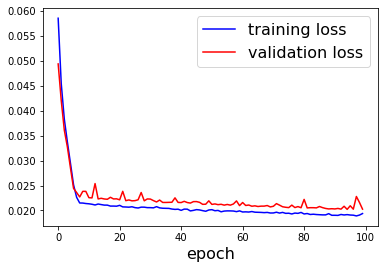

In [57]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

In [58]:
# obtain Yp_test
# "Yp_test=model(X_test)"  may need lots of memory
# we can use a for loop to get Yp_test, see the function test
Yp_test=[]
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
    for batch_idx, (X, Y) in enumerate(dataloader_test):
        X, Y = X.to(device), Y.to(device)
        Yp = model(X)#forward pass
        Yp_test.append(Yp.detach().cpu().numpy())
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()

In [59]:
# compute MSE, MAE and MAPE on test set
# compute MSE, MAE and MAPE on the test set
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
print("Evaluate model on testing set")
print("MSE=",MSE)
print("MAE=",MAE)
print("MAPE=",MAPE)

Evaluate model on testing set
MSE= 0.018703457
MAE= 0.099351116
MAPE= 0.28700456


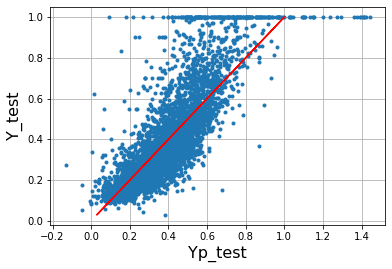

In [60]:
# plot Yp_test vs Y_test
# the red line is the 45-degree line
X_test_t=torch.tensor(X_test, dtype=torch.float32) #convert numpy array to torch tensor
#the input to model should be torch tensor
Yp_test_t=model(X_test_t.to(device))
type(Yp_test_t)
Yp_test=Yp_test_t.detach().cpu().numpy() #convert torch tensor to numpy array
type(Yp_test)
fig, ax = plt.subplots()
ax.plot(Yp_test, Y_test, '.')
ax.plot(Y_test, Y_test, 'r-')
ax.set_xlabel('Yp_test', fontsize=16)
ax.set_ylabel('Y_test', fontsize=16)
ax.grid(True)

### change the structure of the MLP model and see if it can do better than XGBoost

In [ ]:
#define a new model
#train, validate and test the model